In [2]:
import pandas as pd
import logging
import warnings
from pathlib import Path
from tqdm.notebook import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
# import sys
# sys.path.append('/opt/data/Nature')

In [ ]:
# %cd Nature

# Download data

In [4]:
meta_df = pd.read_csv('m1_patchseq_meta_data.csv', delimiter='\t')
meta_df.head()

,Number,Cell,Slice,Date,Sample,Mouse,Mouse date of birth,Mouse age,Mouse gender,Mouse genotype,...,Length (bp),Yield (pg/µl),User,Hold Time (min),Soma depth (µm),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm),Traced,Exclusion reasons
0,1,20171204_sample_2,20171204_slice_2,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,1955,95.19,Fede,8.0,736.7,271.0,535.8,1478.808,y,NaN
1,2,20171204_sample_4,20171204_slice_4,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,1887,80.22,Fede,9.0,726.2,285.7,545.9,1506.684,y,NaN
2,3,20171204_sample_5,20171204_slice_5,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,1869,439.16,Fede,8.0,659.8,241.8,530.4,1463.904,y,NaN
3,4,20171204_sample_6,20171204_slice_6,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,1999,211.71,Fede,8.0,571.7,210.0,501.1,1383.036,y,NaN
4,5,20171207_sample_1,20171207_slice_1,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,F,Sst-IRES-Cre/wt; Ai9/wt,...,1884,986.46,Fede,10.0,772.4,288.9,477.1,1316.796,y,NaN


In [5]:
meta_df.columns

Index(['Number', 'Cell', 'Slice', 'Date', 'Sample', 'Mouse',
       'Mouse date of birth', 'Mouse age', 'Mouse gender', 'Mouse genotype',
       'Targeted layer', 'Inferred layer', 'Cre', 'Exon reads', 'Intron reads',
       'Intergenic reads', 'Sequencing batch', 'Number of genes detected',
       'RNA family', 'RNA type', 'RNA type confidence', 'RNA type top-3',
       'ALM/VISp top-3', 'Length (bp)', 'Yield (pg/µl)', 'User',
       'Hold Time (min)', 'Soma depth (µm)', 'Soma depth (4x)',
       'Cortical thickness (4x)', 'Cortical thickness (µm)', 'Traced',
       'Exclusion reasons'],
      dtype='object')

In [6]:
meta_df.describe()

,Number,Mouse age,Exon reads,Intron reads,Intergenic reads,Sequencing batch,Number of genes detected,RNA type confidence,Hold Time (min),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm)
count,1329.000000,1329.000000,1.329000e+03,1.329000e+03,1.329000e+03,1329.000000,1329.000000,1232.000000,1327.000000,1284.000000,1284.000000,1329.000000
mean,665.000000,83.920993,1.527525e+06,9.722459e+05,1.711816e+05,6.283672,9096.946576,0.764813,29.275810,239.596238,547.978287,1461.209459
std,383.793564,30.626155,1.571455e+06,1.192379e+06,1.923592e+05,2.799803,3534.720600,0.198576,14.933262,144.608019,47.810584,302.834022
min,1.000000,35.000000,2.000000e+00,4.000000e+00,1.000000e+00,1.000000,11.000000,0.140000,3.000000,16.500000,414.800000,0.000000
25%,333.000000,64.000000,6.059430e+05,1.292800e+05,7.268500e+04,4.000000,6905.000000,0.617500,15.000000,112.725000,514.425000,1408.428000
50%,665.000000,75.000000,1.190890e+06,6.881400e+05,1.337650e+05,7.000000,9589.000000,0.810000,29.000000,219.350000,547.000000,1504.476000
75%,997.000000,100.000000,1.930027e+06,1.353231e+06,2.048570e+05,9.000000,11299.000000,0.940000,40.000000,351.700000,580.025000,1597.764000
max,1329.000000,245.000000,1.817294e+07,1.326539e+07,2.326755e+06,12.000000,24833.000000,1.000000,85.000000,675.100000,706.500000,1949.940000


In [7]:
meta_df_L5 = meta_df[meta_df['Inferred layer']=='5']
meta_df_L5.shape, meta_df.shape

((586, 33), (1329, 33))

In [39]:
dandi_ls=!dandi ls -r json https://gui.dandiarchive.org/#/dandiset/000008/draft

In [7]:
def generate_dandi_res():
    res=dict()
    key_fields = ['asset_id', 'created', 'modified', 'path', 'ephys_session_id', 'size']
    for row in dandi_ls:
        sp = row.split(': ')
        if len(sp)==2:
            k,v = sp
            k = k.strip('-').strip()
            v = v.strip("'").strip()
            if k not in key_fields:
                continue
            if k=='asset_id' and res:
                yield res
                res = dict()
            res[k]=v
            if k=='path':
                ephys_id = v.split('_ses-')[-1].split('_')[0]
                res['ephys_session_id']=ephys_id
        else:
            continue
    yield res

In [72]:
gen = generate_dandi_res()
# next(gen)

In [73]:
dandi_ls_df = pd.DataFrame(gen)

In [ ]:
dandi_ls_df['nwb_download_link'] = dandi_ls_df['asset_id'].map(
    lambda id_: f'https://api.dandiarchive.org/api/dandisets/000008/versions/draft/assets/{id_}/download/')
dandi_ls_df.head()

In [75]:
dandi_ls_df.to_csv('dandiset_000008_metadata.csv', index=False)

In [8]:
# optional use
dandi_ls_df = pd.read_csv('dandiset_000008_metadata.csv')

## Download NWB files

In [9]:
meta_mouses = meta_df['Mouse'].str.replace('mouse_','')
meta_samples = meta_df['Cell'].str.replace('_','-')
meta_slices = meta_df['Slice'].str.replace('_','-')
meta_df['path'] = ('sub-mouse-'+meta_mouses+'/'+'sub-mouse-'+meta_mouses+'_ses-'
                  +meta_samples+'_slice-'+meta_slices+'_cell-'+meta_samples+'_icephys.nwb')

In [5]:
meta_df[~meta_df['path'].isin(dandi_ls_df['path'])]

,Number,Cell,Slice,Date,Sample,Mouse,Mouse date of birth,Mouse age,Mouse gender,Mouse genotype,...,Yield (pg/µl),User,Hold Time (min),Soma depth (µm),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm),Traced,Exclusion reasons,path
626,627,20190211_sample_10,20190211_slice_4,2019-02-11,Sample 10,mouse_PYVMS,2018-10-14,120,F,Pvalb-Cre/wt; Ai9/wt,...,207.69,Fede,15.0,1046.7,385.5,546.3,1507.788,y,NaN,sub-mouse-PYVMS/sub-mouse-PYVMS_ses-20190211-s...


One cell not found nwb link.

In [6]:
electro_df = meta_df.merge(dandi_ls_df[['ephys_session_id', 'asset_id', 'nwb_download_link', 'path']],
                          how='inner', on='path', validate='1:1')
electro_df['path'] = electro_df['path'].map(lambda p: 'nwb/'+Path(p).name)

electro_df.head()

,Number,Cell,Slice,Date,Sample,Mouse,Mouse date of birth,Mouse age,Mouse gender,Mouse genotype,...,Soma depth (µm),Soma depth (4x),Cortical thickness (4x),Cortical thickness (µm),Traced,Exclusion reasons,path,ephys_session_id,asset_id,nwb_download_link
0,1,20171204_sample_2,20171204_slice_2,2017-12-04,sample 2,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,736.7,271.0,535.8,1478.808,y,NaN,nwb/sub-mouse-GTOKH_ses-20171204-sample-2_slic...,20171204-sample-2,37c8ef44-9962-4d59-b861-009d94fc2e41,https://api.dandiarchive.org/api/dandisets/000...
1,2,20171204_sample_4,20171204_slice_4,2017-12-04,sample 4,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,726.2,285.7,545.9,1506.684,y,NaN,nwb/sub-mouse-GTOKH_ses-20171204-sample-4_slic...,20171204-sample-4,3f7aeaab-b347-4396-b7de-ca94f220c01a,https://api.dandiarchive.org/api/dandisets/000...
2,3,20171204_sample_5,20171204_slice_5,2017-12-04,sample 5,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,659.8,241.8,530.4,1463.904,y,NaN,nwb/sub-mouse-GTOKH_ses-20171204-sample-5_slic...,20171204-sample-5,69e5512e-ca1e-4bba-977c-79055d33d6bb,https://api.dandiarchive.org/api/dandisets/000...
3,4,20171204_sample_6,20171204_slice_6,2017-12-04,sample 6,mouse_GTOKH,2017-10-29,36,M,Pvalb-Cre/wt; Ai9/wt,...,571.7,210.0,501.1,1383.036,y,NaN,nwb/sub-mouse-GTOKH_ses-20171204-sample-6_slic...,20171204-sample-6,3ad6a394-80d7-407c-9264-2257b4c7d70a,https://api.dandiarchive.org/api/dandisets/000...
4,5,20171207_sample_1,20171207_slice_1,2017-12-07,sample 1,mouse_UGZSW,2017-09-18,80,F,Sst-IRES-Cre/wt; Ai9/wt,...,772.4,288.9,477.1,1316.796,y,NaN,nwb/sub-mouse-UGZSW_ses-20171207-sample-1_slic...,20171207-sample-1,7ad3819e-4077-40a7-978e-c2d0ad1fd747,https://api.dandiarchive.org/api/dandisets/000...


In [ ]:
electro_df.to_csv('m1_electro_meta_df.csv', index=False)

In [12]:
# optional use
electro_df = pd.read_csv('m1_electro_meta_df.csv')

Batch downloading

In [13]:
Path('nwb').mkdir(exist_ok=True)

In [104]:
for download_link in tqdm(electro_df['nwb_download_link']):
    !dandi download -o nwb -e skip {download_link}

  0%|          | 0/1328 [00:00<?, ?it/s]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GTOKH_ses-20171204-sample-2_slice-20171204-slice-2_cell-20171204-sample-2_icephys.nwb 6.5 MB  6.5 MB   100%    ok    done                   
Summary:                                                                                        6.5 MB  6.5 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:00:13,702 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705165835Z-14256.log


  0%|          | 1/1328 [01:39<36:38:04, 99.39s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GTOKH_ses-20171204-sample-4_slice-20171204-slice-4_cell-20171204-sample-4_icephys.nwb 7.0 MB  7.0 MB   100%    ok    done                   
Summary:                                                                                        7.0 MB  7.0 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:01:13,574 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170015Z-14394.log


  0%|          | 2/1328 [02:39<28:02:38, 76.14s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GTOKH_ses-20171204-sample-5_slice-20171204-slice-5_cell-20171204-sample-5_icephys.nwb 5.3 MB  5.3 MB   100%    ok    done                   
Summary:                                                                                        5.3 MB  5.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:01:22,057 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170115Z-14412.log


  0%|          | 3/1328 [02:47<16:39:01, 45.24s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GTOKH_ses-20171204-sample-6_slice-20171204-slice-6_cell-20171204-sample-6_icephys.nwb 6.1 MB  6.1 MB   100%    ok    done                   
Summary:                                                                                        6.1 MB  6.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:01:30,611 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170123Z-14424.log


  0%|          | 4/1328 [02:56<11:18:45, 30.76s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UGZSW_ses-20171207-sample-1_slice-20171207-slice-1_cell-20171207-sample-1_icephys.nwb 8.4 MB  8.4 MB           100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:02:10,854 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170132Z-14436.log


  0%|          | 5/1328 [03:36<12:33:46, 34.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UGZSW_ses-20171207-sample-2_slice-20171207-slice-2_cell-20171207-sample-2_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:05:12,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170212Z-14448.log


  0%|          | 6/1328 [06:38<30:59:33, 84.40s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UGZSW_ses-20171207-sample-6_slice-20171207-slice-6_cell-20171207-sample-6_icephys.nwb 6.1 MB  6.1 MB   100%    ok    done                   
Summary:                                                                                        6.1 MB  6.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:05:22,549 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170514Z-14566.log


  1%|          | 7/1328 [06:48<22:01:25, 60.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UGZSW_ses-20171207-sample-7_slice-20171207-slice-7_cell-20171207-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:08:45,559 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170524Z-14578.log


  1%|          | 8/1328 [10:11<38:41:56, 105.54s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-1_slice-20171219-slice-1_cell-20171219-sample-1_icephys.nwb 3.2 MB  3.2 MB   100%    ok    done                   
Summary:                                                                                        3.2 MB  3.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:09:57,324 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170847Z-14702.log


  1%|          | 9/1328 [11:23<34:47:56, 94.98s/it] 

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-2_slice-20171219-slice-2_cell-20171219-sample-2_icephys.nwb 5.1 MB  5.1 MB   100%    ok    done                   
Summary:                                                                                        5.1 MB  5.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:10:06,543 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705170959Z-14724.log


  1%|          | 10/1328 [11:32<25:04:45, 68.50s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-3_slice-20171219-slice-3_cell-20171219-sample-3_icephys.nwb 4.0 MB  4.0 MB   100%    ok    done                   
Summary:                                                                                        4.0 MB  4.0 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:10:54,689 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171008Z-14737.log


  1%|          | 11/1328 [12:20<22:46:49, 62.27s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-4_slice-20171219-slice-4_cell-20171219-sample-4_icephys.nwb 4.6 MB  4.6 MB   100%    ok    done                   
Summary:                                                                                        4.6 MB  4.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:11:05,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171056Z-14795.log


  1%|          | 12/1328 [12:31<17:02:03, 46.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-6_slice-20171219-slice-6_cell-20171219-sample-6_icephys.nwb 4.5 MB  4.5 MB   100%    ok    done                   
Summary:                                                                                        4.5 MB  4.5 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:11:48,298 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171107Z-14822.log


  1%|          | 13/1328 [13:13<16:36:28, 45.47s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-7_slice-20171219-slice-7_cell-20171219-sample-7_icephys.nwb 4.2 MB  4.2 MB   100%    ok    done                   
Summary:                                                                                        4.2 MB  4.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:12:31,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171149Z-14862.log


  1%|          | 14/1328 [13:57<16:19:51, 44.74s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KKXUD_ses-20171219-sample-8_slice-20171219-slice-8_cell-20171219-sample-8_icephys.nwb 7.6 MB  7.6 MB   100%    ok    done                   
Summary:                                                                                        7.6 MB  7.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:14:40,749 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171233Z-14927.log


  1%|          | 15/1328 [16:06<25:37:31, 70.26s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HXCVU_ses-20180102-sample-1_slice-20180102-slice-1_cell-20180102-sample-1_icephys.nwb 2.6 MB  2.6 MB   100%    ok    done                   
Summary:                                                                                        2.6 MB  2.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:14:57,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171442Z-15034.log


  1%|          | 16/1328 [16:23<19:43:29, 54.12s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HXCVU_ses-20180102-sample-2_slice-20180102-slice-2_cell-20180102-sample-2_icephys.nwb 4.3 MB  4.3 MB   100%    ok    done                   
Summary:                                                                                        4.3 MB  4.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:15:42,355 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171459Z-15060.log


  1%|▏         | 17/1328 [17:08<18:42:29, 51.37s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HXCVU_ses-20180102-sample-3_slice-20180102-slice-3_cell-20180102-sample-3_icephys.nwb 7.2 MB  7.2 MB   100%    ok    done                   
Summary:                                                                                        7.2 MB  7.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:16:33,759 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171544Z-15083.log


  1%|▏         | 18/1328 [17:59<18:41:38, 51.37s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HXCVU_ses-20180102-sample-4_slice-20180102-slice-4_cell-20180102-sample-4_icephys.nwb 4.8 MB  4.8 MB   100%    ok    done                   
Summary:                                                                                        4.8 MB  4.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:16:42,601 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171635Z-15121.log


  1%|▏         | 19/1328 [18:08<14:02:06, 38.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HXCVU_ses-20180102-sample-5_slice-20180102-slice-5_cell-20180102-sample-5_icephys.nwb 5.8 MB  5.8 MB   100%    ok    done                   
Summary:                                                                                        5.8 MB  5.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:17:15,861 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171644Z-15135.log


  2%|▏         | 20/1328 [18:41<13:26:22, 36.99s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-1_slice-20180103-slice-1_cell-20180103-sample-1_icephys.nwb 4.3 MB  4.3 MB   100%    ok    done                   
Summary:                                                                                        4.3 MB  4.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:17:25,394 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171717Z-15156.log


  2%|▏         | 21/1328 [18:51<10:26:36, 28.77s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-2_slice-20180103-slice-2_cell-20180103-sample-2_icephys.nwb 7.6 MB  7.6 MB   100%    ok    done                   
Summary:                                                                                        7.6 MB  7.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:17:44,420 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171727Z-15170.log


  2%|▏         | 22/1328 [19:10<9:22:10, 25.83s/it] 

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-3_slice-20180103-slice-3_cell-20180103-sample-3_icephys.nwb 4.8 MB  4.8 MB   100%    ok    done                   
Summary:                                                                                        4.8 MB  4.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:18:09,730 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171746Z-15222.log


  2%|▏         | 23/1328 [19:35<9:18:24, 25.67s/it]

PATH                                                                                            SIZE    DONE          DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-4_slice-20180103-slice-4_cell-20180103-sample-4_icephys.nwb 8.6 MB  8.6 MB         100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                       1 done                 
                                                                                                        100.00%                                             
2021-07-05 17:19:20,079 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171811Z-15256.log


  2%|▏         | 24/1328 [20:45<14:09:36, 39.09s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-5_slice-20180103-slice-5_cell-20180103-sample-5_icephys.nwb 7.2 MB  7.2 MB   100%    ok    done                   
Summary:                                                                                        7.2 MB  7.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:21:47,389 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705171921Z-15297.log


  2%|▏         | 25/1328 [23:13<25:53:49, 71.55s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-6_slice-20180103-slice-6_cell-20180103-sample-6_icephys.nwb 3.7 MB  3.7 MB   100%    ok    done                   
Summary:                                                                                        3.7 MB  3.7 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:22:14,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172149Z-15489.log


  2%|▏         | 26/1328 [23:40<21:06:24, 58.36s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-7_slice-20180103-slice-7_cell-20180103-sample-7_icephys.nwb 4.3 MB  4.3 MB   100%    ok    done                   
Summary:                                                                                        4.3 MB  4.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:22:26,230 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172216Z-15521.log


  2%|▏         | 27/1328 [23:51<15:59:00, 44.23s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXLFB_ses-20180103-sample-8_slice-20180103-slice-8_cell-20180103-sample-8_icephys.nwb 5.6 MB  5.6 MB   100%    ok    done                   
Summary:                                                                                        5.6 MB  5.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:22:35,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172227Z-15542.log


  2%|▏         | 28/1328 [24:00<12:07:57, 33.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UALZV_ses-20180104-sample-1_slice-20180104-slice-1_cell-20180104-sample-1_icephys.nwb 4.0 MB  4.0 MB   100%    ok    done                   
Summary:                                                                                        4.0 MB  4.0 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:22:46,861 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172236Z-15566.log


  2%|▏         | 29/1328 [24:12<9:46:03, 27.07s/it] 

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UALZV_ses-20180104-sample-2_slice-20180104-slice-2_cell-20180104-sample-2_icephys.nwb 3.2 MB  3.2 MB   100%    ok    done                   
Summary:                                                                                        3.2 MB  3.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:22:58,867 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172248Z-15590.log


  2%|▏         | 30/1328 [24:24<8:07:33, 22.54s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UALZV_ses-20180104-sample-3_slice-20180104-slice-3_cell-20180104-sample-3_icephys.nwb 4.8 MB  4.8 MB   100%    ok    done                   
Summary:                                                                                        4.8 MB  4.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:23:08,670 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172300Z-15609.log


  2%|▏         | 31/1328 [24:34<6:44:52, 18.73s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UALZV_ses-20180104-sample-4_slice-20180104-slice-4_cell-20180104-sample-4_icephys.nwb 4.8 MB  4.8 MB   100%    ok    done                   
Summary:                                                                                        4.8 MB  4.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:23:19,925 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172310Z-15631.log


  2%|▏         | 32/1328 [24:45<5:56:05, 16.49s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UALZV_ses-20180104-sample-6_slice-20180104-slice-6_cell-20180104-sample-6_icephys.nwb 6.0 MB  6.0 MB   100%    ok    done                   
Summary:                                                                                        6.0 MB  6.0 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:23:36,917 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172321Z-15659.log


  2%|▏         | 33/1328 [25:02<5:58:54, 16.63s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LYQJP_ses-20180105-sample-4_slice-20180105-slice-4_cell-20180105-sample-4_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:24:29,087 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172338Z-15687.log


  3%|▎         | 34/1328 [25:54<9:48:49, 27.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LYQJP_ses-20180105-sample-5_slice-20180105-slice-5_cell-20180105-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:24:40,346 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172430Z-15725.log


  3%|▎         | 35/1328 [26:06<8:04:39, 22.49s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LYQJP_ses-20180105-sample-6_slice-20180105-slice-6_cell-20180105-sample-6_icephys.nwb 6.9 MB  6.9 MB   100%    ok    done                   
Summary:                                                                                        6.9 MB  6.9 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:24:49,959 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172441Z-15741.log


  3%|▎         | 36/1328 [26:15<6:41:10, 18.63s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-1_slice-20180108-slice-1_cell-20180108-sample-1_icephys.nwb 4.5 MB  4.5 MB   100%    ok    done                   
Summary:                                                                                        4.5 MB  4.5 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:25:06,605 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172451Z-15753.log


  3%|▎         | 37/1328 [26:32<6:28:00, 18.03s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-2_slice-20180108-slice-2_cell-20180108-sample-2_icephys.nwb 5.4 MB  5.4 MB   100%    ok    done                   
Summary:                                                                                        5.4 MB  5.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:25:16,631 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172508Z-15773.log


  3%|▎         | 38/1328 [26:42<5:36:11, 15.64s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-3_slice-20180108-slice-3_cell-20180108-sample-3_icephys.nwb 6.7 MB  6.7 MB   100%    ok    done                   
Summary:                                                                                        6.7 MB  6.7 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:26:02,057 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172518Z-15795.log


  3%|▎         | 39/1328 [27:27<8:47:41, 24.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-4_slice-20180108-slice-4_cell-20180108-sample-4_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:26:13,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172603Z-15832.log


  3%|▎         | 40/1328 [27:39<7:25:52, 20.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-5_slice-20180108-slice-5_cell-20180108-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:26:25,200 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172615Z-15853.log


  3%|▎         | 41/1328 [27:50<6:24:19, 17.92s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-7_slice-20180108-slice-7_cell-20180108-sample-7_icephys.nwb 5.1 MB  5.1 MB   100%    ok    done                   
Summary:                                                                                        5.1 MB  5.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:26:35,001 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172627Z-15882.log


  3%|▎         | 42/1328 [28:00<5:31:37, 15.47s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-8_slice-20180108-slice-8_cell-20180108-sample-8_icephys.nwb 6.7 MB  6.7 MB   100%    ok    done                   
Summary:                                                                                        6.7 MB  6.7 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:26:43,898 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172636Z-15903.log


  3%|▎         | 43/1328 [28:09<4:49:07, 13.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-9_slice-20180108-slice-9_cell-20180108-sample-9_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:26:53,143 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172645Z-15915.log


  3%|▎         | 44/1328 [28:18<4:21:33, 12.22s/it]

PATH                                                                                               SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOSLW_ses-20180108-sample-10_slice-20180108-slice-10_cell-20180108-sample-10_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                           8.6 MB  8.6 MB                         1 done                 
                                                                                                           100.00%                                               
2021-07-05 17:27:21,830 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172654Z-15933.log


  3%|▎         | 45/1328 [28:47<6:06:55, 17.16s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TYCES_ses-20180109-sample-1_slice-20180109-slice-1_cell-20180109-sample-1_icephys.nwb 4.6 MB  4.6 MB   100%    ok    done                   
Summary:                                                                                        4.6 MB  4.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:27:33,326 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172723Z-15968.log


  3%|▎         | 46/1328 [28:59<5:30:24, 15.46s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TYCES_ses-20180109-sample-2_slice-20180109-slice-2_cell-20180109-sample-2_icephys.nwb 7.8 MB  7.8 MB   100%    ok    done                   
Summary:                                                                                        7.8 MB  7.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:27:42,694 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172734Z-15986.log


  4%|▎         | 47/1328 [29:08<4:51:01, 13.63s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TYCES_ses-20180109-sample-5_slice-20180109-slice-5_cell-20180109-sample-5_icephys.nwb 7.3 MB  7.3 MB   100%    ok    done                   
Summary:                                                                                        7.3 MB  7.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:27:51,534 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172744Z-16006.log


  4%|▎         | 48/1328 [29:17<4:20:11, 12.20s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-1_slice-20180110-slice-1_cell-20180110-sample-1_icephys.nwb 7.8 MB  7.8 MB   100%    ok    done                   
Summary:                                                                                        7.8 MB  7.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:28:00,516 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172752Z-16027.log


  4%|▎         | 49/1328 [29:26<3:59:42, 11.25s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-2_slice-20180110-slice-2_cell-20180110-sample-2_icephys.nwb 6.6 MB  6.6 MB   100%    ok    done                   
Summary:                                                                                        6.6 MB  6.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:28:09,330 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172802Z-16047.log


  4%|▍         | 50/1328 [29:35<3:43:54, 10.51s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-3_slice-20180110-slice-3_cell-20180110-sample-3_icephys.nwb 7.6 MB  7.6 MB   100%    ok    done                   
Summary:                                                                                        7.6 MB  7.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:28:20,181 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172810Z-16067.log


  4%|▍         | 51/1328 [29:45<3:45:31, 10.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-4_slice-20180110-slice-4_cell-20180110-sample-4_icephys.nwb 6.7 MB  6.7 MB   100%    ok    done                   
Summary:                                                                                        6.7 MB  6.7 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:29:09,451 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172821Z-16090.log


  4%|▍         | 52/1328 [30:35<7:52:12, 22.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-5_slice-20180110-slice-5_cell-20180110-sample-5_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:29:19,297 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172910Z-16154.log


  4%|▍         | 53/1328 [30:44<6:33:01, 18.50s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-7_slice-20180110-slice-7_cell-20180110-sample-7_icephys.nwb 6.4 MB  6.4 MB   100%    ok    done                   
Summary:                                                                                        6.4 MB  6.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:29:28,059 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172920Z-16176.log


  4%|▍         | 54/1328 [30:53<5:30:47, 15.58s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GUIGR_ses-20180110-sample-8_slice-20180110-slice-8_cell-20180110-sample-8_icephys.nwb 6.6 MB  6.6 MB   100%    ok    done                   
Summary:                                                                                        6.6 MB  6.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:29:37,004 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172929Z-16197.log


  4%|▍         | 55/1328 [31:02<4:48:17, 13.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DYNRZ_ses-20180111-sample-5_slice-20180111-slice-5_cell-20180111-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:29:47,251 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172938Z-16218.log


  4%|▍         | 56/1328 [31:12<4:26:46, 12.58s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-2_slice-20180115-slice-2_cell-20180115-sample-2_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:30:03,202 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705172948Z-16241.log


  4%|▍         | 57/1328 [31:28<4:48:01, 13.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-5_slice-20180115-slice-5_cell-20180115-sample-5_icephys.nwb 5.0 MB  5.0 MB   100%    ok    done                   
Summary:                                                                                        5.0 MB  5.0 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:30:12,200 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173004Z-16256.log


  4%|▍         | 58/1328 [31:37<4:18:33, 12.22s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-6_slice-20180115-slice-6_cell-20180115-sample-6_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:30:32,789 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173013Z-16275.log


  4%|▍         | 59/1328 [31:58<5:11:38, 14.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-7_slice-20180115-slice-7_cell-20180115-sample-7_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:30:44,638 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173034Z-16313.log


  5%|▍         | 60/1328 [32:10<4:52:59, 13.86s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-8_slice-20180115-slice-8_cell-20180115-sample-8_icephys.nwb 6.2 MB  6.2 MB   100%    ok    done                   
Summary:                                                                                        6.2 MB  6.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:30:53,092 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173046Z-16335.log


  5%|▍         | 61/1328 [32:18<4:18:25, 12.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IZUBT_ses-20180115-sample-9_slice-20180115-slice-9_cell-20180115-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:31:02,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173054Z-16356.log


  5%|▍         | 62/1328 [32:28<4:03:24, 11.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-1_slice-20180118-slice-1_cell-20180118-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:31:12,401 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173104Z-16378.log


  5%|▍         | 63/1328 [32:38<3:49:52, 10.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-2_slice-20180118-slice-2_cell-20180118-sample-2_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:31:23,738 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173113Z-16397.log


  5%|▍         | 64/1328 [32:49<3:52:17, 11.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-4_slice-20180118-slice-4_cell-20180118-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:31:33,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173125Z-16421.log


  5%|▍         | 65/1328 [32:59<3:43:15, 10.61s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-6_slice-20180118-slice-6_cell-20180118-sample-6_icephys.nwb 6.5 MB  6.5 MB   100%    ok    done                   
Summary:                                                                                        6.5 MB  6.5 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:31:42,313 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173134Z-16443.log


  5%|▍         | 66/1328 [33:07<3:32:37, 10.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-7_slice-20180118-slice-7_cell-20180118-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:31:52,231 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173143Z-16459.log


  5%|▌         | 67/1328 [33:17<3:31:23, 10.06s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OGLHO_ses-20180118-sample-10_slice-20180118-slice-10_cell-20180118-sample-10_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                           8.7 MB  8.7 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 17:32:01,484 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173153Z-16481.log


  5%|▌         | 68/1328 [33:27<3:26:08,  9.82s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CNQDR_ses-20180123-sample-1_slice-20180123-slice-1_cell-20180123-sample-1_icephys.nwb 7.3 MB  7.3 MB   100%    ok    done                   
Summary:                                                                                        7.3 MB  7.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:32:20,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173203Z-16502.log


  5%|▌         | 69/1328 [33:46<4:23:41, 12.57s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CNQDR_ses-20180123-sample-3_slice-20180123-slice-3_cell-20180123-sample-3_icephys.nwb 4.1 MB  4.1 MB   100%    ok    done                   
Summary:                                                                                        4.1 MB  4.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:32:28,766 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173221Z-16528.log


  5%|▌         | 70/1328 [33:54<3:56:37, 11.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CNQDR_ses-20180123-sample-5_slice-20180123-slice-5_cell-20180123-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:32:37,907 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173230Z-16551.log


  5%|▌         | 71/1328 [34:03<3:42:51, 10.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CNQDR_ses-20180123-sample-6_slice-20180123-slice-6_cell-20180123-sample-6_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:32:47,572 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173239Z-16568.log


  5%|▌         | 72/1328 [34:13<3:36:41, 10.35s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CNQDR_ses-20180123-sample-7_slice-20180123-slice-7_cell-20180123-sample-7_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:33:09,787 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173249Z-16587.log


  5%|▌         | 73/1328 [34:35<4:50:50, 13.90s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HDBFV_ses-20180208-sample-1_slice-20180208-slice-1_cell-20180208-sample-1_icephys.nwb 6.4 MB  6.4 MB   100%    ok    done                   
Summary:                                                                                        6.4 MB  6.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:33:18,323 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173311Z-16612.log


  6%|▌         | 74/1328 [34:43<4:17:00, 12.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HDBFV_ses-20180208-sample-2_slice-20180208-slice-2_cell-20180208-sample-2_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:33:27,602 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173319Z-16632.log


  6%|▌         | 75/1328 [34:53<3:57:54, 11.39s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HDBFV_ses-20180208-sample-3_slice-20180208-slice-3_cell-20180208-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:33:38,576 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173329Z-16653.log


  6%|▌         | 76/1328 [35:04<3:55:03, 11.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HDBFV_ses-20180208-sample-4_slice-20180208-slice-4_cell-20180208-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:33:47,533 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173339Z-16675.log


  6%|▌         | 77/1328 [35:13<3:40:34, 10.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HDBFV_ses-20180208-sample-5_slice-20180208-slice-5_cell-20180208-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:33:58,162 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173349Z-16692.log


  6%|▌         | 78/1328 [35:23<3:40:29, 10.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JDVRZ_ses-20180213-sample-3_slice-20180213-slice-3_cell-20180213-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:34:12,213 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173359Z-16711.log


  6%|▌         | 79/1328 [35:37<4:02:08, 11.63s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JDVRZ_ses-20180213-sample-5_slice-20180213-slice-5_cell-20180213-sample-5_icephys.nwb 8.8 MB  8.8 MB           100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:34:31,663 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173413Z-16729.log


  6%|▌         | 80/1328 [35:57<4:50:45, 13.98s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LBJDN_ses-20180215-sample-1_slice-20180215-slice-1_cell-20180215-sample-1_icephys.nwb 8.8 MB  8.8 MB           100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:35:00,347 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173433Z-16759.log


  6%|▌         | 81/1328 [36:26<6:22:07, 18.39s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-POHNW_ses-20180220-sample-1_slice-20180220-slice-1_cell-20180220-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:35:09,862 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173501Z-16785.log


  6%|▌         | 82/1328 [36:35<5:26:47, 15.74s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-POHNW_ses-20180220-sample-2_slice-20180220-slice-2_cell-20180220-sample-2_icephys.nwb 4.9 MB  4.9 MB   100%    ok    done                   
Summary:                                                                                        4.9 MB  4.9 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:35:20,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173511Z-16804.log


  6%|▋         | 83/1328 [36:46<4:55:13, 14.23s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-1_slice-20180225-slice-1_cell-20180225-sample-1_icephys.nwb 6.6 MB  6.6 MB   100%    ok    done                   
Summary:                                                                                        6.6 MB  6.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:35:29,445 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173522Z-16824.log


  6%|▋         | 84/1328 [36:55<4:21:38, 12.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-2_slice-20180225-slice-2_cell-20180225-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:35:42,896 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173531Z-16842.log


  6%|▋         | 85/1328 [37:08<4:26:35, 12.87s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-3_slice-20180225-slice-3_cell-20180225-sample-3_icephys.nwb 4.8 MB  4.8 MB   100%    ok    done                   
Summary:                                                                                        4.8 MB  4.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:35:51,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173544Z-16865.log


  6%|▋         | 86/1328 [37:17<4:00:43, 11.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-4_slice-20180225-slice-4_cell-20180225-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:36:02,530 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173553Z-16879.log


  7%|▋         | 87/1328 [37:28<3:55:57, 11.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-5_slice-20180225-slice-5_cell-20180225-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:36:12,837 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173604Z-16897.log


  7%|▋         | 88/1328 [37:38<3:48:55, 11.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YHUPM_ses-20180225-sample-7_slice-20180225-slice-7_cell-20180225-sample-7_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:36:23,052 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173614Z-16914.log


  7%|▋         | 89/1328 [37:48<3:43:37, 10.83s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ROUXZ_ses-20180228-sample-3_slice-20180228-slice-3_cell-20180228-sample-3_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:36:33,297 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173624Z-16932.log


  7%|▋         | 90/1328 [37:59<3:39:40, 10.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YMIOM_ses-20180306-sample-1_slice-20180306-slice-1_cell-20180306-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:36:42,849 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173634Z-16959.log


  7%|▋         | 91/1328 [38:08<3:32:30, 10.31s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YMIOM_ses-20180306-sample-2_slice-20180306-slice-2_cell-20180306-sample-2_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:36:51,998 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173644Z-16977.log


  7%|▋         | 92/1328 [38:17<3:25:09,  9.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YMIOM_ses-20180306-sample-3_slice-20180306-slice-3_cell-20180306-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:37:00,958 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173653Z-16998.log


  7%|▋         | 93/1328 [38:26<3:18:51,  9.66s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YMIOM_ses-20180306-sample-5_slice-20180306-slice-5_cell-20180306-sample-5_icephys.nwb 8.4 MB  8.4 MB           100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:37:29,320 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173702Z-17019.log


  7%|▋         | 94/1328 [38:54<5:13:57, 15.27s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AYGIX_ses-20180309-sample-4_slice-20180309-slice-4_cell-20180309-sample-4_icephys.nwb 8.4 MB  8.4 MB   100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:37:38,813 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173730Z-17051.log


  7%|▋         | 95/1328 [39:04<4:38:17, 13.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AYGIX_ses-20180309-sample-6_slice-20180309-slice-6_cell-20180309-sample-6_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:37:47,665 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173740Z-17069.log


  7%|▋         | 96/1328 [39:13<4:09:05, 12.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AYGIX_ses-20180309-sample-7_slice-20180309-slice-7_cell-20180309-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:37:56,942 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173749Z-17089.log


  7%|▋         | 97/1328 [39:22<3:51:15, 11.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AYGIX_ses-20180309-sample-8_slice-20180309-slice-8_cell-20180309-sample-8_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:38:06,571 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173758Z-17110.log


  7%|▋         | 98/1328 [39:32<3:41:11, 10.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ALHXK_ses-20180313-sample-1_slice-20180313-slice-1_cell-20180313-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:38:17,293 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173808Z-17132.log


  7%|▋         | 99/1328 [39:42<3:40:22, 10.76s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ALHXK_ses-20180313-sample-2_slice-20180313-slice-2_cell-20180313-sample-2_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:38:26,038 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173818Z-17155.log


  8%|▊         | 100/1328 [39:51<3:27:56, 10.16s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ALHXK_ses-20180313-sample-3_slice-20180313-slice-3_cell-20180313-sample-3_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:38:46,251 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173827Z-17174.log


  8%|▊         | 101/1328 [40:11<4:29:19, 13.17s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQHCC_ses-20180313-sample-7_slice-20180313-slice-7_cell-20180313-sample-7_icephys.nwb 8.5 MB  8.5 MB           100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:39:29,443 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173847Z-17212.log


  8%|▊         | 102/1328 [40:55<7:33:04, 22.17s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQHCC_ses-20180313-sample-8_slice-20180313-slice-8_cell-20180313-sample-8_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:39:38,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173930Z-17260.log


  8%|▊         | 103/1328 [41:03<6:10:18, 18.14s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQHCC_ses-20180313-sample-9_slice-20180313-slice-9_cell-20180313-sample-9_icephys.nwb 5.2 MB  5.2 MB   100%    ok    done                   
Summary:                                                                                        5.2 MB  5.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:39:46,572 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173939Z-17281.log


  8%|▊         | 104/1328 [41:12<5:10:29, 15.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AEJGZ_ses-20180315-sample-1_slice-20180315-slice-1_cell-20180315-sample-1_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:39:55,355 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173947Z-17299.log


  8%|▊         | 105/1328 [41:21<4:30:51, 13.29s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AEJGZ_ses-20180315-sample-2_slice-20180315-slice-2_cell-20180315-sample-2_icephys.nwb 5.2 MB  5.2 MB   100%    ok    done                   
Summary:                                                                                        5.2 MB  5.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:40:03,507 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705173956Z-17319.log


  8%|▊         | 106/1328 [41:29<3:59:18, 11.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AEJGZ_ses-20180315-sample-5_slice-20180315-slice-5_cell-20180315-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:40:13,223 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174005Z-17338.log


  8%|▊         | 107/1328 [41:38<3:46:40, 11.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AEJGZ_ses-20180315-sample-6_slice-20180315-slice-6_cell-20180315-sample-6_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:40:22,975 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174014Z-17357.log


  8%|▊         | 108/1328 [41:48<3:37:59, 10.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGIHL_ses-20180321-sample-2_slice-20180321-slice-2_cell-20180321-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:40:32,818 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174024Z-17379.log


  8%|▊         | 109/1328 [41:58<3:32:26, 10.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGIHL_ses-20180321-sample-3_slice-20180321-slice-3_cell-20180321-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:40:42,647 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174034Z-17404.log


  8%|▊         | 110/1328 [42:08<3:28:29, 10.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGIHL_ses-20180321-sample-4_slice-20180321-slice-4_cell-20180321-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:40:52,483 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174044Z-17426.log


  8%|▊         | 111/1328 [42:18<3:25:42, 10.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGIHL_ses-20180321-sample-8_slice-20180321-slice-8_cell-20180321-sample-8_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:41:03,915 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174054Z-17444.log


  8%|▊         | 112/1328 [42:29<3:33:17, 10.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGIHL_ses-20180321-sample-9_slice-20180321-slice-9_cell-20180321-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:41:12,760 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174105Z-17465.log


  9%|▊         | 113/1328 [42:38<3:22:59, 10.02s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-1_slice-20180322-slice-1_cell-20180322-sample-1_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:41:25,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174114Z-17485.log


  9%|▊         | 114/1328 [42:51<3:40:13, 10.88s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-2_slice-20180322-slice-2_cell-20180322-sample-2_icephys.nwb 9.2 MB  9.2 MB           100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:41:42,982 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174127Z-17510.log


  9%|▊         | 115/1328 [43:08<4:19:09, 12.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-3_slice-20180322-slice-3_cell-20180322-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:41:53,043 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174144Z-17540.log


  9%|▊         | 116/1328 [43:18<4:02:12, 11.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-4_slice-20180322-slice-4_cell-20180322-sample-4_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:02,483 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174154Z-17563.log


  9%|▉         | 117/1328 [43:28<3:46:32, 11.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-5_slice-20180322-slice-5_cell-20180322-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:11,617 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174203Z-17583.log


  9%|▉         | 118/1328 [43:37<3:33:48, 10.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-6_slice-20180322-slice-6_cell-20180322-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:20,909 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174213Z-17601.log


  9%|▉         | 119/1328 [43:46<3:25:42, 10.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BAPWW_ses-20180322-sample-7_slice-20180322-slice-7_cell-20180322-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:29,965 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174222Z-17623.log


  9%|▉         | 120/1328 [43:55<3:18:29,  9.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-1_slice-20180327-slice-1_cell-20180327-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:39,562 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174231Z-17650.log


  9%|▉         | 121/1328 [44:05<3:16:44,  9.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-2_slice-20180327-slice-2_cell-20180327-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:42:49,029 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174241Z-17672.log


  9%|▉         | 122/1328 [44:14<3:14:43,  9.69s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-3_slice-20180327-slice-3_cell-20180327-sample-3_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:43:08,101 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174250Z-17694.log


  9%|▉         | 123/1328 [44:33<4:11:07, 12.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-4_slice-20180327-slice-4_cell-20180327-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:43:17,325 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174309Z-17723.log


  9%|▉         | 124/1328 [44:42<3:51:09, 11.52s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-5_slice-20180327-slice-5_cell-20180327-sample-5_icephys.nwb 9.2 MB  9.2 MB           100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:43:47,650 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174318Z-17742.log


  9%|▉         | 125/1328 [45:13<5:44:10, 17.17s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XECLH_ses-20180327-sample-6_slice-20180327-slice-6_cell-20180327-sample-6_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:44:23,213 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174349Z-17777.log


  9%|▉         | 126/1328 [45:48<7:34:21, 22.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-1_slice-20180329-slice-1_cell-20180329-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:44:33,145 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174424Z-17819.log


 10%|▉         | 127/1328 [45:58<6:17:35, 18.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-2_slice-20180329-slice-2_cell-20180329-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:44:43,238 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174435Z-17844.log


 10%|▉         | 128/1328 [46:08<5:24:34, 16.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-3_slice-20180329-slice-3_cell-20180329-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:44:57,191 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174444Z-17859.log


 10%|▉         | 129/1328 [46:22<5:10:42, 15.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-4_slice-20180329-slice-4_cell-20180329-sample-4_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:45:08,764 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174459Z-17881.log


 10%|▉         | 130/1328 [46:34<4:46:44, 14.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-5_slice-20180329-slice-5_cell-20180329-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:45:22,081 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174510Z-17899.log


 10%|▉         | 131/1328 [46:47<4:40:01, 14.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-6_slice-20180329-slice-6_cell-20180329-sample-6_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:45:33,585 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174523Z-17917.log


 10%|▉         | 132/1328 [46:59<4:24:42, 13.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-7_slice-20180329-slice-7_cell-20180329-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:45:43,690 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174535Z-17937.log


 10%|█         | 133/1328 [47:09<4:05:31, 12.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VCACE_ses-20180329-sample-8_slice-20180329-slice-8_cell-20180329-sample-8_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:45:55,238 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174545Z-17956.log


 10%|█         | 134/1328 [47:20<4:00:39, 12.09s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ONCAE_ses-20180403-sample-5_slice-20180403-slice-5_cell-20180403-sample-5_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:46:54,978 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174556Z-17975.log


 10%|█         | 135/1328 [48:20<8:44:34, 26.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ONCAE_ses-20180403-sample-6_slice-20180403-slice-6_cell-20180403-sample-6_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:47:03,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174656Z-18037.log


 10%|█         | 136/1328 [48:29<7:00:34, 21.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ONCAE_ses-20180403-sample-7_slice-20180403-slice-7_cell-20180403-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:47:18,056 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174705Z-18055.log


 10%|█         | 137/1328 [48:43<6:18:05, 19.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-1_slice-20180404-slice-1_cell-20180404-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:47:32,025 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174719Z-18073.log


 10%|█         | 138/1328 [48:57<5:47:28, 17.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-2_slice-20180404-slice-2_cell-20180404-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:47:42,730 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174733Z-18092.log


 10%|█         | 139/1328 [49:08<5:06:36, 15.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-3_slice-20180404-slice-3_cell-20180404-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:47:52,062 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174744Z-18109.log


 11%|█         | 140/1328 [49:17<4:29:57, 13.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-4_slice-20180404-slice-4_cell-20180404-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:01,329 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174753Z-18122.log


 11%|█         | 141/1328 [49:27<4:03:53, 12.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-5_slice-20180404-slice-5_cell-20180404-sample-5_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:10,615 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174802Z-18139.log


 11%|█         | 142/1328 [49:36<3:45:34, 11.41s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWNGI_ses-20180404-sample-7_slice-20180404-slice-7_cell-20180404-sample-7_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:48:20,553 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174812Z-18156.log


 11%|█         | 143/1328 [49:46<3:36:37, 10.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOZJM_ses-20180405-sample-1_slice-20180405-slice-1_cell-20180405-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:29,664 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174822Z-18176.log


 11%|█         | 144/1328 [49:55<3:25:31, 10.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOZJM_ses-20180405-sample-2_slice-20180405-slice-2_cell-20180405-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:39,486 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174831Z-18193.log


 11%|█         | 145/1328 [50:05<3:22:04, 10.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOZJM_ses-20180405-sample-3_slice-20180405-slice-3_cell-20180405-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:48,889 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174841Z-18217.log


 11%|█         | 146/1328 [50:14<3:16:37,  9.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-1_slice-20180410-slice-1_cell-20180410-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:48:58,214 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174850Z-18234.log


 11%|█         | 147/1328 [50:23<3:12:36,  9.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-3_slice-20180410-slice-3_cell-20180410-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:08,041 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174859Z-18253.log


 11%|█         | 148/1328 [50:33<3:12:41,  9.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-4_slice-20180410-slice-4_cell-20180410-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:17,248 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174909Z-18270.log


 11%|█         | 149/1328 [50:42<3:09:06,  9.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-5_slice-20180410-slice-5_cell-20180410-sample-5_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:28,045 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174918Z-18287.log


 11%|█▏        | 150/1328 [50:53<3:15:46,  9.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-6_slice-20180410-slice-5_cell-20180410-sample-6_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:36,627 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174929Z-18309.log


 11%|█▏        | 151/1328 [51:02<3:07:26,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGQTD_ses-20180410-sample-9_slice-20180410-slice-7_cell-20180410-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:45,406 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174938Z-18327.log


 11%|█▏        | 152/1328 [51:11<3:02:43,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EWGMO_ses-20180411-sample-1_slice-20180411-slice-1_cell-20180411-sample-1_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:49:54,592 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174946Z-18346.log


 12%|█▏        | 153/1328 [51:20<3:01:42,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EWGMO_ses-20180411-sample-3_slice-20180411-slice-3_cell-20180411-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:50:03,890 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705174956Z-18363.log


 12%|█▏        | 154/1328 [51:29<3:01:36,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EWGMO_ses-20180411-sample-4_slice-20180411-slice-4_cell-20180411-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:50:13,325 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175005Z-18381.log


 12%|█▏        | 155/1328 [51:39<3:02:41,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EWGMO_ses-20180411-sample-5_slice-20180411-slice-5_cell-20180411-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:50:23,015 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175015Z-18397.log


 12%|█▏        | 156/1328 [51:48<3:04:23,  9.44s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KDMGS_ses-20180412-sample-1_slice-20180412-slice-1_cell-20180412-sample-1_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:50:33,597 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175024Z-18412.log


 12%|█▏        | 157/1328 [51:59<3:10:49,  9.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KDMGS_ses-20180412-sample-2_slice-20180412-slice-2_cell-20180412-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:50:42,681 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175035Z-18429.log


 12%|█▏        | 158/1328 [52:08<3:06:44,  9.58s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KDMGS_ses-20180412-sample-3_slice-20180412-slice-3_cell-20180412-sample-3_icephys.nwb 6.1 MB  6.1 MB   100%    ok    done                   
Summary:                                                                                        6.1 MB  6.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:50:51,199 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175044Z-18453.log


 12%|█▏        | 159/1328 [52:16<3:00:18,  9.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KDMGS_ses-20180412-sample-4_slice-20180412-slice-4_cell-20180412-sample-4_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:00,053 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175052Z-18474.log


 12%|█▏        | 160/1328 [52:25<2:57:51,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KDMGS_ses-20180412-sample-7_slice-20180412-slice-7_cell-20180412-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:09,115 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175101Z-18495.log


 12%|█▏        | 161/1328 [52:34<2:57:07,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VBJMY_ses-20180413-sample-2_slice-20180413-slice-2_cell-20180413-sample-2_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:18,902 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175110Z-18511.log


 12%|█▏        | 162/1328 [52:44<3:01:09,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VBJMY_ses-20180413-sample-3_slice-20180413-slice-3_cell-20180413-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:28,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175120Z-18526.log


 12%|█▏        | 163/1328 [52:53<3:00:53,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VBJMY_ses-20180413-sample-4_slice-20180413-slice-4_cell-20180413-sample-4_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:37,082 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175129Z-18547.log


 12%|█▏        | 164/1328 [53:02<2:58:01,  9.18s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS        MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-1_slice-20180417-slice-1_cell-20180417-sample-1_icephys.nwb 8.7 MB                         downloading          
Summary:                                                                                        8.7 MB  0 Bytes                1 downloading        
                                                                                                        0.00%                                       


ERROR: 1 asynchronous worker failed

Producing value for row ('sub-mouse-UFLLT_ses-20180417-sample-1_slice-20180417-slice-1_cell-20180417-sample-1_icephys.nwb',) failed:
Traceback (most recent call last):
  File "/usr/local/envs/neuron/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/usr/local/envs/neuron/lib/python3.8/s

 12%|█▏        | 165/1328 [53:09<2:46:27,  8.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-2_slice-20180417-slice-2_cell-20180417-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:51:53,904 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175145Z-18583.log


 12%|█▎        | 166/1328 [53:19<2:52:21,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-3_slice-20180417-slice-3_cell-20180417-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:52:02,684 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175155Z-18603.log


 13%|█▎        | 167/1328 [53:28<2:51:29,  8.86s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-4_slice-20180417-slice-3_cell-20180417-sample-4_icephys.nwb 7.1 MB  7.1 MB   100%    ok    done                   
Summary:                                                                                        7.1 MB  7.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:52:14,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175204Z-18623.log


 13%|█▎        | 168/1328 [53:40<3:09:16,  9.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-5_slice-20180417-slice-4_cell-20180417-sample-5_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:52:23,622 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175216Z-18647.log


 13%|█▎        | 169/1328 [53:49<3:04:27,  9.55s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-6_slice-20180417-slice-5_cell-20180417-sample-6_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:52:32,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175225Z-18669.log


 13%|█▎        | 170/1328 [53:58<3:00:36,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-7_slice-20180417-slice-6_cell-20180417-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:52:41,560 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175234Z-18687.log


 13%|█▎        | 171/1328 [54:07<2:58:27,  9.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-8_slice-20180417-slice-7_cell-20180417-sample-8_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:52:50,600 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175243Z-18709.log


 13%|█▎        | 172/1328 [54:16<2:56:58,  9.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFLLT_ses-20180417-sample-9_slice-20180417-slice-8_cell-20180417-sample-9_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:52:59,261 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175252Z-18725.log


 13%|█▎        | 173/1328 [54:24<2:53:50,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KZWYG_ses-20180418-sample-1_slice-20180418-slice-1_cell-20180418-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:08,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175300Z-18746.log


 13%|█▎        | 174/1328 [54:34<2:55:07,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KZWYG_ses-20180418-sample-2_slice-20180418-slice-2_cell-20180418-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:17,838 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175310Z-18768.log


 13%|█▎        | 175/1328 [54:43<2:56:15,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KZWYG_ses-20180418-sample-3_slice-20180418-slice-3_cell-20180418-sample-3_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:27,963 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175319Z-18789.log


 13%|█▎        | 176/1328 [54:53<3:01:21,  9.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KZWYG_ses-20180418-sample-5_slice-20180418-slice-5_cell-20180418-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:37,648 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175329Z-18810.log


 13%|█▎        | 177/1328 [55:03<3:02:40,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KZWYG_ses-20180418-sample-6_slice-20180418-slice-6_cell-20180418-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:47,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175339Z-18829.log


 13%|█▎        | 178/1328 [55:12<3:01:56,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AAYYT_ses-20180420-sample-2_slice-20180420-slice-2_cell-20180420-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:53:56,357 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175348Z-18847.log


 13%|█▎        | 179/1328 [55:22<3:00:33,  9.43s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AAYYT_ses-20180420-sample-3_slice-20180420-slice-3_cell-20180420-sample-3_icephys.nwb 9.3 MB  9.3 MB           100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:54:11,050 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175357Z-18869.log


 14%|█▎        | 180/1328 [55:36<3:30:45, 11.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AAYYT_ses-20180420-sample-4_slice-20180420-slice-4_cell-20180420-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:54:21,753 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175412Z-18891.log


 14%|█▎        | 181/1328 [55:47<3:28:46, 10.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MICGF_ses-20180424-sample-1_slice-20180424-slice-1_cell-20180424-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:54:31,068 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175423Z-18913.log


 14%|█▎        | 182/1328 [55:56<3:19:30, 10.45s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MICGF_ses-20180424-sample-2_slice-20180424-slice-2_cell-20180424-sample-2_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:54:40,998 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175432Z-18933.log


 14%|█▍        | 183/1328 [56:06<3:16:50, 10.31s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MICGF_ses-20180424-sample-3_slice-20180424-slice-3_cell-20180424-sample-3_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:54:51,445 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175443Z-18958.log


 14%|█▍        | 184/1328 [56:17<3:16:54, 10.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MICGF_ses-20180424-sample-6_slice-20180424-slice-6_cell-20180424-sample-6_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:01,504 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175453Z-18977.log


 14%|█▍        | 185/1328 [56:27<3:15:10, 10.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-2_slice-20180425-slice-2_cell-20180425-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:11,039 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175503Z-18997.log


 14%|█▍        | 186/1328 [56:36<3:10:55, 10.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-3_slice-20180425-slice-2_cell-20180425-sample-3_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:20,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175512Z-19019.log


 14%|█▍        | 187/1328 [56:46<3:08:53,  9.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-4_slice-20180425-slice-3_cell-20180425-sample-4_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:31,008 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175522Z-19036.log


 14%|█▍        | 188/1328 [56:56<3:10:37, 10.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-5_slice-20180425-slice-4_cell-20180425-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:40,749 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175532Z-19056.log


 14%|█▍        | 189/1328 [57:06<3:08:48,  9.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-7_slice-20180425-slice-6_cell-20180425-sample-7_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:49,977 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175542Z-19076.log


 14%|█▍        | 190/1328 [57:15<3:04:33,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-8_slice-20180425-slice-7_cell-20180425-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:55:59,623 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175551Z-19095.log


 14%|█▍        | 191/1328 [57:25<3:03:51,  9.70s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HIEAS_ses-20180425-sample-9_slice-20180425-slice-8_cell-20180425-sample-9_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:56:11,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175601Z-19116.log


 14%|█▍        | 192/1328 [57:37<3:17:11, 10.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-1_slice-20180426-slice-1_cell-20180426-sample-1_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:56:21,459 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175613Z-19135.log


 15%|█▍        | 193/1328 [57:47<3:13:16, 10.22s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-3_slice-20180426-slice-3_cell-20180426-sample-3_icephys.nwb 4.3 MB  4.3 MB   100%    ok    done                   
Summary:                                                                                        4.3 MB  4.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:56:30,144 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175623Z-19153.log


 15%|█▍        | 194/1328 [57:55<3:04:31,  9.76s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-4_slice-20180426-slice-4_cell-20180426-sample-4_icephys.nwb 9.2 MB  9.2 MB           100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 17:56:49,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175631Z-19172.log


 15%|█▍        | 195/1328 [58:14<3:56:00, 12.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-5_slice-20180426-slice-5_cell-20180426-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:56:58,345 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175650Z-19204.log


 15%|█▍        | 196/1328 [58:24<3:37:36, 11.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-7_slice-20180426-slice-7_cell-20180426-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:57:08,162 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175700Z-19223.log


 15%|█▍        | 197/1328 [58:33<3:27:39, 11.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JLXOV_ses-20180426-sample-9_slice-20180426-slice-9_cell-20180426-sample-9_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:57:17,730 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175709Z-19242.log


 15%|█▍        | 198/1328 [58:43<3:19:31, 10.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-2_slice-20180501-slice-2_cell-20180501-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:57:27,114 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175719Z-19262.log


 15%|█▍        | 199/1328 [58:52<3:12:23, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-3_slice-20180501-slice-3_cell-20180501-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:57:36,188 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175728Z-19281.log


 15%|█▌        | 200/1328 [59:01<3:05:44,  9.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-4_slice-20180501-slice-4_cell-20180501-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:57:45,483 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175737Z-19301.log


 15%|█▌        | 201/1328 [59:11<3:02:21,  9.71s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-5_slice-20180501-slice-5_cell-20180501-sample-5_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:57:54,325 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175747Z-19318.log


 15%|█▌        | 202/1328 [59:19<2:57:10,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-6_slice-20180501-slice-6_cell-20180501-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:03,145 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175755Z-19335.log


 15%|█▌        | 203/1328 [59:28<2:53:31,  9.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-7_slice-20180501-slice-7_cell-20180501-sample-7_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:12,335 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175804Z-19347.log


 15%|█▌        | 204/1328 [59:38<2:53:05,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XITQQ_ses-20180501-sample-8_slice-20180501-slice-8_cell-20180501-sample-8_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:21,900 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175813Z-19363.log


 15%|█▌        | 205/1328 [59:47<2:54:42,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZTLGB_ses-20180502-sample-1_slice-20180502-slice-1_cell-20180502-sample-1_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:31,502 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175823Z-19382.log


 16%|█▌        | 206/1328 [59:57<2:56:00,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZTLGB_ses-20180502-sample-2_slice-20180502-slice-2_cell-20180502-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:41,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175833Z-19399.log


 16%|█▌        | 207/1328 [1:00:07<3:01:13,  9.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZTLGB_ses-20180502-sample-3_slice-20180502-slice-3_cell-20180502-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:58:51,447 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175843Z-19417.log


 16%|█▌        | 208/1328 [1:00:17<3:00:34,  9.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZTLGB_ses-20180502-sample-4_slice-20180502-slice-4_cell-20180502-sample-4_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:01,092 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175853Z-19441.log


 16%|█▌        | 209/1328 [1:00:26<3:00:02,  9.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CQEQX_ses-20180508-sample-1_slice-20180508-slice-1_cell-20180508-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:10,373 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175902Z-19457.log


 16%|█▌        | 210/1328 [1:00:36<2:57:46,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CQEQX_ses-20180508-sample-2_slice-20180508-slice-2_cell-20180508-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:19,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175911Z-19477.log


 16%|█▌        | 211/1328 [1:00:45<2:56:16,  9.47s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CQEQX_ses-20180508-sample-3_slice-20180508-slice-3_cell-20180508-sample-3_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 17:59:28,757 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175921Z-19499.log


 16%|█▌        | 212/1328 [1:00:54<2:54:00,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CQEQX_ses-20180508-sample-4_slice-20180508-slice-4_cell-20180508-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:37,839 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175930Z-19519.log


 16%|█▌        | 213/1328 [1:01:03<2:52:20,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-1_slice-20180509-slice-1_cell-20180509-sample-1_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:47,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175939Z-19539.log


 16%|█▌        | 214/1328 [1:01:12<2:51:57,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-2_slice-20180509-slice-2_cell-20180509-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 17:59:57,015 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175948Z-19556.log


 16%|█▌        | 215/1328 [1:01:22<2:55:39,  9.47s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-3_slice-20180509-slice-3_cell-20180509-sample-3_icephys.nwb 8.1 MB  8.1 MB   100%    ok    done                   
Summary:                                                                                        8.1 MB  8.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:00:05,596 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705175958Z-19575.log


 16%|█▋        | 216/1328 [1:01:31<2:50:32,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-4_slice-20180509-slice-4_cell-20180509-sample-4_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:00:14,539 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180007Z-19594.log


 16%|█▋        | 217/1328 [1:01:40<2:48:56,  9.12s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-5_slice-20180509-slice-3_cell-20180509-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:00:23,981 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180016Z-19611.log


 16%|█▋        | 218/1328 [1:01:49<2:50:31,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-7_slice-20180509-slice-5_cell-20180509-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:00:33,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180025Z-19631.log


 16%|█▋        | 219/1328 [1:01:58<2:50:00,  9.20s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QQBBV_ses-20180509-sample-9_slice-20180509-slice-7_cell-20180509-sample-9_icephys.nwb 8.4 MB  8.4 MB   100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:00:41,830 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180034Z-19651.log


 17%|█▋        | 220/1328 [1:02:07<2:47:01,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WEAAS_ses-20180510-sample-2_slice-20180510-slice-2_cell-20180510-sample-2_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:00:51,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180043Z-19669.log


 17%|█▋        | 221/1328 [1:02:16<2:47:45,  9.09s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WEAAS_ses-20180510-sample-3_slice-20180510-slice-3_cell-20180510-sample-3_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:01:00,739 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180052Z-19695.log


 17%|█▋        | 222/1328 [1:02:26<2:51:06,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WEAAS_ses-20180510-sample-4_slice-20180510-slice-4_cell-20180510-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:01:09,840 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180102Z-19713.log


 17%|█▋        | 223/1328 [1:02:35<2:49:58,  9.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WEAAS_ses-20180510-sample-5_slice-20180510-slice-5_cell-20180510-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:01:19,906 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180111Z-19733.log


 17%|█▋        | 224/1328 [1:02:45<2:54:18,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WEAAS_ses-20180510-sample-9_slice-20180510-slice-7_cell-20180510-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:01:29,244 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180121Z-19753.log


 17%|█▋        | 225/1328 [1:02:54<2:53:19,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BULZF_ses-20180515-sample-1_slice-20180515-slice-1_cell-20180515-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:01:38,467 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180130Z-19772.log


 17%|█▋        | 226/1328 [1:03:04<2:52:03,  9.37s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BULZF_ses-20180515-sample-6_slice-20180515-slice-6_cell-20180515-sample-6_icephys.nwb 9.7 MB  9.7 MB           100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:01:52,962 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180139Z-19791.log


 17%|█▋        | 227/1328 [1:03:18<3:20:06, 10.91s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-1_slice-20180522-slice-1_cell-20180522-sample-1_icephys.nwb 8.4 MB  8.4 MB   100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:02:01,833 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180154Z-19814.log


 17%|█▋        | 228/1328 [1:03:27<3:08:49, 10.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-2_slice-20180522-slice-2_cell-20180522-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:02:10,985 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180203Z-19833.log


 17%|█▋        | 229/1328 [1:03:36<3:02:22,  9.96s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-3_slice-20180522-slice-3_cell-20180522-sample-3_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:02:20,029 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180212Z-19851.log


 17%|█▋        | 230/1328 [1:03:45<2:57:06,  9.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-4_slice-20180522-slice-4_cell-20180522-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:02:29,160 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180221Z-19870.log


 17%|█▋        | 231/1328 [1:03:54<2:53:57,  9.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-5_slice-20180522-slice-5_cell-20180522-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:02:38,130 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180230Z-19890.log


 17%|█▋        | 232/1328 [1:04:03<2:50:49,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-6_slice-20180522-slice-6_cell-20180522-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:02:51,666 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180239Z-19908.log


 18%|█▊        | 233/1328 [1:04:17<3:13:34, 10.61s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WDWKX_ses-20180522-sample-7_slice-20180522-slice-7_cell-20180522-sample-7_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:03:00,942 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180253Z-19936.log


 18%|█▊        | 234/1328 [1:04:26<3:06:07, 10.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QFXET_ses-20180524-sample-5_slice-20180524-slice-5_cell-20180524-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:10,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180302Z-19953.log


 18%|█▊        | 235/1328 [1:04:35<3:00:51,  9.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BFVKP_ses-20180524-sample-8_slice-20180524-slice-8_cell-20180524-sample-8_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:21,082 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180311Z-19965.log


 18%|█▊        | 236/1328 [1:04:46<3:05:48, 10.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QFXET_ses-20180524-sample-9_slice-20180524-slice-9_cell-20180524-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:32,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180322Z-19982.log


 18%|█▊        | 237/1328 [1:04:58<3:12:52, 10.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:41,095 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180333Z-20001.log


 18%|█▊        | 238/1328 [1:05:06<3:01:06,  9.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTDSZ_ses-20180608-sample-1_slice-20180608-slice-1_cell-20180608-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:50,875 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180342Z-20019.log


 18%|█▊        | 239/1328 [1:05:16<2:59:50,  9.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTDSZ_ses-20180608-sample-2_slice-20180608-slice-2_cell-20180608-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:03:59,715 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180352Z-20039.log


 18%|█▊        | 240/1328 [1:05:25<2:53:52,  9.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTDSZ_ses-20180608-sample-3_slice-20180608-slice-3_cell-20180608-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:04:08,743 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180401Z-20057.log


 18%|█▊        | 241/1328 [1:05:34<2:50:39,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTDSZ_ses-20180608-sample-5_slice-20180608-slice-5_cell-20180608-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:04:18,223 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180410Z-20071.log


 18%|█▊        | 242/1328 [1:05:43<2:50:59,  9.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSTGT_ses-20180619-sample-3_slice-20180619-slice-3_cell-20180619-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:04:28,528 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180419Z-20089.log


 18%|█▊        | 243/1328 [1:05:54<2:55:28,  9.70s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSTGT_ses-20180619-sample-5_slice-20180619-slice-5_cell-20180619-sample-5_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:04:37,679 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180430Z-20107.log


 18%|█▊        | 244/1328 [1:06:03<2:52:18,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSTGT_ses-20180619-sample-7_slice-20180619-slice-7_cell-20180619-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:04:47,415 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180439Z-20124.log


 18%|█▊        | 245/1328 [1:06:13<2:53:12,  9.60s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-1_slice-20180621-slice-1_cell-20180621-sample-1_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:04:57,186 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180449Z-20141.log


 19%|█▊        | 246/1328 [1:06:22<2:54:11,  9.66s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-2_slice-20180621-slice-2_cell-20180621-sample-2_icephys.nwb 8.4 MB  8.4 MB   100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:05:07,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180459Z-20164.log


 19%|█▊        | 247/1328 [1:06:32<2:55:20,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-3_slice-20180621-slice-3_cell-20180621-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:05:16,680 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180508Z-20182.log


 19%|█▊        | 248/1328 [1:06:42<2:54:13,  9.68s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-4_slice-20180621-slice-4_cell-20180621-sample-4_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:05:25,904 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180518Z-20199.log


 19%|█▉        | 249/1328 [1:06:51<2:51:37,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-5_slice-20180621-slice-5_cell-20180621-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:05:35,240 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180527Z-20215.log


 19%|█▉        | 250/1328 [1:07:00<2:50:25,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-7_slice-20180621-slice-7_cell-20180621-sample-7_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:05:45,531 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180536Z-20233.log


 19%|█▉        | 251/1328 [1:07:11<2:54:33,  9.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IAHGR_ses-20180621-sample-8_slice-20180621-slice-8_cell-20180621-sample-8_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:05:59,801 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180547Z-20253.log


 19%|█▉        | 252/1328 [1:07:25<3:18:52, 11.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HAKYY_ses-20180628-sample-2_slice-20180628-slice-2_cell-20180628-sample-2_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:06:09,577 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180601Z-20272.log


 19%|█▉        | 253/1328 [1:07:35<3:11:33, 10.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HAKYY_ses-20180628-sample-3_slice-20180628-slice-3_cell-20180628-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:06:20,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180611Z-20293.log


 19%|█▉        | 254/1328 [1:07:45<3:10:32, 10.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HAKYY_ses-20180628-sample-4_slice-20180628-slice-4_cell-20180628-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:06:29,800 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180621Z-20313.log


 19%|█▉        | 255/1328 [1:07:55<3:05:17, 10.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HAKYY_ses-20180628-sample-6_slice-20180628-slice-6_cell-20180628-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:06:40,348 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180631Z-20333.log


 19%|█▉        | 256/1328 [1:08:06<3:06:02, 10.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HAKYY_ses-20180628-sample-7_slice-20180628-slice-7_cell-20180628-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:06:49,425 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180642Z-20350.log


 19%|█▉        | 257/1328 [1:08:15<2:58:40, 10.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RWJCG_ses-20180703-sample-1_slice-20180703-slice-1_cell-20180703-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:00,868 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180650Z-20367.log


 19%|█▉        | 258/1328 [1:08:26<3:06:00, 10.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RWJCG_ses-20180703-sample-2_slice-20180703-slice-2_cell-20180703-sample-2_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:09,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180702Z-20391.log


 20%|█▉        | 259/1328 [1:08:35<2:55:36,  9.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RWJCG_ses-20180703-sample-3_slice-20180703-slice-3_cell-20180703-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:18,888 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180710Z-20408.log


 20%|█▉        | 260/1328 [1:08:44<2:53:45,  9.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PZPYT_ses-20180704-sample-1_slice-20180704-slice-1_cell-20180704-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:29,133 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180720Z-20423.log


 20%|█▉        | 261/1328 [1:08:54<2:56:07,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PZPYT_ses-20180704-sample-2_slice-20180704-slice-2_cell-20180704-sample-2_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:38,348 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180730Z-20441.log


 20%|█▉        | 262/1328 [1:09:04<2:52:18,  9.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PZPYT_ses-20180704-sample-3_slice-20180704-slice-3_cell-20180704-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:07:50,982 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180739Z-20461.log


 20%|█▉        | 263/1328 [1:09:16<3:07:47, 10.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PZPYT_ses-20180704-sample-4_slice-20180704-slice-4_cell-20180704-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:00,161 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180752Z-20483.log


 20%|█▉        | 264/1328 [1:09:25<3:00:12, 10.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PZPYT_ses-20180704-sample-5_slice-20180704-slice-5_cell-20180704-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:09,851 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180801Z-20502.log


 20%|█▉        | 265/1328 [1:09:35<2:57:22, 10.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QBAPL_ses-20180705-sample-1_slice-20180705-slice-1_cell-20180705-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:18,947 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180811Z-20521.log


 20%|██        | 266/1328 [1:09:44<2:52:24,  9.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QBAPL_ses-20180705-sample-4_slice-20180705-slice-4_cell-20180705-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:27,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180820Z-20539.log


 20%|██        | 267/1328 [1:09:53<2:48:02,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EEWII_ses-20180709-sample-2_slice-20180709-slice-2_cell-20180709-sample-2_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:36,877 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180829Z-20559.log


 20%|██        | 268/1328 [1:10:02<2:45:11,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EEWII_ses-20180709-sample-3_slice-20180709-slice-3_cell-20180709-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:46,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180838Z-20581.log


 20%|██        | 269/1328 [1:10:12<2:47:33,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EEWII_ses-20180709-sample-4_slice-20180709-slice-4_cell-20180709-sample-4_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:08:56,419 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180848Z-20601.log


 20%|██        | 270/1328 [1:10:22<2:48:40,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EEWII_ses-20180709-sample-6_slice-20180709-slice-6_cell-20180709-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:05,998 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180858Z-20625.log


 20%|██        | 271/1328 [1:10:31<2:48:28,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSPPC_ses-20180710-sample-1_slice-20180710-slice-1_cell-20180710-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:15,231 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180907Z-20644.log


 20%|██        | 272/1328 [1:10:40<2:46:33,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSPPC_ses-20180710-sample-2_slice-20180710-slice-2_cell-20180710-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:24,563 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180916Z-20663.log


 21%|██        | 273/1328 [1:10:50<2:45:43,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSPPC_ses-20180710-sample-3_slice-20180710-slice-3_cell-20180710-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:33,798 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180926Z-20683.log


 21%|██        | 274/1328 [1:10:59<2:44:32,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSPPC_ses-20180710-sample-5_slice-20180710-slice-5_cell-20180710-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:43,355 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180935Z-20703.log


 21%|██        | 275/1328 [1:11:09<2:45:19,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TXVXA_ses-20180711-sample-1_slice-20180711-slice-1_cell-20180711-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:09:52,534 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180944Z-20722.log


 21%|██        | 276/1328 [1:11:18<2:43:54,  9.35s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TXVXA_ses-20180711-sample-2_slice-20180711-slice-2_cell-20180711-sample-2_icephys.nwb 9.4 MB  9.4 MB           100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:10:07,206 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705180953Z-20742.log


 21%|██        | 277/1328 [1:11:32<3:11:39, 10.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TXVXA_ses-20180711-sample-3_slice-20180711-slice-3_cell-20180711-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:10:16,413 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181008Z-20765.log


 21%|██        | 278/1328 [1:11:42<3:02:34, 10.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TXVXA_ses-20180711-sample-4_slice-20180711-slice-4_cell-20180711-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:10:25,462 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181017Z-20785.log


 21%|██        | 279/1328 [1:11:51<2:55:02, 10.01s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-2_slice-20180712-slice-2_cell-20180712-sample-2_icephys.nwb 8.6 MB  8.6 MB           100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:10:46,296 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181026Z-20807.log


 21%|██        | 280/1328 [1:12:11<3:51:29, 13.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-3_slice-20180712-slice-3_cell-20180712-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:10:55,191 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181047Z-20841.log


 21%|██        | 281/1328 [1:12:20<3:28:31, 11.95s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-5_slice-20180712-slice-5_cell-20180712-sample-5_icephys.nwb 9.2 MB  9.2 MB           100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:11:15,041 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181056Z-20863.log


 21%|██        | 282/1328 [1:12:40<4:09:36, 14.32s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-11_slice-20180712-slice-11_cell-20180712-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:11:26,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181116Z-20898.log


 21%|██▏       | 283/1328 [1:12:52<3:54:40, 13.47s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-12_slice-20180712-slice-12_cell-20180712-sample-12_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:11:38,250 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181128Z-20921.log


 21%|██▏       | 284/1328 [1:13:03<3:45:08, 12.94s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-13_slice-20180712-slice-13_cell-20180712-sample-13_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                           8.8 MB  8.8 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:11:49,025 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181139Z-20940.log


 21%|██▏       | 285/1328 [1:13:14<3:33:38, 12.29s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-14_slice-20180712-slice-14_cell-20180712-sample-14_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:11:58,095 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181150Z-20957.log


 22%|██▏       | 286/1328 [1:13:23<3:16:47, 11.33s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTKQH_ses-20180712-sample-15_slice-20180712-slice-15_cell-20180712-sample-15_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:12:07,465 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181159Z-20973.log


 22%|██▏       | 287/1328 [1:13:33<3:06:20, 10.74s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-1_slice-20180717-slice-1_cell-20180717-sample-1_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:12:33,490 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181209Z-20994.log


 22%|██▏       | 288/1328 [1:13:59<4:25:35, 15.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-2_slice-20180717-slice-2_cell-20180717-sample-2_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:12:43,243 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181234Z-21032.log


 22%|██▏       | 289/1328 [1:14:08<3:56:26, 13.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-3_slice-20180717-slice-3_cell-20180717-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:12:52,422 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181244Z-21053.log


 22%|██▏       | 290/1328 [1:14:18<3:32:58, 12.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-4_slice-20180717-slice-4_cell-20180717-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:01,525 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181253Z-21075.log


 22%|██▏       | 291/1328 [1:14:27<3:16:16, 11.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-6_slice-20180717-slice-6_cell-20180717-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:10,659 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181303Z-21099.log


 22%|██▏       | 292/1328 [1:14:36<3:04:26, 10.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFHTC_ses-20180717-sample-7_slice-20180717-slice-7_cell-20180717-sample-7_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:19,810 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181312Z-21117.log


 22%|██▏       | 293/1328 [1:14:45<2:56:22, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYCYR_ses-20180718-sample-2_slice-20180718-slice-2_cell-20180718-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:28,569 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181321Z-21135.log


 22%|██▏       | 294/1328 [1:14:54<2:48:41,  9.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYCYR_ses-20180718-sample-3_slice-20180718-slice-3_cell-20180718-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:37,529 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181330Z-21149.log


 22%|██▏       | 295/1328 [1:15:03<2:44:09,  9.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYCYR_ses-20180718-sample-4_slice-20180718-slice-4_cell-20180718-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:47,003 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181339Z-21170.log


 22%|██▏       | 296/1328 [1:15:12<2:43:42,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NRBVC_ses-20180719-sample-1_slice-20180719-slice-1_cell-20180719-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:13:56,347 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181348Z-21189.log


 22%|██▏       | 297/1328 [1:15:22<2:42:37,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NRBVC_ses-20180719-sample-4_slice-20180719-slice-4_cell-20180719-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:14:05,681 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181357Z-21209.log


 22%|██▏       | 298/1328 [1:15:31<2:41:50,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PIDAD_ses-20180720-sample-2_slice-20180720-slice-2_cell-20180720-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:14:15,466 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181407Z-21231.log


 23%|██▎       | 299/1328 [1:15:41<2:43:34,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PIDAD_ses-20180720-sample-3_slice-20180720-slice-3_cell-20180720-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:14:25,437 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181417Z-21252.log


 23%|██▎       | 300/1328 [1:15:51<2:45:40,  9.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PIDAD_ses-20180720-sample-5_slice-20180720-slice-5_cell-20180720-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:14:34,988 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181427Z-21271.log


 23%|██▎       | 301/1328 [1:16:00<2:44:53,  9.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ANUPT_ses-20180725-sample-3_slice-20180725-slice-3_cell-20180725-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:14:44,592 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181436Z-21289.log


 23%|██▎       | 302/1328 [1:16:10<2:44:39,  9.63s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ANUPT_ses-20180725-sample-4_slice-20180725-slice-4_cell-20180725-sample-4_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:14:54,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181446Z-21307.log


 23%|██▎       | 303/1328 [1:16:19<2:43:52,  9.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ANUPT_ses-20180725-sample-6_slice-20180725-slice-6_cell-20180725-sample-6_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:04,365 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181455Z-21324.log


 23%|██▎       | 304/1328 [1:16:30<2:47:12,  9.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ANUPT_ses-20180725-sample-7_slice-20180725-slice-7_cell-20180725-sample-7_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:14,813 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181506Z-21348.log


 23%|██▎       | 305/1328 [1:16:40<2:50:15,  9.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ANUPT_ses-20180725-sample-9_slice-20180725-slice-9_cell-20180725-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:25,392 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181516Z-21371.log


 23%|██▎       | 306/1328 [1:16:51<2:53:05, 10.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XHGCQ_ses-20180726-sample-3_slice-20180726-slice-3_cell-20180726-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:34,673 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181527Z-21392.log


 23%|██▎       | 307/1328 [1:17:00<2:48:25,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XHGCQ_ses-20180726-sample-4_slice-20180726-slice-4_cell-20180726-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:44,559 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181536Z-21411.log


 23%|██▎       | 308/1328 [1:17:10<2:48:15,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XHGCQ_ses-20180726-sample-5_slice-20180726-slice-5_cell-20180726-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:15:54,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181546Z-21431.log


 23%|██▎       | 309/1328 [1:17:20<2:50:13, 10.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XHGCQ_ses-20180726-sample-6_slice-20180726-slice-6_cell-20180726-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:04,635 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181556Z-21452.log


 23%|██▎       | 310/1328 [1:17:30<2:48:40,  9.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XHGCQ_ses-20180726-sample-7_slice-20180726-slice-7_cell-20180726-sample-7_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:14,618 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181606Z-21471.log


 23%|██▎       | 311/1328 [1:17:40<2:48:40,  9.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-2_slice-20180817-slice-2_cell-20180817-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:24,499 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181616Z-21489.log


 23%|██▎       | 312/1328 [1:17:50<2:48:15,  9.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-3_slice-20180817-slice-3_cell-20180817-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:34,312 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181626Z-21507.log


 24%|██▎       | 313/1328 [1:17:59<2:47:25,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-4_slice-20180817-slice-4_cell-20180817-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:43,737 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181635Z-21527.log


 24%|██▎       | 314/1328 [1:18:09<2:44:45,  9.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-5_slice-20180817-slice-5_cell-20180817-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:16:52,930 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181645Z-21546.log


 24%|██▎       | 315/1328 [1:18:18<2:41:45,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-6_slice-20180817-slice-6_cell-20180817-sample-6_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:17:01,913 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181654Z-21563.log


 24%|██▍       | 316/1328 [1:18:27<2:38:39,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-APLSV_ses-20180817-sample-7_slice-20180817-slice-7_cell-20180817-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:17:11,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181703Z-21585.log


 24%|██▍       | 317/1328 [1:18:36<2:37:52,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-1_slice-20180820-slice-1_cell-20180820-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:17:21,856 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181712Z-21605.log


 24%|██▍       | 318/1328 [1:18:47<2:44:10,  9.75s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-2_slice-20180820-slice-2_cell-20180820-sample-2_icephys.nwb 9.0 MB  9.0 MB           100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:17:42,169 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181723Z-21625.log


 24%|██▍       | 319/1328 [1:19:07<3:37:20, 12.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-3_slice-20180820-slice-3_cell-20180820-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:17:51,331 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181743Z-21652.log


 24%|██▍       | 320/1328 [1:19:16<3:18:09, 11.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-4_slice-20180820-slice-4_cell-20180820-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:01,828 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181752Z-21671.log


 24%|██▍       | 321/1328 [1:19:27<3:11:22, 11.40s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-5_slice-20180820-slice-5_cell-20180820-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:11,164 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181803Z-21688.log


 24%|██▍       | 322/1328 [1:19:36<3:00:46, 10.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-6_slice-20180820-slice-6_cell-20180820-sample-6_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:20,062 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181812Z-21710.log


 24%|██▍       | 323/1328 [1:19:45<2:51:12, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WVNFF_ses-20180820-sample-7_slice-20180820-slice-7_cell-20180820-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:29,292 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181821Z-21729.log


 24%|██▍       | 324/1328 [1:19:54<2:46:00,  9.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-1_slice-20180822-slice-1_cell-20180822-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:38,456 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181830Z-21749.log


 24%|██▍       | 325/1328 [1:20:04<2:42:07,  9.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-2_slice-20180822-slice-2_cell-20180822-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:18:49,391 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181839Z-21767.log


 25%|██▍       | 326/1328 [1:20:15<2:47:58, 10.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-3_slice-20180822-slice-3_cell-20180822-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:00,298 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181850Z-21785.log


 25%|██▍       | 327/1328 [1:20:25<2:52:08, 10.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-4_slice-20180822-slice-4_cell-20180822-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:09,543 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181901Z-21807.log


 25%|██▍       | 328/1328 [1:20:35<2:46:44, 10.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-6_slice-20180822-slice-6_cell-20180822-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:19,167 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181911Z-21825.log


 25%|██▍       | 329/1328 [1:20:44<2:44:37,  9.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MSVHB_ses-20180822-sample-7_slice-20180822-slice-7_cell-20180822-sample-7_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:28,548 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181920Z-21851.log


 25%|██▍       | 330/1328 [1:20:54<2:41:51,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-2_slice-20180828-slice-2_cell-20180828-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:37,965 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181929Z-21869.log


 25%|██▍       | 331/1328 [1:21:03<2:40:07,  9.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-3_slice-20180828-slice-3_cell-20180828-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:46,818 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181939Z-21891.log


 25%|██▌       | 332/1328 [1:21:12<2:36:06,  9.40s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-4_slice-20180828-slice-4_cell-20180828-sample-4_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:19:56,862 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181948Z-21912.log


 25%|██▌       | 333/1328 [1:21:22<2:39:05,  9.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-5_slice-20180828-slice-5_cell-20180828-sample-5_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:20:05,933 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705181958Z-21931.log


 25%|██▌       | 334/1328 [1:21:31<2:36:16,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-6_slice-20180828-slice-6_cell-20180828-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:20:14,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182007Z-21943.log


 25%|██▌       | 335/1328 [1:21:40<2:33:55,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-7_slice-20180828-slice-7_cell-20180828-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:20:23,482 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182016Z-21955.log


 25%|██▌       | 336/1328 [1:21:49<2:30:04,  9.08s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UAOAE_ses-20180828-sample-8_slice-20180828-slice-8_cell-20180828-sample-8_icephys.nwb 7.1 MB  7.1 MB   100%    ok    done                   
Summary:                                                                                        7.1 MB  7.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:20:31,705 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182024Z-21967.log


 25%|██▌       | 337/1328 [1:21:57<2:25:40,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-1_slice-20180829-slice-1_cell-20180829-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:20:42,469 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182032Z-21979.log


 25%|██▌       | 338/1328 [1:22:08<2:35:11,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-2_slice-20180829-slice-2_cell-20180829-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:20:51,143 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182043Z-21991.log


 26%|██▌       | 339/1328 [1:22:16<2:31:24,  9.19s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-3_slice-20180829-slice-3_cell-20180829-sample-3_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:21:08,267 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182052Z-22003.log


 26%|██▌       | 340/1328 [1:22:33<3:10:27, 11.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-4_slice-20180829-slice-4_cell-20180829-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:21:16,905 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182109Z-22015.log


 26%|██▌       | 341/1328 [1:22:42<2:55:51, 10.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-5_slice-20180829-slice-5_cell-20180829-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:21:25,874 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182118Z-22033.log


 26%|██▌       | 342/1328 [1:22:51<2:47:08, 10.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-6_slice-20180829-slice-6_cell-20180829-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:21:34,566 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182127Z-22045.log


 26%|██▌       | 343/1328 [1:23:00<2:39:42,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-7_slice-20180829-slice-7_cell-20180829-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:21:45,531 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182135Z-22057.log


 26%|██▌       | 344/1328 [1:23:11<2:45:37, 10.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PSDCQ_ses-20180829-sample-8_slice-20180829-slice-8_cell-20180829-sample-8_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:21:56,347 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182146Z-22069.log


 26%|██▌       | 345/1328 [1:23:21<2:48:58, 10.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QLNUF_ses-20180830-sample-1_slice-20180830-slice-1_cell-20180830-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:04,722 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182157Z-22081.log


 26%|██▌       | 346/1328 [1:23:30<2:39:16,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QLNUF_ses-20180830-sample-2_slice-20180830-slice-2_cell-20180830-sample-2_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:12,950 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182205Z-22093.log


 26%|██▌       | 347/1328 [1:23:38<2:31:45,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QLNUF_ses-20180830-sample-5_slice-20180830-slice-5_cell-20180830-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:21,155 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182214Z-22105.log


 26%|██▌       | 348/1328 [1:23:46<2:26:19,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QLNUF_ses-20180830-sample-6_slice-20180830-slice-6_cell-20180830-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:29,802 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182222Z-22117.log


 26%|██▋       | 349/1328 [1:23:55<2:24:38,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-1_slice-20180904-slice-1_cell-20180904-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:39,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182230Z-22129.log


 26%|██▋       | 350/1328 [1:24:05<2:28:13,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-2_slice-20180904-slice-2_cell-20180904-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:49,455 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182240Z-22141.log


 26%|██▋       | 351/1328 [1:24:15<2:32:37,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-3_slice-20180904-slice-3_cell-20180904-sample-3_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:22:57,859 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182250Z-22153.log


 27%|██▋       | 352/1328 [1:24:23<2:27:45,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-4_slice-20180904-slice-4_cell-20180904-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:06,338 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182259Z-22165.log


 27%|██▋       | 353/1328 [1:24:31<2:24:36,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-5_slice-20180904-slice-5_cell-20180904-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:15,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182307Z-22177.log


 27%|██▋       | 354/1328 [1:24:40<2:23:25,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-6_slice-20180904-slice-6_cell-20180904-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:24,095 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182316Z-22192.log


 27%|██▋       | 355/1328 [1:24:49<2:24:26,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-7_slice-20180904-slice-7_cell-20180904-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:33,228 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182325Z-22204.log


 27%|██▋       | 356/1328 [1:24:58<2:25:24,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIEXQ_ses-20180904-sample-9_slice-20180904-slice-9_cell-20180904-sample-9_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:41,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182334Z-22216.log


 27%|██▋       | 357/1328 [1:25:07<2:22:31,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUCAT_ses-20180905-sample-1_slice-20180905-slice-1_cell-20180905-sample-1_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:50,219 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182342Z-22228.log


 27%|██▋       | 358/1328 [1:25:15<2:21:16,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUCAT_ses-20180905-sample-2_slice-20180905-slice-2_cell-20180905-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:23:58,838 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182351Z-22240.log


 27%|██▋       | 359/1328 [1:25:24<2:20:32,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UWACR_ses-20180910-sample-2_slice-20180910-slice-2_cell-20180910-sample-2_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:24:08,150 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182400Z-22252.log


 27%|██▋       | 360/1328 [1:25:33<2:23:21,  8.89s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UWACR_ses-20180910-sample-3_slice-20180910-slice-3_cell-20180910-sample-3_icephys.nwb 9.6 MB  9.6 MB           100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:25:01,850 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182409Z-22264.log


 27%|██▋       | 361/1328 [1:26:27<5:59:59, 22.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YJVZC_ses-20180911-sample-1_slice-20180911-slice-1_cell-20180911-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:11,250 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182503Z-22276.log


 27%|██▋       | 362/1328 [1:26:36<4:57:15, 18.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YJVZC_ses-20180911-sample-2_slice-20180911-slice-2_cell-20180911-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:21,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182512Z-22288.log


 27%|██▋       | 363/1328 [1:26:46<4:14:58, 15.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YJVZC_ses-20180911-sample-3_slice-20180911-slice-3_cell-20180911-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:31,655 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182522Z-22303.log


 27%|██▋       | 364/1328 [1:26:57<3:49:26, 14.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YJVZC_ses-20180911-sample-5_slice-20180911-slice-5_cell-20180911-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:41,045 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182533Z-22315.log


 27%|██▋       | 365/1328 [1:27:06<3:25:44, 12.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YJVZC_ses-20180911-sample-6_slice-20180911-slice-6_cell-20180911-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:50,212 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182542Z-22327.log


 28%|██▊       | 366/1328 [1:27:15<3:07:55, 11.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HNXRO_ses-20180912-sample-2_slice-20180912-slice-2_cell-20180912-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:25:59,303 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182551Z-22339.log


 28%|██▊       | 367/1328 [1:27:24<2:55:05, 10.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HNXRO_ses-20180912-sample-3_slice-20180912-slice-3_cell-20180912-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:08,189 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182600Z-22351.log


 28%|██▊       | 368/1328 [1:27:33<2:45:06, 10.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HNXRO_ses-20180912-sample-6_slice-20180912-slice-6_cell-20180912-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:18,201 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182609Z-22363.log


 28%|██▊       | 369/1328 [1:27:43<2:43:26, 10.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VWBJB_ses-20180913-sample-2_slice-20180913-slice-2_cell-20180913-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:27,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182619Z-22375.log


 28%|██▊       | 370/1328 [1:27:52<2:37:24,  9.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZQHAI_ses-20180917-sample-1_slice-20180917-slice-1_cell-20180917-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:35,811 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182628Z-22387.log


 28%|██▊       | 371/1328 [1:28:01<2:31:09,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZQHAI_ses-20180917-sample-2_slice-20180917-slice-2_cell-20180917-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:44,643 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182637Z-22399.log


 28%|██▊       | 372/1328 [1:28:10<2:27:54,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZQHAI_ses-20180917-sample-3_slice-20180917-slice-3_cell-20180917-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:26:52,823 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182645Z-22411.log


 28%|██▊       | 373/1328 [1:28:18<2:22:27,  8.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZQHAI_ses-20180917-sample-4_slice-20180917-slice-4_cell-20180917-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:27:00,985 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182654Z-22423.log


 28%|██▊       | 374/1328 [1:28:26<2:18:32,  8.71s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZQHAI_ses-20180917-sample-5_slice-20180917-slice-5_cell-20180917-sample-5_icephys.nwb 9.3 MB  9.3 MB           100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:27:19,790 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182702Z-22435.log


 28%|██▊       | 375/1328 [1:28:45<3:06:28, 11.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KVPGJ_ses-20180918-sample-1_slice-20180918-slice-1_cell-20180918-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:27:28,381 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182720Z-22450.log


 28%|██▊       | 376/1328 [1:28:54<2:51:18, 10.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KVPGJ_ses-20180918-sample-2_slice-20180918-slice-2_cell-20180918-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:27:37,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182729Z-22462.log


 28%|██▊       | 377/1328 [1:29:02<2:41:55, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KVPGJ_ses-20180918-sample-3_slice-20180918-slice-3_cell-20180918-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:27:46,366 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182738Z-22474.log


 28%|██▊       | 378/1328 [1:29:12<2:36:34,  9.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WZCRY_ses-20180920-sample-1_slice-20180920-slice-1_cell-20180920-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:27:55,065 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182747Z-22486.log


 29%|██▊       | 379/1328 [1:29:20<2:30:45,  9.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WZCRY_ses-20180920-sample-2_slice-20180920-slice-2_cell-20180920-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:03,543 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182756Z-22498.log


 29%|██▊       | 380/1328 [1:29:29<2:25:36,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WZCRY_ses-20180920-sample-3_slice-20180920-slice-3_cell-20180920-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:11,994 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182804Z-22510.log


 29%|██▊       | 381/1328 [1:29:37<2:22:04,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WZCRY_ses-20180920-sample-4_slice-20180920-slice-4_cell-20180920-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:21,365 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182813Z-22522.log


 29%|██▉       | 382/1328 [1:29:47<2:23:27,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XMZGY_ses-20180921-sample-1_slice-20180921-slice-1_cell-20180921-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:30,471 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182822Z-22534.log


 29%|██▉       | 383/1328 [1:29:56<2:23:17,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XMZGY_ses-20180921-sample-2_slice-20180921-slice-2_cell-20180921-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:38,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182831Z-22546.log


 29%|██▉       | 384/1328 [1:30:04<2:20:06,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XMZGY_ses-20180921-sample-3_slice-20180921-slice-3_cell-20180921-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:48,004 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182840Z-22558.log


 29%|██▉       | 385/1328 [1:30:13<2:20:47,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DMTAH_ses-20180925-sample-9_slice-20180925-slice-9_cell-20180925-sample-9_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:28:58,916 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182849Z-22570.log


 29%|██▉       | 386/1328 [1:30:24<2:29:56,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NPNLS_ses-20180926-sample-1_slice-20180926-slice-1_cell-20180926-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:29:08,209 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182900Z-22582.log


 29%|██▉       | 387/1328 [1:30:33<2:28:28,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NPNLS_ses-20180926-sample-3_slice-20180926-slice-3_cell-20180926-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:29:16,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182909Z-22594.log


 29%|██▉       | 388/1328 [1:30:42<2:22:40,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NPNLS_ses-20180926-sample-4_slice-20180926-slice-4_cell-20180926-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:29:25,229 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182917Z-22606.log


 29%|██▉       | 389/1328 [1:30:50<2:20:50,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NPNLS_ses-20180926-sample-7_slice-20180926-slice-7_cell-20180926-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:29:33,793 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182926Z-22621.log


 29%|██▉       | 390/1328 [1:30:59<2:18:38,  8.87s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NPNLS_ses-20180926-sample-9_slice-20180926-slice-9_cell-20180926-sample-9_icephys.nwb 8.1 MB  8.1 MB   100%    ok    done                   
Summary:                                                                                        8.1 MB  8.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:29:42,498 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182934Z-22633.log


 29%|██▉       | 391/1328 [1:31:08<2:17:45,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-1_slice-20180927-slice-1_cell-20180927-sample-1_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:29:52,001 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182943Z-22645.log


 30%|██▉       | 392/1328 [1:31:17<2:20:49,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-2_slice-20180927-slice-2_cell-20180927-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:00,918 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705182953Z-22657.log


 30%|██▉       | 393/1328 [1:31:26<2:20:08,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-3_slice-20180927-slice-3_cell-20180927-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:10,467 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183002Z-22669.log


 30%|██▉       | 394/1328 [1:31:36<2:22:33,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-4_slice-20180927-slice-4_cell-20180927-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:20,469 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183011Z-22681.log


 30%|██▉       | 395/1328 [1:31:46<2:26:20,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-5_slice-20180927-slice-5_cell-20180927-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:28,602 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183021Z-22693.log


 30%|██▉       | 396/1328 [1:31:54<2:20:13,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-7_slice-20180927-slice-7_cell-20180927-sample-7_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:37,171 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183029Z-22705.log


 30%|██▉       | 397/1328 [1:32:02<2:17:57,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-9_slice-20180927-slice-9_cell-20180927-sample-9_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:30:45,691 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183038Z-22717.log


 30%|██▉       | 398/1328 [1:32:11<2:16:04,  8.78s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOBBW_ses-20180927-sample-10_slice-20180927-slice-10_cell-20180927-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:30:54,062 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183046Z-22729.log


 30%|███       | 399/1328 [1:32:19<2:14:02,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-1_slice-20181002-slice-1_cell-20181002-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:02,125 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183055Z-22741.log


 30%|███       | 400/1328 [1:32:27<2:11:07,  8.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-2_slice-20181002-slice-2_cell-20181002-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:11,562 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183103Z-22753.log


 30%|███       | 401/1328 [1:32:37<2:15:27,  8.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-3_slice-20181002-slice-3_cell-20181002-sample-3_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:20,277 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183112Z-22765.log


 30%|███       | 402/1328 [1:32:45<2:15:04,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-4_slice-20181002-slice-4_cell-20181002-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:28,965 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183121Z-22780.log


 30%|███       | 403/1328 [1:32:54<2:14:35,  8.73s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-5_slice-20181002-slice-5_cell-20181002-sample-5_icephys.nwb 8.8 MB  8.8 MB           100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:31:42,852 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183130Z-22792.log


 30%|███       | 404/1328 [1:33:08<2:38:17, 10.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-6_slice-20181002-slice-6_cell-20181002-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:51,409 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183144Z-22804.log


 30%|███       | 405/1328 [1:33:17<2:30:13,  9.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-7_slice-20181002-slice-7_cell-20181002-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:31:59,872 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183152Z-22816.log


 31%|███       | 406/1328 [1:33:25<2:24:00,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-8_slice-20181002-slice-8_cell-20181002-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:32:08,282 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183201Z-22828.log


 31%|███       | 407/1328 [1:33:33<2:19:26,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-9_slice-20181002-slice-9_cell-20181002-sample-9_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:32:16,772 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183209Z-22840.log


 31%|███       | 408/1328 [1:33:42<2:16:33,  8.91s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VSYZV_ses-20181002-sample-10_slice-20181002-slice-10_cell-20181002-sample-10_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                           8.9 MB  8.9 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:32:25,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183217Z-22852.log


 31%|███       | 409/1328 [1:33:51<2:17:37,  8.98s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-1_slice-20181003-slice-1_cell-20181003-sample-1_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:33:00,273 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183227Z-22864.log


 31%|███       | 410/1328 [1:34:25<4:13:47, 16.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-2_slice-20181003-slice-2_cell-20181003-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:08,590 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183301Z-22876.log


 31%|███       | 411/1328 [1:34:34<3:35:35, 14.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-3_slice-20181003-slice-3_cell-20181003-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:17,474 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183309Z-22888.log


 31%|███       | 412/1328 [1:34:43<3:11:27, 12.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-4_slice-20181003-slice-4_cell-20181003-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:27,059 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183318Z-22900.log


 31%|███       | 413/1328 [1:34:52<2:57:43, 11.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-5_slice-20181003-slice-5_cell-20181003-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:35,197 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183328Z-22915.log


 31%|███       | 414/1328 [1:35:00<2:41:25, 10.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-6_slice-20181003-slice-6_cell-20181003-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:43,446 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183336Z-22927.log


 31%|███▏      | 415/1328 [1:35:09<2:30:34,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-7_slice-20181003-slice-7_cell-20181003-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:33:52,223 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183344Z-22939.log


 31%|███▏      | 416/1328 [1:35:17<2:25:17,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-8_slice-20181003-slice-8_cell-20181003-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:34:02,407 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183353Z-22951.log


 31%|███▏      | 417/1328 [1:35:28<2:28:01,  9.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-9_slice-20181003-slice-9_cell-20181003-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:34:11,824 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183403Z-22963.log


 31%|███▏      | 418/1328 [1:35:37<2:26:22,  9.65s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZVQT_ses-20181003-sample-10_slice-20181003-slice-10_cell-20181003-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:34:21,205 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183413Z-22975.log


 32%|███▏      | 419/1328 [1:35:46<2:25:02,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JFOVK_ses-20181004-sample-1_slice-20181004-slice-1_cell-20181004-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:34:30,475 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183422Z-22987.log


 32%|███▏      | 420/1328 [1:35:56<2:23:34,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JFOVK_ses-20181004-sample-3_slice-20181004-slice-3_cell-20181004-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:34:39,877 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183432Z-22999.log


 32%|███▏      | 421/1328 [1:36:05<2:22:57,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JFOVK_ses-20181004-sample-5_slice-20181004-slice-5_cell-20181004-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:34:51,327 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183441Z-23011.log


 32%|███▏      | 422/1328 [1:36:17<2:31:50, 10.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JFOVK_ses-20181004-sample-6_slice-20181004-slice-6_cell-20181004-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:35:00,921 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183452Z-23023.log


 32%|███▏      | 423/1328 [1:36:26<2:29:39,  9.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JFOVK_ses-20181004-sample-8_slice-20181004-slice-8_cell-20181004-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:35:10,979 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183502Z-23035.log


 32%|███▏      | 424/1328 [1:36:36<2:30:02,  9.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-2_slice-20181009-slice-2_cell-20181009-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:35:20,445 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183512Z-23047.log


 32%|███▏      | 425/1328 [1:36:46<2:27:32,  9.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-3_slice-20181009-slice-3_cell-20181009-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:35:29,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183521Z-23062.log


 32%|███▏      | 426/1328 [1:36:54<2:22:39,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-4_slice-20181009-slice-4_cell-20181009-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:35:38,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183530Z-23074.log


 32%|███▏      | 427/1328 [1:37:04<2:22:03,  9.46s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-5_slice-20181009-slice-5_cell-20181009-sample-5_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:35:58,201 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183539Z-23086.log


 32%|███▏      | 428/1328 [1:37:23<3:07:31, 12.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-6_slice-20181009-slice-6_cell-20181009-sample-6_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:07,618 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183559Z-23098.log


 32%|███▏      | 429/1328 [1:37:33<2:53:27, 11.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EAHUL_ses-20181009-sample-7_slice-20181009-slice-7_cell-20181009-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:15,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183608Z-23110.log


 32%|███▏      | 430/1328 [1:37:41<2:38:34, 10.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-1_slice-20181010-slice-1_cell-20181010-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:24,494 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183617Z-23122.log


 32%|███▏      | 431/1328 [1:37:50<2:29:19,  9.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-3_slice-20181010-slice-3_cell-20181010-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:33,736 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183625Z-23134.log


 33%|███▎      | 432/1328 [1:37:59<2:25:47,  9.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-4_slice-20181010-slice-4_cell-20181010-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:42,793 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183634Z-23146.log


 33%|███▎      | 433/1328 [1:38:08<2:22:30,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-5_slice-20181010-slice-5_cell-20181010-sample-5_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:36:51,158 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183644Z-23158.log


 33%|███▎      | 434/1328 [1:38:16<2:17:01,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-6_slice-20181010-slice-6_cell-20181010-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:00,252 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183652Z-23170.log


 33%|███▎      | 435/1328 [1:38:25<2:16:26,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-8_slice-20181010-slice-8_cell-20181010-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:08,945 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183701Z-23182.log


 33%|███▎      | 436/1328 [1:38:34<2:14:08,  9.02s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LEGDF_ses-20181010-sample-10_slice-20181010-slice-10_cell-20181010-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:37:18,589 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183710Z-23194.log


 33%|███▎      | 437/1328 [1:38:44<2:16:55,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MTOCW_ses-20181011-sample-3_slice-20181011-slice-3_cell-20181011-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:27,085 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183719Z-23206.log


 33%|███▎      | 438/1328 [1:38:52<2:13:21,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HTPMR_ses-20181011-sample-4_slice-20181011-slice-4_cell-20181011-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:35,726 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183728Z-23221.log


 33%|███▎      | 439/1328 [1:39:01<2:11:39,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HTPMR_ses-20181011-sample-8_slice-20181011-slice-8_cell-20181011-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:44,294 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183736Z-23233.log


 33%|███▎      | 440/1328 [1:39:09<2:10:06,  8.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HTPMR_ses-20181011-sample-9_slice-20181011-slice-9_cell-20181011-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:37:53,188 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183745Z-23245.log


 33%|███▎      | 441/1328 [1:39:18<2:10:24,  8.82s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HTPMR_ses-20181011-sample-10_slice-20181011-slice-10_cell-20181011-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:38:01,292 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183754Z-23257.log


 33%|███▎      | 442/1328 [1:39:26<2:07:07,  8.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-1_slice-20181109-slice-1_cell-20181109-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:09,678 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183802Z-23269.log


 33%|███▎      | 443/1328 [1:39:35<2:06:00,  8.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-2_slice-20181109-slice-1_cell-20181109-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:18,311 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183810Z-23281.log


 33%|███▎      | 444/1328 [1:39:43<2:06:13,  8.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-3_slice-20181109-slice-2_cell-20181109-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:27,039 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183819Z-23293.log


 34%|███▎      | 445/1328 [1:39:52<2:06:48,  8.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-5_slice-20181109-slice-2_cell-20181109-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:35,804 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183828Z-23305.log


 34%|███▎      | 446/1328 [1:40:01<2:07:18,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-7_slice-20181109-slice-3_cell-20181109-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:45,835 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183837Z-23317.log


 34%|███▎      | 447/1328 [1:40:11<2:13:13,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-8_slice-20181109-slice-4_cell-20181109-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:38:54,566 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183847Z-23329.log


 34%|███▎      | 448/1328 [1:40:20<2:11:31,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-9_slice-20181109-slice-4_cell-20181109-sample-9_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:03,260 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183855Z-23341.log


 34%|███▍      | 449/1328 [1:40:28<2:10:17,  8.89s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JSQXS_ses-20181109-sample-10_slice-20181109-slice-5_cell-20181109-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                          9.4 MB  9.4 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:39:11,982 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183904Z-23353.log


 34%|███▍      | 450/1328 [1:40:37<2:09:18,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-1_slice-20181112-slice-1_cell-20181112-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:20,939 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183913Z-23365.log


 34%|███▍      | 451/1328 [1:40:46<2:09:40,  8.87s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-4_slice-20181112-slice-2_cell-20181112-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:29,963 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183922Z-23377.log


 34%|███▍      | 452/1328 [1:40:55<2:10:11,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-5_slice-20181112-slice-3_cell-20181112-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:38,451 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183931Z-23392.log


 34%|███▍      | 453/1328 [1:41:04<2:08:11,  8.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-6_slice-20181112-slice-3_cell-20181112-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:48,212 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183939Z-23404.log


 34%|███▍      | 454/1328 [1:41:13<2:12:18,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-8_slice-20181112-slice-4_cell-20181112-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:39:57,145 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183949Z-23416.log


 34%|███▍      | 455/1328 [1:41:22<2:11:27,  9.03s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZWZEZ_ses-20181112-sample-11_slice-20181112-slice-7_cell-20181112-sample-11_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:40:06,184 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705183958Z-23428.log


 34%|███▍      | 456/1328 [1:41:31<2:11:21,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UWILU_ses-20181114-sample-1_slice-20181114-slice-1_cell-20181114-sample-1_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:40:14,995 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184007Z-23440.log


 34%|███▍      | 457/1328 [1:41:40<2:10:10,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UWILU_ses-20181114-sample-2_slice-20181114-slice-1_cell-20181114-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:40:24,160 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184016Z-23452.log


 34%|███▍      | 458/1328 [1:41:49<2:10:52,  9.03s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UWILU_ses-20181114-sample-4_slice-20181114-slice-3_cell-20181114-sample-4_icephys.nwb 8.2 MB  8.2 MB   100%    ok    done                   
Summary:                                                                                        8.2 MB  8.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:40:33,904 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184025Z-23464.log


 35%|███▍      | 459/1328 [1:41:59<2:13:51,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-2_slice-20181116-slice-2_cell-20181116-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:40:43,251 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184035Z-23476.log


 35%|███▍      | 460/1328 [1:42:08<2:14:08,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-3_slice-20181116-slice-3_cell-20181116-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:40:51,765 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184044Z-23488.log


 35%|███▍      | 461/1328 [1:42:17<2:10:41,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-4_slice-20181116-slice-2_cell-20181116-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:41:00,086 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184052Z-23500.log


 35%|███▍      | 462/1328 [1:42:25<2:07:25,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-5_slice-20181116-slice-5_cell-20181116-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:41:19,155 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184101Z-23512.log


 35%|███▍      | 463/1328 [1:42:44<2:51:34, 11.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-7_slice-20181116-slice-7_cell-20181116-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:41:29,450 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184120Z-23524.log


 35%|███▍      | 464/1328 [1:42:55<2:44:27, 11.42s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-10_slice-20181116-slice-6_cell-20181116-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:41:37,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184130Z-23539.log


 35%|███▌      | 465/1328 [1:43:03<2:31:10, 10.51s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AZZAO_ses-20181116-sample-12_slice-20181116-slice-6_cell-20181116-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:41:46,598 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184139Z-23551.log


 35%|███▌      | 466/1328 [1:43:12<2:23:26,  9.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-1_slice-20181121-slice-1_cell-20181121-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:41:55,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184147Z-23563.log


 35%|███▌      | 467/1328 [1:43:20<2:16:53,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-2_slice-20181121-slice-1_cell-20181121-sample-2_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:03,847 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184156Z-23575.log


 35%|███▌      | 468/1328 [1:43:29<2:13:19,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-3_slice-20181121-slice-2_cell-20181121-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:12,381 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184205Z-23587.log


 35%|███▌      | 469/1328 [1:43:38<2:09:52,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-4_slice-20181121-slice-2_cell-20181121-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:20,956 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184213Z-23599.log


 35%|███▌      | 470/1328 [1:43:46<2:07:34,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-5_slice-20181121-slice-3_cell-20181121-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:29,603 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184222Z-23611.log


 35%|███▌      | 471/1328 [1:43:55<2:06:16,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-6_slice-20181121-slice-3_cell-20181121-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:38,542 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184230Z-23623.log


 36%|███▌      | 472/1328 [1:44:04<2:06:31,  8.87s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BVPYH_ses-20181121-sample-7_slice-20181121-slice-4_cell-20181121-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:47,462 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184239Z-23635.log


 36%|███▌      | 473/1328 [1:44:13<2:06:37,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MUAPG_ses-20181126-sample-2_slice-20181126-slice-1_cell-20181126-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:42:56,753 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184248Z-23647.log


 36%|███▌      | 474/1328 [1:44:22<2:08:11,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MUAPG_ses-20181126-sample-6_slice-20181126-slice-3_cell-20181126-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:04,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184257Z-23659.log


 36%|███▌      | 475/1328 [1:44:30<2:04:29,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EVWCL_ses-20181127-sample-1_slice-20181127-slice-1_cell-20181127-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:13,284 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184306Z-23671.log


 36%|███▌      | 476/1328 [1:44:38<2:02:38,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EVWCL_ses-20181127-sample-3_slice-20181127-slice-2_cell-20181127-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:21,874 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184314Z-23683.log


 36%|███▌      | 477/1328 [1:44:47<2:02:18,  8.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EVWCL_ses-20181127-sample-4_slice-20181127-slice-2_cell-20181127-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:30,403 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184323Z-23695.log


 36%|███▌      | 478/1328 [1:44:56<2:01:46,  8.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EVWCL_ses-20181127-sample-5_slice-20181127-slice-3_cell-20181127-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:39,450 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184331Z-23710.log


 36%|███▌      | 479/1328 [1:45:05<2:03:32,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EVWCL_ses-20181127-sample-7_slice-20181127-slice-4_cell-20181127-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:48,261 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184340Z-23722.log


 36%|███▌      | 480/1328 [1:45:13<2:03:42,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-1_slice-20181129-slice-1_cell-20181129-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:43:56,627 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184349Z-23734.log


 36%|███▌      | 481/1328 [1:45:22<2:02:00,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-2_slice-20181129-slice-2_cell-20181129-sample-2_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:05,611 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184358Z-23746.log


 36%|███▋      | 482/1328 [1:45:31<2:03:15,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-3_slice-20181129-slice-2_cell-20181129-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:15,040 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184406Z-23758.log


 36%|███▋      | 483/1328 [1:45:40<2:06:05,  8.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-4_slice-20181129-slice-3_cell-20181129-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:25,242 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184416Z-23770.log


 36%|███▋      | 484/1328 [1:45:50<2:11:15,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-5_slice-20181129-slice-3_cell-20181129-sample-5_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:35,718 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184426Z-23782.log


 37%|███▋      | 485/1328 [1:46:01<2:15:51,  9.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZPSEV_ses-20181129-sample-6_slice-20181129-slice-4_cell-20181129-sample-6_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:45,206 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184437Z-23794.log


 37%|███▋      | 486/1328 [1:46:10<2:14:59,  9.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-2_slice-20181203-slice-1_cell-20181203-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:44:55,117 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184446Z-23806.log


 37%|███▋      | 487/1328 [1:46:20<2:16:05,  9.71s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-3_slice-20181203-slice-2_cell-20181203-sample-3_icephys.nwb 9.3 MB  9.3 MB           100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:45:09,592 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184456Z-23818.log


 37%|███▋      | 488/1328 [1:46:35<2:35:57, 11.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-4_slice-20181203-slice-2_cell-20181203-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:45:19,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184511Z-23830.log


 37%|███▋      | 489/1328 [1:46:45<2:31:06, 10.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-5_slice-20181203-slice-3_cell-20181203-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:45:29,509 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184521Z-23842.log


 37%|███▋      | 490/1328 [1:46:55<2:26:58, 10.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-6_slice-20181203-slice-3_cell-20181203-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:45:38,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184530Z-23857.log


 37%|███▋      | 491/1328 [1:47:04<2:20:17, 10.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-7_slice-20181203-slice-4_cell-20181203-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:45:47,489 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184539Z-23869.log


 37%|███▋      | 492/1328 [1:47:13<2:15:42,  9.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-8_slice-20181203-slice-4_cell-20181203-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:45:56,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184548Z-23881.log


 37%|███▋      | 493/1328 [1:47:21<2:10:59,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-9_slice-20181203-slice-5_cell-20181203-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:05,032 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184557Z-23893.log


 37%|███▋      | 494/1328 [1:47:30<2:08:39,  9.26s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YNEOQ_ses-20181203-sample-10_slice-20181203-slice-6_cell-20181203-sample-10_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:46:13,907 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184606Z-23905.log


 37%|███▋      | 495/1328 [1:47:39<2:06:54,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NTELP_ses-20181205-sample-1_slice-20181205-slice-1_cell-20181205-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:23,764 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184615Z-23917.log


 37%|███▋      | 496/1328 [1:47:49<2:09:44,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NTELP_ses-20181205-sample-2_slice-20181205-slice-2_cell-20181205-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:33,010 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184624Z-23929.log


 37%|███▋      | 497/1328 [1:47:58<2:09:05,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-1_slice-20181207-slice-1_cell-20181207-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:41,574 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184634Z-23941.log


 38%|███▊      | 498/1328 [1:48:07<2:05:49,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-2_slice-20181207-slice-1_cell-20181207-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:50,648 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184642Z-23953.log


 38%|███▊      | 499/1328 [1:48:16<2:05:33,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-3_slice-20181207-slice-2_cell-20181207-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:46:59,470 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184651Z-23965.log


 38%|███▊      | 500/1328 [1:48:25<2:04:20,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-4_slice-20181207-slice-2_cell-20181207-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:08,940 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184700Z-23977.log


 38%|███▊      | 501/1328 [1:48:34<2:06:05,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-5_slice-20181207-slice-3_cell-20181207-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:17,953 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184710Z-23989.log


 38%|███▊      | 502/1328 [1:48:43<2:05:24,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-6_slice-20181207-slice-3_cell-20181207-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:27,397 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184719Z-24001.log


 38%|███▊      | 503/1328 [1:48:53<2:06:36,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZZPUG_ses-20181207-sample-7_slice-20181207-slice-4_cell-20181207-sample-7_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:36,144 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184728Z-24016.log


 38%|███▊      | 504/1328 [1:49:01<2:04:39,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-1_slice-20181208-slice-1_cell-20181208-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:45,023 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184737Z-24028.log


 38%|███▊      | 505/1328 [1:49:10<2:03:35,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-2_slice-20181208-slice-1_cell-20181208-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:47:58,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184746Z-24040.log


 38%|███▊      | 506/1328 [1:49:23<2:20:13, 10.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-3_slice-20181208-slice-2_cell-20181208-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:07,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184759Z-24052.log


 38%|███▊      | 507/1328 [1:49:32<2:15:25,  9.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-4_slice-20181208-slice-2_cell-20181208-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:16,052 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184808Z-24064.log


 38%|███▊      | 508/1328 [1:49:41<2:10:52,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-5_slice-20181208-slice-3_cell-20181208-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:24,804 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184817Z-24076.log


 38%|███▊      | 509/1328 [1:49:50<2:07:21,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-6_slice-20181208-slice-3_cell-20181208-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:33,382 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184826Z-24088.log


 38%|███▊      | 510/1328 [1:49:59<2:04:05,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-7_slice-20181208-slice-4_cell-20181208-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:42,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184834Z-24100.log


 38%|███▊      | 511/1328 [1:50:07<2:02:53,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-8_slice-20181208-slice-4_cell-20181208-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:48:54,374 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184843Z-24112.log


 39%|███▊      | 512/1328 [1:50:20<2:15:29,  9.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-9_slice-20181208-slice-5_cell-20181208-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:49:04,936 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184855Z-24124.log


 39%|███▊      | 513/1328 [1:50:30<2:17:45, 10.14s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAEWZ_ses-20181208-sample-10_slice-20181208-slice-6_cell-20181208-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                          9.3 MB  9.3 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:49:14,010 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184906Z-24136.log


 39%|███▊      | 514/1328 [1:50:39<2:13:14,  9.82s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-1_slice-20181211-slice-1_cell-20181211-sample-1_icephys.nwb 9.2 MB  9.2 MB           100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 18:49:31,537 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184915Z-24148.log


 39%|███▉      | 515/1328 [1:50:57<2:44:24, 12.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-2_slice-20181211-slice-1_cell-20181211-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:49:40,612 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184932Z-24163.log


 39%|███▉      | 516/1328 [1:51:06<2:31:47, 11.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-4_slice-20181211-slice-2_cell-20181211-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:49:49,566 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184941Z-24175.log


 39%|███▉      | 517/1328 [1:51:15<2:22:25, 10.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-5_slice-20181211-slice-3_cell-20181211-sample-5_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:49:58,485 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184950Z-24187.log


 39%|███▉      | 518/1328 [1:51:24<2:15:43, 10.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-6_slice-20181211-slice-3_cell-20181211-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:07,497 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705184959Z-24199.log


 39%|███▉      | 519/1328 [1:51:33<2:11:18,  9.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-7_slice-20181211-slice-4_cell-20181211-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:16,343 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185008Z-24211.log


 39%|███▉      | 520/1328 [1:51:42<2:07:38,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-8_slice-20181211-slice-5_cell-20181211-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:26,388 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185017Z-24223.log


 39%|███▉      | 521/1328 [1:51:52<2:09:40,  9.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JVEDB_ses-20181211-sample-9_slice-20181211-slice-5_cell-20181211-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:35,052 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185027Z-24235.log


 39%|███▉      | 522/1328 [1:52:00<2:05:34,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-1_slice-20181213-slice-1_cell-20181213-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:43,419 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185036Z-24247.log


 39%|███▉      | 523/1328 [1:52:09<2:01:28,  9.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-2_slice-20181213-slice-1_cell-20181213-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:50:52,106 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185044Z-24259.log


 39%|███▉      | 524/1328 [1:52:17<2:00:02,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-3_slice-20181213-slice-2_cell-20181213-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:01,057 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185053Z-24271.log


 40%|███▉      | 525/1328 [1:52:26<1:59:41,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-4_slice-20181213-slice-2_cell-20181213-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:12,113 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185102Z-24283.log


 40%|███▉      | 526/1328 [1:52:37<2:07:59,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-5_slice-20181213-slice-3_cell-20181213-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:27,974 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185113Z-24295.log


 40%|███▉      | 527/1328 [1:52:53<2:33:01, 11.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-6_slice-20181213-slice-3_cell-20181213-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:36,378 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185129Z-24307.log


 40%|███▉      | 528/1328 [1:53:02<2:20:34, 10.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TJZSZ_ses-20181213-sample-7_slice-20181213-slice-4_cell-20181213-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:45,547 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185137Z-24322.log


 40%|███▉      | 529/1328 [1:53:11<2:14:54, 10.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AXEMD_ses-20181214-sample-1_slice-20181214-slice-1_cell-20181214-sample-1_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:51:54,703 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185146Z-24334.log


 40%|███▉      | 530/1328 [1:53:20<2:10:51,  9.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AXEMD_ses-20181214-sample-2_slice-20181214-slice-1_cell-20181214-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:03,601 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185155Z-24346.log


 40%|███▉      | 531/1328 [1:53:29<2:06:56,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PXPWB_ses-20190108-sample-1_slice-20190108-slice-1_cell-20190108-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:11,955 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185204Z-24358.log


 40%|████      | 532/1328 [1:53:37<2:02:02,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PXPWB_ses-20190108-sample-2_slice-20190108-slice-2_cell-20190108-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:20,719 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185213Z-24370.log


 40%|████      | 533/1328 [1:53:46<2:00:06,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PXPWB_ses-20190108-sample-3_slice-20190108-slice-3_cell-20190108-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:30,447 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185221Z-24382.log


 40%|████      | 534/1328 [1:53:56<2:02:38,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PXPWB_ses-20190108-sample-5_slice-20190108-slice-5_cell-20190108-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:39,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185231Z-24394.log


 40%|████      | 535/1328 [1:54:05<2:01:32,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PXPWB_ses-20190108-sample-6_slice-20190108-slice-6_cell-20190108-sample-6_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:50,166 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185240Z-24406.log


 40%|████      | 536/1328 [1:54:15<2:07:15,  9.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QTXLR_ses-20190109-sample-2_slice-20190109-slice-2_cell-20190109-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:52:58,534 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185251Z-24418.log


 40%|████      | 537/1328 [1:54:24<2:02:04,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CAASK_ses-20190110-sample-1_slice-20190110-slice-1_cell-20190110-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:06,992 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185259Z-24430.log


 41%|████      | 538/1328 [1:54:32<1:58:51,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CAASK_ses-20190110-sample-3_slice-20190110-slice-2_cell-20190110-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:15,688 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185308Z-24442.log


 41%|████      | 539/1328 [1:54:41<1:57:16,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CAASK_ses-20190110-sample-4_slice-20190110-slice-3_cell-20190110-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:24,012 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185316Z-24454.log


 41%|████      | 540/1328 [1:54:49<1:54:47,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CAASK_ses-20190110-sample-6_slice-20190110-slice-5_cell-20190110-sample-6_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:32,647 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185325Z-24466.log


 41%|████      | 541/1328 [1:54:58<1:54:13,  8.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CAASK_ses-20190110-sample-7_slice-20190110-slice-6_cell-20190110-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:43,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185333Z-24481.log


 41%|████      | 542/1328 [1:55:09<2:02:36,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELCAA_ses-20190117-sample-1_slice-20190117-slice-1_cell-20190117-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:53:52,309 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185344Z-24493.log


 41%|████      | 543/1328 [1:55:17<2:00:11,  9.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELCAA_ses-20190117-sample-2_slice-20190117-slice-2_cell-20190117-sample-2_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:54:00,879 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185353Z-24505.log


 41%|████      | 544/1328 [1:55:26<1:57:37,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELCAA_ses-20190117-sample-3_slice-20190117-slice-3_cell-20190117-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:54:09,259 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185402Z-24517.log


 41%|████      | 545/1328 [1:55:34<1:55:03,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELCAA_ses-20190117-sample-4_slice-20190117-slice-4_cell-20190117-sample-4_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:54:18,166 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185410Z-24529.log


 41%|████      | 546/1328 [1:55:43<1:55:20,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELCAA_ses-20190117-sample-5_slice-20190117-slice-5_cell-20190117-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:54:32,216 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185419Z-24541.log


 41%|████      | 547/1328 [1:55:57<2:15:32, 10.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HJKLM_ses-20190122-sample-1_slice-20190122-slice-1_cell-20190122-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:54:41,659 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185433Z-24553.log


 41%|████▏     | 548/1328 [1:56:07<2:11:35, 10.12s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HJKLM_ses-20190122-sample-2_slice-20190122-slice-2_cell-20190122-sample-2_icephys.nwb 7.8 MB  7.8 MB   100%    ok    done                   
Summary:                                                                                        7.8 MB  7.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:54:51,511 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185443Z-24565.log


 41%|████▏     | 549/1328 [1:56:17<2:10:23, 10.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HJKLM_ses-20190122-sample-3_slice-20190122-slice-3_cell-20190122-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:55:00,840 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185453Z-24577.log


 41%|████▏     | 550/1328 [1:56:26<2:07:25,  9.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HJKLM_ses-20190122-sample-5_slice-20190122-slice-5_cell-20190122-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:55:10,735 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185502Z-24589.log


 41%|████▏     | 551/1328 [1:56:36<2:07:30,  9.85s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HJKLM_ses-20190122-sample-6_slice-20190122-slice-6_cell-20190122-sample-6_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:55:23,273 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185512Z-24601.log


 42%|████▏     | 552/1328 [1:56:48<2:17:40, 10.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-9_slice-20190122-slice-9_cell-20190122-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:55:32,184 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185524Z-24613.log


 42%|████▏     | 553/1328 [1:56:57<2:10:46, 10.12s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-10_slice-20190122-slice-10_cell-20190122-sample-10_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                           8.9 MB  8.9 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:55:42,836 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185533Z-24625.log


 42%|████▏     | 554/1328 [1:57:08<2:12:37, 10.28s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-11_slice-20190122-slice-11_cell-20190122-sample-11_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                           8.8 MB  8.8 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:55:51,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185544Z-24640.log


 42%|████▏     | 555/1328 [1:57:16<2:04:47,  9.69s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-12_slice-20190122-slice-12_cell-20190122-sample-12_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                           8.9 MB  8.9 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:56:02,377 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185552Z-24652.log


 42%|████▏     | 556/1328 [1:57:28<2:10:39, 10.16s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-13_slice-20190122-slice-13_cell-20190122-sample-13_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:56:11,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185603Z-24664.log


 42%|████▏     | 557/1328 [1:57:36<2:04:52,  9.72s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-14_slice-20190122-slice-14_cell-20190122-sample-14_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:56:19,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185612Z-24676.log


 42%|████▏     | 558/1328 [1:57:45<2:01:28,  9.47s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-16_slice-20190122-slice-16_cell-20190122-sample-16_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:56:28,418 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185621Z-24688.log


 42%|████▏     | 559/1328 [1:57:54<1:57:31,  9.17s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LNBSR_ses-20190122-sample-17_slice-20190122-slice-17_cell-20190122-sample-17_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:56:37,330 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185629Z-24700.log


 42%|████▏     | 560/1328 [1:58:02<1:56:21,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWQZH_ses-20190123-sample-5_slice-20190123-slice-3_cell-20190123-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:56:46,234 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185638Z-24712.log


 42%|████▏     | 561/1328 [1:58:11<1:55:30,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWQZH_ses-20190123-sample-7_slice-20190123-slice-4_cell-20190123-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:56:55,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185647Z-24724.log


 42%|████▏     | 562/1328 [1:58:21<1:56:37,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWQZH_ses-20190123-sample-8_slice-20190123-slice-4_cell-20190123-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:57:03,838 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185656Z-24736.log


 42%|████▏     | 563/1328 [1:58:29<1:53:00,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZJZBS_ses-20190124-sample-4_slice-20190124-slice-3_cell-20190124-sample-4_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:57:13,094 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185705Z-24748.log


 42%|████▏     | 564/1328 [1:58:38<1:54:21,  8.98s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-2_slice-20190128-slice-1_cell-20190128-sample-2_icephys.nwb 4.3 MB  4.3 MB   100%    ok    done                   
Summary:                                                                                        4.3 MB  4.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:57:21,260 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185714Z-24760.log


 43%|████▎     | 565/1328 [1:58:46<1:51:05,  8.74s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-3_slice-20190128-slice-2_cell-20190128-sample-3_icephys.nwb 4.7 MB  4.7 MB   100%    ok    done                   
Summary:                                                                                        4.7 MB  4.7 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 18:57:29,357 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185722Z-24772.log


 43%|████▎     | 566/1328 [1:58:55<1:48:32,  8.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-4_slice-20190128-slice-2_cell-20190128-sample-4_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:57:37,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185730Z-24784.log


 43%|████▎     | 567/1328 [1:59:03<1:48:28,  8.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-6_slice-20190128-slice-3_cell-20190128-sample-6_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:57:46,829 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185739Z-24799.log


 43%|████▎     | 568/1328 [1:59:12<1:49:37,  8.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-7_slice-20190128-slice-4_cell-20190128-sample-7_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:57:56,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185748Z-24811.log


 43%|████▎     | 569/1328 [1:59:21<1:52:48,  8.92s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-11_slice-20190128-slice-11_cell-20190128-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:58:05,455 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185757Z-24823.log


 43%|████▎     | 570/1328 [1:59:31<1:53:21,  8.97s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IGDZU_ses-20190128-sample-12_slice-20190128-slice-12_cell-20190128-sample-12_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:58:15,396 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185806Z-24835.log


 43%|████▎     | 571/1328 [1:59:41<1:56:52,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RMKXD_ses-20190130-sample-2_slice-20190130-slice-1_cell-20190130-sample-2_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:58:24,341 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185816Z-24847.log


 43%|████▎     | 572/1328 [1:59:49<1:55:31,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RMKXD_ses-20190130-sample-3_slice-20190130-slice-3_cell-20190130-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:58:33,129 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185825Z-24859.log


 43%|████▎     | 573/1328 [1:59:58<1:53:54,  9.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RMKXD_ses-20190130-sample-6_slice-20190130-slice-5_cell-20190130-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:58:42,335 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185834Z-24871.log


 43%|████▎     | 574/1328 [2:00:07<1:54:22,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YUYDJ_ses-20190130-sample-8_slice-20190130-slice-9_cell-20190130-sample-8_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 18:58:51,469 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185843Z-24883.log


 43%|████▎     | 575/1328 [2:00:17<1:54:20,  9.11s/it]

PATH                                                                                             SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YUYDJ_ses-20190130-sample-9_slice-20190130-slice-11_cell-20190130-sample-9_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                         8.8 MB  8.8 MB                        1 done                 
                                                                                                         100.00%                                              
2021-07-05 18:59:00,181 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185852Z-24895.log


 43%|████▎     | 576/1328 [2:00:25<1:52:41,  8.99s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YUYDJ_ses-20190130-sample-10_slice-20190130-slice-13_cell-20190130-sample-10_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                           8.7 MB  8.7 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 18:59:12,578 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185901Z-24907.log


 43%|████▎     | 577/1328 [2:00:38<2:05:17, 10.01s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RMKXD_ses-20190130-sample-15_slice-20190130-slice-6_cell-20190130-sample-15_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                          9.8 MB  9.8 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 18:59:21,023 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185913Z-24919.log


 44%|████▎     | 578/1328 [2:00:46<1:59:15,  9.54s/it]

PATH                                                                                               SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YUYDJ_ses-20190130-sample-17_slice-20190130-slice-10_cell-20190130-sample-17_icephys.nwb 9.3 MB  9.3 MB           100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                         1 done                 
                                                                                                           100.00%                                               
2021-07-05 18:59:35,616 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185922Z-24931.log


 44%|████▎     | 579/1328 [2:01:01<2:18:04, 11.06s/it]

PATH                                                                                               SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YUYDJ_ses-20190130-sample-18_slice-20190130-slice-12_cell-20190130-sample-18_icephys.nwb 9.5 MB  9.5 MB           100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                         1 done                 
                                                                                                           100.00%                                               
2021-07-05 19:00:07,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705185937Z-24945.log


 44%|████▎     | 580/1328 [2:01:33<3:35:49, 17.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-1_slice-20190131-slice-1_cell-20190131-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:00:16,329 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190008Z-24958.log


 44%|████▍     | 581/1328 [2:01:41<3:03:45, 14.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-3_slice-20190131-slice-5_cell-20190131-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:00:28,334 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190017Z-24970.log


 44%|████▍     | 582/1328 [2:01:53<2:53:14, 13.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-4_slice-20190131-slice-7_cell-20190131-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:00:37,299 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190029Z-24982.log


 44%|████▍     | 583/1328 [2:02:02<2:34:29, 12.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-5_slice-20190131-slice-7_cell-20190131-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:00:46,496 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190038Z-24994.log


 44%|████▍     | 584/1328 [2:02:12<2:22:13, 11.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-6_slice-20190131-slice-2_cell-20190131-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:00:54,874 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190047Z-25006.log


 44%|████▍     | 585/1328 [2:02:20<2:10:32, 10.54s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EIXCQ_ses-20190131-sample-10_slice-20190131-slice-8_cell-20190131-sample-10_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:01:03,725 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190056Z-25018.log


 44%|████▍     | 586/1328 [2:02:29<2:04:05, 10.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-2_slice-20190201-slice-1_cell-20190201-sample-2_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:01:12,118 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190104Z-25030.log


 44%|████▍     | 587/1328 [2:02:37<1:57:49,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-3_slice-20190201-slice-3_cell-20190201-sample-3_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:01:20,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190113Z-25042.log


 44%|████▍     | 588/1328 [2:02:46<1:53:34,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-4_slice-20190201-slice-3_cell-20190201-sample-4_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:01:29,559 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190121Z-25054.log


 44%|████▍     | 589/1328 [2:02:55<1:52:41,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-7_slice-20190201-slice-2_cell-20190201-sample-7_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:01:39,108 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190130Z-25066.log


 44%|████▍     | 590/1328 [2:03:04<1:54:01,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-8_slice-20190201-slice-4_cell-20190201-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:01:48,181 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190140Z-25081.log


 45%|████▍     | 591/1328 [2:03:13<1:53:09,  9.21s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CPDRQ_ses-20190201-sample-10_slice-20190201-slice-6_cell-20190201-sample-10_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:01:57,417 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190149Z-25093.log


 45%|████▍     | 592/1328 [2:03:23<1:53:04,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-1_slice-20190204-slice-1_cell-20190204-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:07,865 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190158Z-25105.log


 45%|████▍     | 593/1328 [2:03:33<1:57:24,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-2_slice-20190204-slice-1_cell-20190204-sample-2_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:16,627 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190209Z-25117.log


 45%|████▍     | 594/1328 [2:03:42<1:54:13,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-4_slice-20190204-slice-2_cell-20190204-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:24,691 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190217Z-25129.log


 45%|████▍     | 595/1328 [2:03:50<1:49:26,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-5_slice-20190204-slice-3_cell-20190204-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:32,963 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190225Z-25141.log


 45%|████▍     | 596/1328 [2:03:58<1:46:45,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-6_slice-20190204-slice-3_cell-20190204-sample-6_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:41,784 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190234Z-25153.log


 45%|████▍     | 597/1328 [2:04:07<1:46:52,  8.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-7_slice-20190204-slice-4_cell-20190204-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:50,279 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190242Z-25165.log


 45%|████▌     | 598/1328 [2:04:15<1:45:42,  8.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-8_slice-20190204-slice-4_cell-20190204-sample-8_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:02:59,139 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190251Z-25177.log


 45%|████▌     | 599/1328 [2:04:24<1:46:11,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-9_slice-20190204-slice-5_cell-20190204-sample-9_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:03:07,348 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190300Z-25189.log


 45%|████▌     | 600/1328 [2:04:32<1:44:06,  8.58s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-10_slice-20190204-slice-5_cell-20190204-sample-10_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                          9.1 MB  9.1 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:03:17,040 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190308Z-25201.log


 45%|████▌     | 601/1328 [2:04:42<1:48:07,  8.92s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-11_slice-20190204-slice-11_cell-20190204-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:03:25,949 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190318Z-25213.log


 45%|████▌     | 602/1328 [2:04:51<1:47:57,  8.92s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-14_slice-20190204-slice-12_cell-20190204-sample-14_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:03:36,549 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190327Z-25225.log


 45%|████▌     | 603/1328 [2:05:02<1:53:50,  9.42s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-15_slice-20190204-slice-12_cell-20190204-sample-15_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:03:45,946 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190338Z-25237.log


 45%|████▌     | 604/1328 [2:05:11<1:53:39,  9.42s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-16_slice-20190204-slice-13_cell-20190204-sample-16_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:03:55,364 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190347Z-25252.log


 46%|████▌     | 605/1328 [2:05:21<1:53:29,  9.42s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-17_slice-20190204-slice-13_cell-20190204-sample-17_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:04:07,447 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190356Z-25264.log


 46%|████▌     | 606/1328 [2:05:33<2:02:53, 10.21s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-18_slice-20190204-slice-14_cell-20190204-sample-18_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:04:17,113 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190409Z-25276.log


 46%|████▌     | 607/1328 [2:05:42<2:00:44, 10.05s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GXWEL_ses-20190204-sample-19_slice-20190204-slice-14_cell-20190204-sample-19_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:04:26,342 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190418Z-25288.log


 46%|████▌     | 608/1328 [2:05:52<1:57:40,  9.81s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-20_slice-20190204-slice-15_cell-20190204-sample-20_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:04:37,202 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190427Z-25300.log


 46%|████▌     | 609/1328 [2:06:02<2:01:16, 10.12s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-21_slice-20190204-slice-6_cell-20190204-sample-21_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                          9.1 MB  9.1 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:04:46,452 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190438Z-25312.log


 46%|████▌     | 610/1328 [2:06:12<1:58:00,  9.86s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-22_slice-20190204-slice-7_cell-20190204-sample-22_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                          8.6 MB  8.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:04:55,678 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190448Z-25324.log


 46%|████▌     | 611/1328 [2:06:21<1:55:31,  9.67s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QWMWY_ses-20190204-sample-24_slice-20190204-slice-8_cell-20190204-sample-24_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                          8.6 MB  8.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:05:06,072 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190457Z-25336.log


 46%|████▌     | 612/1328 [2:06:31<1:57:58,  9.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-1_slice-20190205-slice-1_cell-20190205-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:05:16,996 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190507Z-25348.log


 46%|████▌     | 613/1328 [2:06:42<2:01:32, 10.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-2_slice-20190205-slice-1_cell-20190205-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:05:26,831 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190518Z-25360.log


 46%|████▌     | 614/1328 [2:06:52<2:00:06, 10.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-3_slice-20190205-slice-2_cell-20190205-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:05:36,113 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190528Z-25372.log


 46%|████▋     | 615/1328 [2:07:01<1:56:56,  9.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-4_slice-20190205-slice-2_cell-20190205-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:05:45,518 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190537Z-25384.log


 46%|████▋     | 616/1328 [2:07:11<1:55:11,  9.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-5_slice-20190205-slice-3_cell-20190205-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:05:54,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190546Z-25399.log


 46%|████▋     | 617/1328 [2:07:19<1:51:20,  9.40s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-6_slice-20190205-slice-3_cell-20190205-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:02,882 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190555Z-25411.log


 47%|████▋     | 618/1328 [2:07:28<1:48:40,  9.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CIQQT_ses-20190205-sample-7_slice-20190205-slice-4_cell-20190205-sample-7_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:11,824 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190604Z-25423.log


 47%|████▋     | 619/1328 [2:07:37<1:47:39,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-1_slice-20190211-slice-1_cell-20190211-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:20,548 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190613Z-25435.log


 47%|████▋     | 620/1328 [2:07:46<1:46:09,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-2_slice-20190211-slice-3_cell-20190211-sample-2_icephys.nwb 8.4 MB  8.4 MB          100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:28,963 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190621Z-25447.log


 47%|████▋     | 621/1328 [2:07:54<1:43:56,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-3_slice-20190211-slice-3_cell-20190211-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:38,070 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190630Z-25459.log


 47%|████▋     | 622/1328 [2:08:03<1:44:47,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-4_slice-20190211-slice-5_cell-20190211-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:47,055 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190639Z-25471.log


 47%|████▋     | 623/1328 [2:08:12<1:44:57,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-6_slice-20190211-slice-7_cell-20190211-sample-6_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:06:55,616 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190648Z-25483.log


 47%|████▋     | 624/1328 [2:08:21<1:43:27,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-8_slice-20190211-slice-2_cell-20190211-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:07:04,471 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190656Z-25495.log


 47%|████▋     | 625/1328 [2:08:30<1:43:29,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-9_slice-20190211-slice-4_cell-20190211-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:07:13,106 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190705Z-25507.log


 47%|████▋     | 626/1328 [2:08:38<1:42:37,  8.77s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-11_slice-20190211-slice-6_cell-20190211-sample-11_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                          9.7 MB  9.7 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:07:23,258 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190714Z-25519.log


 47%|████▋     | 627/1328 [2:08:48<1:47:18,  9.19s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PYVMS_ses-20190211-sample-12_slice-20190211-slice-8_cell-20190211-sample-12_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:07:31,866 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190724Z-25531.log


 47%|████▋     | 628/1328 [2:08:57<1:45:10,  9.01s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-1_slice-20190212-slice-1_cell-20190212-sample-1_icephys.nwb 8.7 MB  8.7 MB           100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 19:07:48,780 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190733Z-25543.log


 47%|████▋     | 629/1328 [2:09:14<2:12:35, 11.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-4_slice-20190212-slice-7_cell-20190212-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:07:58,717 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190749Z-25558.log


 47%|████▋     | 630/1328 [2:09:24<2:07:21, 10.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-5_slice-20190212-slice-9_cell-20190212-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:07,224 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190759Z-25570.log


 48%|████▊     | 631/1328 [2:09:32<1:58:40, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-6_slice-20190212-slice-2_cell-20190212-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:16,496 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190808Z-25582.log


 48%|████▊     | 632/1328 [2:09:42<1:55:18,  9.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-7_slice-20190212-slice-4_cell-20190212-sample-7_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:25,312 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190818Z-25594.log


 48%|████▊     | 633/1328 [2:09:50<1:51:16,  9.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QDLIS_ses-20190212-sample-8_slice-20190212-slice-6_cell-20190212-sample-8_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:34,986 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190826Z-25606.log


 48%|████▊     | 634/1328 [2:10:00<1:51:18,  9.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LIGNT_ses-20190213-sample-1_slice-20190213-slice-1_cell-20190213-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:43,805 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190836Z-25618.log


 48%|████▊     | 635/1328 [2:10:09<1:48:22,  9.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LIGNT_ses-20190213-sample-4_slice-20190213-slice-5_cell-20190213-sample-4_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:08:53,119 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190845Z-25630.log


 48%|████▊     | 636/1328 [2:10:18<1:48:00,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LIGNT_ses-20190213-sample-7_slice-20190213-slice-4_cell-20190213-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:02,793 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190854Z-25642.log


 48%|████▊     | 637/1328 [2:10:28<1:48:53,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LIGNT_ses-20190213-sample-8_slice-20190213-slice-6_cell-20190213-sample-8_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:12,644 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190904Z-25654.log


 48%|████▊     | 638/1328 [2:10:38<1:50:06,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SZOPU_ses-20190214-sample-1_slice-20190214-slice-1_cell-20190214-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:21,910 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190914Z-25666.log


 48%|████▊     | 639/1328 [2:10:47<1:48:45,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SZOPU_ses-20190214-sample-2_slice-20190214-slice-3_cell-20190214-sample-2_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:30,517 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190923Z-25678.log


 48%|████▊     | 640/1328 [2:10:56<1:45:38,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SZOPU_ses-20190214-sample-3_slice-20190214-slice-5_cell-20190214-sample-3_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:39,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190931Z-25690.log


 48%|████▊     | 641/1328 [2:11:05<1:44:40,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SZOPU_ses-20190214-sample-6_slice-20190214-slice-2_cell-20190214-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:50,451 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190940Z-25702.log


 48%|████▊     | 642/1328 [2:11:16<1:50:46,  9.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SZOPU_ses-20190214-sample-9_slice-20190214-slice-8_cell-20190214-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:09:59,661 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705190951Z-25717.log


 48%|████▊     | 643/1328 [2:11:25<1:48:57,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ECLYT_ses-20190218-sample-3_slice-20190218-slice-3_cell-20190218-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:10:08,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191000Z-25729.log


 48%|████▊     | 644/1328 [2:11:34<1:46:44,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ECLYT_ses-20190218-sample-4_slice-20190218-slice-4_cell-20190218-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:10:17,203 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191009Z-25741.log


 49%|████▊     | 645/1328 [2:11:42<1:43:58,  9.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ECLYT_ses-20190218-sample-5_slice-20190218-slice-5_cell-20190218-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:10:29,091 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191018Z-25753.log


 49%|████▊     | 646/1328 [2:11:54<1:53:13,  9.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UDUWP_ses-20190219-sample-1_slice-20190219-slice-1_cell-20190219-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:10:38,153 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191030Z-25765.log


 49%|████▊     | 647/1328 [2:12:03<1:49:58,  9.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UDUWP_ses-20190219-sample-3_slice-20190219-slice-3_cell-20190219-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:10:51,814 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191039Z-25777.log


 49%|████▉     | 648/1328 [2:12:17<2:03:18, 10.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UDUWP_ses-20190219-sample-4_slice-20190219-slice-4_cell-20190219-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:02,994 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191053Z-25789.log


 49%|████▉     | 649/1328 [2:12:28<2:04:09, 10.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UDUWP_ses-20190219-sample-7_slice-20190219-slice-7_cell-20190219-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:11,846 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191104Z-25801.log


 49%|████▉     | 650/1328 [2:12:37<1:56:51, 10.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UDUWP_ses-20190219-sample-8_slice-20190219-slice-8_cell-20190219-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:22,681 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191113Z-25813.log


 49%|████▉     | 651/1328 [2:12:48<1:58:17, 10.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YGMUJ_ses-20190221-sample-1_slice-20190221-slice-1_cell-20190221-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:31,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191123Z-25825.log


 49%|████▉     | 652/1328 [2:12:56<1:51:40,  9.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YGMUJ_ses-20190221-sample-2_slice-20190221-slice-3_cell-20190221-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:40,003 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191132Z-25837.log


 49%|████▉     | 653/1328 [2:13:05<1:47:41,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YGMUJ_ses-20190221-sample-4_slice-20190221-slice-5_cell-20190221-sample-4_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:11:49,598 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191141Z-25849.log


 49%|████▉     | 654/1328 [2:13:15<1:47:29,  9.57s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YGMUJ_ses-20190221-sample-10_slice-20190221-slice-6_cell-20190221-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:11:58,335 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191150Z-25864.log


 49%|████▉     | 655/1328 [2:13:23<1:44:31,  9.32s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YGMUJ_ses-20190221-sample-11_slice-20190221-slice-8_cell-20190221-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                          9.4 MB  9.4 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:12:06,532 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191159Z-25876.log


 49%|████▉     | 656/1328 [2:13:32<1:40:36,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-2_slice-20190222-slice-2_cell-20190222-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:12:15,997 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191207Z-25888.log


 49%|████▉     | 657/1328 [2:13:41<1:42:04,  9.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-3_slice-20190222-slice-3_cell-20190222-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:12:26,355 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191217Z-25900.log


 50%|████▉     | 658/1328 [2:13:51<1:46:01,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-4_slice-20190222-slice-4_cell-20190222-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:12:35,661 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191227Z-25912.log


 50%|████▉     | 659/1328 [2:14:01<1:45:14,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-5_slice-20190222-slice-6_cell-20190222-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:12:46,718 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191236Z-25924.log


 50%|████▉     | 660/1328 [2:14:12<1:50:29,  9.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-7_slice-20190222-slice-5_cell-20190222-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:12:55,349 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191247Z-25936.log


 50%|████▉     | 661/1328 [2:14:20<1:46:00,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZGNZE_ses-20190222-sample-8_slice-20190222-slice-7_cell-20190222-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:13:04,241 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191256Z-25948.log


 50%|████▉     | 662/1328 [2:14:29<1:43:42,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-1_slice-20190226-slice-1_cell-20190226-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:13:13,139 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191305Z-25960.log


 50%|████▉     | 663/1328 [2:14:38<1:42:04,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-2_slice-20190226-slice-3_cell-20190226-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:13:22,439 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191314Z-25972.log


 50%|█████     | 664/1328 [2:14:48<1:42:13,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-3_slice-20190226-slice-3_cell-20190226-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:13:31,141 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191323Z-25984.log


 50%|█████     | 665/1328 [2:14:56<1:40:18,  9.08s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-5_slice-20190226-slice-7_cell-20190226-sample-5_icephys.nwb 8.4 MB  8.4 MB   100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:13:41,695 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191332Z-25996.log


 50%|█████     | 666/1328 [2:15:07<1:45:03,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-6_slice-20190226-slice-2_cell-20190226-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:13:50,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191342Z-26008.log


 50%|█████     | 667/1328 [2:15:16<1:43:11,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-7_slice-20190226-slice-2_cell-20190226-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:00,840 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191351Z-26023.log


 50%|█████     | 668/1328 [2:15:26<1:45:37,  9.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CWKKR_ses-20190226-sample-9_slice-20190226-slice-6_cell-20190226-sample-9_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:10,043 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191402Z-26035.log


 50%|█████     | 669/1328 [2:15:35<1:44:04,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-1_slice-20190227-slice-1_cell-20190227-sample-1_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:18,855 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191411Z-26047.log


 50%|█████     | 670/1328 [2:15:44<1:41:49,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-2_slice-20190227-slice-2_cell-20190227-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:28,042 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191420Z-26059.log


 51%|█████     | 671/1328 [2:15:53<1:41:19,  9.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-3_slice-20190227-slice-3_cell-20190227-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:37,435 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191429Z-26071.log


 51%|█████     | 672/1328 [2:16:03<1:41:39,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-4_slice-20190227-slice-4_cell-20190227-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:47,048 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191439Z-26083.log


 51%|█████     | 673/1328 [2:16:12<1:42:32,  9.39s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-5_slice-20190227-slice-5_cell-20190227-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:14:56,547 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191448Z-26095.log


 51%|█████     | 674/1328 [2:16:22<1:42:43,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-6_slice-20190227-slice-6_cell-20190227-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:06,069 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191458Z-26107.log


 51%|█████     | 675/1328 [2:16:31<1:42:58,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OLIJZ_ses-20190227-sample-7_slice-20190227-slice-7_cell-20190227-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:16,723 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191507Z-26119.log


 51%|█████     | 676/1328 [2:16:42<1:46:35,  9.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LQFGN_ses-20190318-sample-3_slice-20190318-slice-3_cell-20190318-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:25,930 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191518Z-26131.log


 51%|█████     | 677/1328 [2:16:51<1:44:24,  9.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LQFGN_ses-20190318-sample-4_slice-20190318-slice-4_cell-20190318-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:34,461 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191527Z-26143.log


 51%|█████     | 678/1328 [2:17:00<1:40:42,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LQFGN_ses-20190318-sample-5_slice-20190318-slice-5_cell-20190318-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:43,409 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191535Z-26155.log


 51%|█████     | 679/1328 [2:17:09<1:39:27,  9.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LQFGN_ses-20190318-sample-6_slice-20190318-slice-6_cell-20190318-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:15:53,187 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191544Z-26167.log


 51%|█████     | 680/1328 [2:17:18<1:41:07,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MHJIR_ses-20190320-sample-4_slice-20190320-slice-3_cell-20190320-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:01,639 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191554Z-26182.log


 51%|█████▏    | 681/1328 [2:17:27<1:38:02,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MHJIR_ses-20190320-sample-5_slice-20190320-slice-4_cell-20190320-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:10,008 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191602Z-26194.log


 51%|█████▏    | 682/1328 [2:17:35<1:35:33,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MHJIR_ses-20190320-sample-6_slice-20190320-slice-5_cell-20190320-sample-6_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:19,281 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191611Z-26206.log


 51%|█████▏    | 683/1328 [2:17:44<1:36:41,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MHJIR_ses-20190320-sample-9_slice-20190320-slice-7_cell-20190320-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:28,022 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191620Z-26218.log


 52%|█████▏    | 684/1328 [2:17:53<1:35:42,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZBEEF_ses-20190321-sample-2_slice-20190321-slice-2_cell-20190321-sample-2_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:39,248 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191629Z-26230.log


 52%|█████▏    | 685/1328 [2:18:04<1:43:00,  9.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZBEEF_ses-20190321-sample-4_slice-20190321-slice-4_cell-20190321-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:47,586 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191640Z-26242.log


 52%|█████▏    | 686/1328 [2:18:13<1:38:44,  9.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZBEEF_ses-20190321-sample-6_slice-20190321-slice-6_cell-20190321-sample-6_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:16:56,247 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191648Z-26254.log


 52%|█████▏    | 687/1328 [2:18:21<1:36:47,  9.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SHPMA_ses-20190322-sample-1_slice-20190322-slice-1_cell-20190322-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:17:04,729 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191657Z-26266.log


 52%|█████▏    | 688/1328 [2:18:30<1:34:46,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SHPMA_ses-20190322-sample-2_slice-20190322-slice-2_cell-20190322-sample-2_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:17:17,768 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191705Z-26278.log


 52%|█████▏    | 689/1328 [2:18:43<1:48:05, 10.15s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SHPMA_ses-20190322-sample-3_slice-20190322-slice-3_cell-20190322-sample-3_icephys.nwb 6.1 MB  6.1 MB   100%    ok    done                   
Summary:                                                                                        6.1 MB  6.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:17:26,083 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191719Z-26290.log


 52%|█████▏    | 690/1328 [2:18:51<1:41:59,  9.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SHPMA_ses-20190322-sample-4_slice-20190322-slice-4_cell-20190322-sample-4_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:17:35,388 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191727Z-26302.log


 52%|█████▏    | 691/1328 [2:19:01<1:40:48,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-1_slice-20190325-slice-1_cell-20190325-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:17:43,941 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191736Z-26314.log


 52%|█████▏    | 692/1328 [2:19:09<1:37:39,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-2_slice-20190325-slice-2_cell-20190325-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:17:52,577 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191745Z-26326.log


 52%|█████▏    | 693/1328 [2:19:18<1:35:42,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-3_slice-20190325-slice-3_cell-20190325-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:02,721 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191753Z-26341.log


 52%|█████▏    | 694/1328 [2:19:28<1:39:00,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-4_slice-20190325-slice-4_cell-20190325-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:10,966 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191803Z-26353.log


 52%|█████▏    | 695/1328 [2:19:36<1:35:17,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-5_slice-20190325-slice-5_cell-20190325-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:22,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191812Z-26365.log


 52%|█████▏    | 696/1328 [2:19:47<1:41:48,  9.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-6_slice-20190325-slice-6_cell-20190325-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:30,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191823Z-26377.log


 52%|█████▏    | 697/1328 [2:19:56<1:39:08,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-7_slice-20190325-slice-7_cell-20190325-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:40,632 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191832Z-26389.log


 53%|█████▎    | 698/1328 [2:20:06<1:39:41,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VTQGY_ses-20190325-sample-9_slice-20190325-slice-9_cell-20190325-sample-9_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:49,551 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191841Z-26401.log


 53%|█████▎    | 699/1328 [2:20:15<1:37:43,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MDDFS_ses-20190326-sample-1_slice-20190326-slice-1_cell-20190326-sample-1_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:18:58,388 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191850Z-26413.log


 53%|█████▎    | 700/1328 [2:20:24<1:36:02,  9.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MDDFS_ses-20190326-sample-2_slice-20190326-slice-2_cell-20190326-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:06,753 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191859Z-26425.log


 53%|█████▎    | 701/1328 [2:20:32<1:33:20,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MDDFS_ses-20190326-sample-3_slice-20190326-slice-3_cell-20190326-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:15,565 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191907Z-26437.log


 53%|█████▎    | 702/1328 [2:20:41<1:32:49,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MDDFS_ses-20190326-sample-4_slice-20190326-slice-4_cell-20190326-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:26,615 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191916Z-26449.log


 53%|█████▎    | 703/1328 [2:20:52<1:39:24,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LVGJZ_ses-20190327-sample-1_slice-20190327-slice-1_cell-20190327-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:35,568 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191927Z-26461.log


 53%|█████▎    | 704/1328 [2:21:01<1:37:24,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LVGJZ_ses-20190327-sample-2_slice-20190327-slice-2_cell-20190327-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:43,883 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191936Z-26473.log


 53%|█████▎    | 705/1328 [2:21:09<1:33:59,  9.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LVGJZ_ses-20190327-sample-4_slice-20190327-slice-4_cell-20190327-sample-4_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:19:52,667 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191945Z-26485.log


 53%|█████▎    | 706/1328 [2:21:18<1:33:02,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LVGJZ_ses-20190327-sample-7_slice-20190327-slice-7_cell-20190327-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:01,590 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705191954Z-26500.log


 53%|█████▎    | 707/1328 [2:21:27<1:32:41,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-1_slice-20190328-slice-1_cell-20190328-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:09,537 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192002Z-26512.log


 53%|█████▎    | 708/1328 [2:21:35<1:29:25,  8.65s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-2_slice-20190328-slice-2_cell-20190328-sample-2_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:20:17,962 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192010Z-26524.log


 53%|█████▎    | 709/1328 [2:21:43<1:28:32,  8.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-3_slice-20190328-slice-3_cell-20190328-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:26,621 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192019Z-26536.log


 53%|█████▎    | 710/1328 [2:21:52<1:28:38,  8.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-4_slice-20190328-slice-4_cell-20190328-sample-4_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:35,658 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192027Z-26548.log


 54%|█████▎    | 711/1328 [2:22:01<1:29:49,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-5_slice-20190328-slice-5_cell-20190328-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:44,787 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192036Z-26560.log


 54%|█████▎    | 712/1328 [2:22:10<1:30:54,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-6_slice-20190328-slice-6_cell-20190328-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:20:53,505 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192045Z-26572.log


 54%|█████▎    | 713/1328 [2:22:19<1:30:19,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-8_slice-20190328-slice-8_cell-20190328-sample-8_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:21:02,832 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192054Z-26584.log


 54%|█████▍    | 714/1328 [2:22:28<1:31:46,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGCMM_ses-20190328-sample-9_slice-20190328-slice-9_cell-20190328-sample-9_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:21:11,339 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192104Z-26596.log


 54%|█████▍    | 715/1328 [2:22:36<1:30:12,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZTHI_ses-20190329-sample-3_slice-20190329-slice-3_cell-20190329-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:21:20,598 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192112Z-26608.log


 54%|█████▍    | 716/1328 [2:22:46<1:31:23,  8.96s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZTHI_ses-20190329-sample-4_slice-20190329-slice-4_cell-20190329-sample-4_icephys.nwb 8.3 MB  8.3 MB   100%    ok    done                   
Summary:                                                                                        8.3 MB  8.3 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:21:39,038 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192121Z-26620.log


 54%|█████▍    | 717/1328 [2:23:04<2:00:09, 11.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZTHI_ses-20190329-sample-5_slice-20190329-slice-5_cell-20190329-sample-5_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:21:48,072 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192140Z-26632.log


 54%|█████▍    | 718/1328 [2:23:13<1:51:35, 10.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GACMY_ses-20190402-sample-2_slice-20190402-slice-2_cell-20190402-sample-2_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:21:56,297 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192149Z-26644.log


 54%|█████▍    | 719/1328 [2:23:21<1:42:59, 10.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GACMY_ses-20190402-sample-3_slice-20190402-slice-3_cell-20190402-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:04,981 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192157Z-26659.log


 54%|█████▍    | 720/1328 [2:23:30<1:38:21,  9.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GACMY_ses-20190402-sample-5_slice-20190402-slice-5_cell-20190402-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:13,901 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192206Z-26671.log


 54%|█████▍    | 721/1328 [2:23:39<1:35:48,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GACMY_ses-20190402-sample-6_slice-20190402-slice-6_cell-20190402-sample-6_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:21,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192215Z-26683.log


 54%|█████▍    | 722/1328 [2:23:47<1:31:18,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QYXAF_ses-20190403-sample-3_slice-20190403-slice-3_cell-20190403-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:30,163 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192223Z-26695.log


 54%|█████▍    | 723/1328 [2:23:55<1:28:41,  8.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QYXAF_ses-20190403-sample-5_slice-20190403-slice-5_cell-20190403-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:39,668 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192231Z-26707.log


 55%|█████▍    | 724/1328 [2:24:05<1:30:41,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QYXAF_ses-20190403-sample-6_slice-20190403-slice-6_cell-20190403-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:48,476 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192240Z-26719.log


 55%|█████▍    | 725/1328 [2:24:14<1:29:59,  8.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QYXAF_ses-20190403-sample-7_slice-20190403-slice-7_cell-20190403-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:22:57,319 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192249Z-26731.log


 55%|█████▍    | 726/1328 [2:24:22<1:29:27,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFZLM_ses-20190408-sample-1_slice-20190408-slice-1_cell-20190408-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:23:08,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192258Z-26743.log


 55%|█████▍    | 727/1328 [2:24:33<1:35:12,  9.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFZLM_ses-20190408-sample-2_slice-20190408-slice-2_cell-20190408-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:23:17,845 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192309Z-26755.log


 55%|█████▍    | 728/1328 [2:24:43<1:35:28,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFZLM_ses-20190408-sample-5_slice-20190408-slice-5_cell-20190408-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:23:26,354 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192319Z-26767.log


 55%|█████▍    | 729/1328 [2:24:51<1:32:12,  9.24s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UFZLM_ses-20190408-sample-6_slice-20190408-slice-6_cell-20190408-sample-6_icephys.nwb 5.8 MB  5.8 MB   100%    ok    done                   
Summary:                                                                                        5.8 MB  5.8 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:23:35,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192327Z-26779.log


 55%|█████▍    | 730/1328 [2:25:00<1:30:27,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MOUPV_ses-20190409-sample-2_slice-20190409-slice-2_cell-20190409-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:23:44,603 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192336Z-26791.log


 55%|█████▌    | 731/1328 [2:25:10<1:31:42,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MOUPV_ses-20190409-sample-3_slice-20190409-slice-3_cell-20190409-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:23:53,099 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192345Z-26803.log


 55%|█████▌    | 732/1328 [2:25:18<1:29:24,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MOUPV_ses-20190409-sample-4_slice-20190409-slice-4_cell-20190409-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:24:03,465 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192354Z-26818.log


 55%|█████▌    | 733/1328 [2:25:29<1:33:21,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MOUPV_ses-20190409-sample-5_slice-20190409-slice-5_cell-20190409-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:24:12,378 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192404Z-26830.log


 55%|█████▌    | 734/1328 [2:25:38<1:31:47,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MOUPV_ses-20190409-sample-7_slice-20190409-slice-7_cell-20190409-sample-7_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:24:22,728 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192414Z-26842.log


 55%|█████▌    | 735/1328 [2:25:48<1:34:57,  9.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UKEDC_ses-20190409-sample-8_slice-20190409-slice-8_cell-20190409-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:24:32,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192424Z-26854.log


 55%|█████▌    | 736/1328 [2:25:58<1:35:04,  9.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UKEDC_ses-20190409-sample-9_slice-20190409-slice-9_cell-20190409-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:24:41,832 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192434Z-26866.log


 55%|█████▌    | 737/1328 [2:26:07<1:34:03,  9.55s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UKEDC_ses-20190409-sample-10_slice-20190409-slice-10_cell-20190409-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:24:51,121 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192443Z-26878.log


 56%|█████▌    | 738/1328 [2:26:16<1:33:08,  9.47s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UKEDC_ses-20190409-sample-11_slice-20190409-slice-11_cell-20190409-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:25:00,666 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192452Z-26890.log


 56%|█████▌    | 739/1328 [2:26:26<1:33:11,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-STYRO_ses-20190410-sample-3_slice-20190410-slice-3_cell-20190410-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:25:09,491 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192502Z-26902.log


 56%|█████▌    | 740/1328 [2:26:35<1:31:04,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-STYRO_ses-20190410-sample-4_slice-20190410-slice-4_cell-20190410-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:25:19,376 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192511Z-26914.log


 56%|█████▌    | 741/1328 [2:26:45<1:32:39,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-STYRO_ses-20190410-sample-6_slice-20190410-slice-6_cell-20190410-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:25:28,708 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192520Z-26926.log


 56%|█████▌    | 742/1328 [2:26:54<1:32:07,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-STYRO_ses-20190410-sample-7_slice-20190410-slice-7_cell-20190410-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:25:39,759 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192530Z-26938.log


 56%|█████▌    | 743/1328 [2:27:05<1:36:40,  9.92s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-STYRO_ses-20190410-sample-10_slice-20190410-slice-10_cell-20190410-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:25:48,914 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192541Z-26950.log


 56%|█████▌    | 744/1328 [2:27:14<1:34:18,  9.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQNOA_ses-20190411-sample-1_slice-20190411-slice-1_cell-20190411-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:25:57,988 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192550Z-26962.log


 56%|█████▌    | 745/1328 [2:27:23<1:32:21,  9.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQNOA_ses-20190411-sample-3_slice-20190411-slice-3_cell-20190411-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:07,199 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192559Z-26977.log


 56%|█████▌    | 746/1328 [2:27:32<1:31:19,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQNOA_ses-20190411-sample-5_slice-20190411-slice-5_cell-20190411-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:16,733 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192608Z-26989.log


 56%|█████▋    | 747/1328 [2:27:42<1:31:30,  9.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQNOA_ses-20190411-sample-6_slice-20190411-slice-6_cell-20190411-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:25,803 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192618Z-27001.log


 56%|█████▋    | 748/1328 [2:27:51<1:30:14,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQNOA_ses-20190411-sample-8_slice-20190411-slice-8_cell-20190411-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:34,940 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192627Z-27013.log


 56%|█████▋    | 749/1328 [2:28:00<1:29:25,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UVVCP_ses-20190412-sample-1_slice-20190412-slice-1_cell-20190412-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:44,106 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192636Z-27025.log


 56%|█████▋    | 750/1328 [2:28:09<1:28:58,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UVVCP_ses-20190412-sample-3_slice-20190412-slice-3_cell-20190412-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:26:52,762 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192645Z-27037.log


 57%|█████▋    | 751/1328 [2:28:18<1:27:09,  9.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UVVCP_ses-20190412-sample-6_slice-20190412-slice-6_cell-20190412-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:01,200 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192653Z-27049.log


 57%|█████▋    | 752/1328 [2:28:26<1:25:12,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-1_slice-20190415-slice-1_cell-20190415-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:09,535 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192702Z-27061.log


 57%|█████▋    | 753/1328 [2:28:35<1:23:30,  8.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-3_slice-20190415-slice-3_cell-20190415-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:18,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192710Z-27073.log


 57%|█████▋    | 754/1328 [2:28:44<1:24:03,  8.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-4_slice-20190415-slice-4_cell-20190415-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:27,262 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192719Z-27085.log


 57%|█████▋    | 755/1328 [2:28:52<1:23:52,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-6_slice-20190415-slice-6_cell-20190415-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:35,735 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192728Z-27097.log


 57%|█████▋    | 756/1328 [2:29:01<1:22:49,  8.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-8_slice-20190415-slice-8_cell-20190415-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:27:44,328 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192736Z-27109.log


 57%|█████▋    | 757/1328 [2:29:09<1:22:24,  8.66s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WYKLJ_ses-20190415-sample-10_slice-20190415-slice-10_cell-20190415-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:27:52,379 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192745Z-27121.log


 57%|█████▋    | 758/1328 [2:29:18<1:20:31,  8.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-3_slice-20190416-slice-3_cell-20190416-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:01,284 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192753Z-27133.log


 57%|█████▋    | 759/1328 [2:29:26<1:21:38,  8.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-4_slice-20190416-slice-4_cell-20190416-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:09,651 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192802Z-27148.log


 57%|█████▋    | 760/1328 [2:29:35<1:20:46,  8.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-5_slice-20190416-slice-5_cell-20190416-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:18,552 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192810Z-27160.log


 57%|█████▋    | 761/1328 [2:29:44<1:21:42,  8.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-6_slice-20190416-slice-6_cell-20190416-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:27,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192819Z-27172.log


 57%|█████▋    | 762/1328 [2:29:52<1:21:34,  8.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-7_slice-20190416-slice-7_cell-20190416-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:36,284 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192828Z-27184.log


 57%|█████▋    | 763/1328 [2:30:01<1:22:40,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-8_slice-20190416-slice-8_cell-20190416-sample-8_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:45,023 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192837Z-27196.log


 58%|█████▊    | 764/1328 [2:30:10<1:22:22,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-9_slice-20190416-slice-9_cell-20190416-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:28:53,435 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192846Z-27208.log


 58%|█████▊    | 765/1328 [2:30:19<1:21:14,  8.66s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PHFLX_ses-20190416-sample-10_slice-20190416-slice-10_cell-20190416-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:29:02,185 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192854Z-27220.log


 58%|█████▊    | 766/1328 [2:30:27<1:21:23,  8.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-2_slice-20190417-slice-2_cell-20190417-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:29:11,352 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192903Z-27232.log


 58%|█████▊    | 767/1328 [2:30:37<1:22:34,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-3_slice-20190417-slice-3_cell-20190417-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:29:20,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192912Z-27244.log


 58%|█████▊    | 768/1328 [2:30:45<1:22:16,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-4_slice-20190417-slice-2_cell-20190417-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:29:28,539 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192921Z-27256.log


 58%|█████▊    | 769/1328 [2:30:54<1:20:57,  8.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-5_slice-20190417-slice-5_cell-20190417-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:29:37,034 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192929Z-27268.log


 58%|█████▊    | 770/1328 [2:31:02<1:20:17,  8.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-9_slice-20190417-slice-6_cell-20190417-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:29:45,624 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192938Z-27280.log


 58%|█████▊    | 771/1328 [2:31:11<1:20:00,  8.62s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UHZDZ_ses-20190417-sample-10_slice-20190417-slice-6_cell-20190417-sample-10_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:29:54,210 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192946Z-27292.log


 58%|█████▊    | 772/1328 [2:31:19<1:19:46,  8.61s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-2_slice-20190418-slice-2_cell-20190418-sample-2_icephys.nwb 7.1 MB  7.1 MB   100%    ok    done                   
Summary:                                                                                        7.1 MB  7.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:30:02,472 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705192955Z-27304.log


 58%|█████▊    | 773/1328 [2:31:28<1:18:42,  8.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-4_slice-20190418-slice-4_cell-20190418-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:30:11,486 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193003Z-27319.log


 58%|█████▊    | 774/1328 [2:31:37<1:19:56,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-5_slice-20190418-slice-5_cell-20190418-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:30:20,532 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193012Z-27331.log


 58%|█████▊    | 775/1328 [2:31:46<1:20:50,  8.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-7_slice-20190418-slice-7_cell-20190418-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:30:29,073 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193021Z-27343.log


 58%|█████▊    | 776/1328 [2:31:54<1:20:04,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-8_slice-20190418-slice-8_cell-20190418-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:30:37,572 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193030Z-27355.log


 59%|█████▊    | 777/1328 [2:32:03<1:19:22,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-9_slice-20190418-slice-9_cell-20190418-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:30:46,131 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193038Z-27367.log


 59%|█████▊    | 778/1328 [2:32:11<1:18:59,  8.62s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HZREI_ses-20190418-sample-10_slice-20190418-slice-10_cell-20190418-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:30:54,727 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193047Z-27379.log


 59%|█████▊    | 779/1328 [2:32:20<1:18:48,  8.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-1_slice-20190422-slice-1_cell-20190422-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:03,250 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193055Z-27391.log


 59%|█████▊    | 780/1328 [2:32:28<1:18:23,  8.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-4_slice-20190422-slice-4_cell-20190422-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:12,109 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193104Z-27403.log


 59%|█████▉    | 781/1328 [2:32:37<1:19:01,  8.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-5_slice-20190422-slice-5_cell-20190422-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:20,615 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193113Z-27415.log


 59%|█████▉    | 782/1328 [2:32:46<1:18:26,  8.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-6_slice-20190422-slice-6_cell-20190422-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:29,918 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193121Z-27427.log


 59%|█████▉    | 783/1328 [2:32:55<1:20:08,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-7_slice-20190422-slice-7_cell-20190422-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:38,796 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193131Z-27439.log


 59%|█████▉    | 784/1328 [2:33:04<1:20:07,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-8_slice-20190422-slice-8_cell-20190422-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:31:49,413 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193139Z-27451.log


 59%|█████▉    | 785/1328 [2:33:15<1:24:48,  9.37s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DVQIA_ses-20190422-sample-10_slice-20190422-slice-10_cell-20190422-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:31:58,799 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193150Z-27463.log


 59%|█████▉    | 786/1328 [2:33:24<1:24:42,  9.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-1_slice-20190423-slice-1_cell-20190423-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:32:07,452 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193159Z-27475.log


 59%|█████▉    | 787/1328 [2:33:33<1:22:35,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-3_slice-20190423-slice-3_cell-20190423-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:32:16,561 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193208Z-27490.log


 59%|█████▉    | 788/1328 [2:33:42<1:22:17,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-5_slice-20190423-slice-5_cell-20190423-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:32:25,951 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193217Z-27502.log


 59%|█████▉    | 789/1328 [2:33:51<1:22:48,  9.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-7_slice-20190423-slice-7_cell-20190423-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:32:34,686 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193227Z-27514.log


 59%|█████▉    | 790/1328 [2:34:00<1:21:21,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-8_slice-20190423-slice-6_cell-20190423-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:32:43,947 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193235Z-27526.log


 60%|█████▉    | 791/1328 [2:34:09<1:21:42,  9.13s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-UTMPM_ses-20190423-sample-10_slice-20190423-slice-8_cell-20190423-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                          9.4 MB  9.4 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 19:32:52,926 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193245Z-27538.log


 60%|█████▉    | 792/1328 [2:34:18<1:21:10,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-1_slice-20190424-slice-1_cell-20190424-sample-1_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:33:01,433 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193254Z-27550.log


 60%|█████▉    | 793/1328 [2:34:27<1:19:26,  8.91s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-2_slice-20190424-slice-2_cell-20190424-sample-2_icephys.nwb 9.4 MB  9.4 MB           100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 19:33:21,014 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193302Z-27562.log


 60%|█████▉    | 794/1328 [2:34:46<1:47:49, 12.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-3_slice-20190424-slice-3_cell-20190424-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:33:30,211 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193322Z-27574.log


 60%|█████▉    | 795/1328 [2:34:55<1:39:48, 11.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-4_slice-20190424-slice-4_cell-20190424-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:33:39,771 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193331Z-27586.log


 60%|█████▉    | 796/1328 [2:35:05<1:35:10, 10.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-5_slice-20190424-slice-5_cell-20190424-sample-5_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:33:48,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193340Z-27598.log


 60%|██████    | 797/1328 [2:35:14<1:30:35, 10.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-6_slice-20190424-slice-6_cell-20190424-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:33:58,889 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193350Z-27610.log


 60%|██████    | 798/1328 [2:35:24<1:29:53, 10.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NCFRS_ses-20190424-sample-7_slice-20190424-slice-7_cell-20190424-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:34:07,569 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193400Z-27622.log


 60%|██████    | 799/1328 [2:35:33<1:25:46,  9.73s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EOYBJ_ses-20190425-sample-1_slice-20190425-slice-1_cell-20190425-sample-1_icephys.nwb 8.5 MB  8.5 MB           100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 19:34:27,192 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193408Z-27637.log


 60%|██████    | 800/1328 [2:35:52<1:51:46, 12.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EOYBJ_ses-20190425-sample-4_slice-20190425-slice-4_cell-20190425-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:34:36,491 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193428Z-27649.log


 60%|██████    | 801/1328 [2:36:02<1:42:37, 11.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EOYBJ_ses-20190425-sample-6_slice-20190425-slice-6_cell-20190425-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:34:46,357 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193438Z-27661.log


 60%|██████    | 802/1328 [2:36:12<1:37:38, 11.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EOYBJ_ses-20190425-sample-7_slice-20190425-slice-7_cell-20190425-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:34:55,665 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193447Z-27673.log


 60%|██████    | 803/1328 [2:36:21<1:32:39, 10.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EOYBJ_ses-20190425-sample-8_slice-20190425-slice-8_cell-20190425-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:35:05,175 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193457Z-27685.log


 61%|██████    | 804/1328 [2:36:30<1:29:39, 10.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XRMEW_ses-20190425-sample-9_slice-20190425-slice-9_cell-20190425-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:35:14,571 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193506Z-27697.log


 61%|██████    | 805/1328 [2:36:40<1:27:11, 10.00s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XRMEW_ses-20190425-sample-12_slice-20190425-slice-12_cell-20190425-sample-12_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:35:23,853 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193516Z-27709.log


 61%|██████    | 806/1328 [2:36:49<1:25:09,  9.79s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XRMEW_ses-20190425-sample-13_slice-20190425-slice-13_cell-20190425-sample-13_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:35:32,976 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193525Z-27721.log


 61%|██████    | 807/1328 [2:36:58<1:23:15,  9.59s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XRMEW_ses-20190425-sample-14_slice-20190425-slice-14_cell-20190425-sample-14_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:35:42,170 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193534Z-27733.log


 61%|██████    | 808/1328 [2:37:07<1:22:06,  9.47s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XRMEW_ses-20190425-sample-16_slice-20190425-slice-16_cell-20190425-sample-16_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:35:51,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193543Z-27745.log


 61%|██████    | 809/1328 [2:37:17<1:22:40,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XAVAR_ses-20190429-sample-1_slice-20190429-slice-1_cell-20190429-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:01,329 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193553Z-27757.log


 61%|██████    | 810/1328 [2:37:27<1:22:06,  9.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XAVAR_ses-20190429-sample-4_slice-20190429-slice-4_cell-20190429-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:10,343 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193602Z-27769.log


 61%|██████    | 811/1328 [2:37:36<1:20:40,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XAVAR_ses-20190429-sample-5_slice-20190429-slice-5_cell-20190429-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:19,547 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193611Z-27784.log


 61%|██████    | 812/1328 [2:37:45<1:20:05,  9.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XAVAR_ses-20190429-sample-6_slice-20190429-slice-6_cell-20190429-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:28,118 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193621Z-27796.log


 61%|██████    | 813/1328 [2:37:53<1:17:56,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XAVAR_ses-20190429-sample-7_slice-20190429-slice-7_cell-20190429-sample-7_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:36,622 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193629Z-27808.log


 61%|██████▏   | 814/1328 [2:38:02<1:16:18,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-1_slice-20190430-slice-1_cell-20190430-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:45,509 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193637Z-27820.log


 61%|██████▏   | 815/1328 [2:38:11<1:16:07,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-3_slice-20190430-slice-3_cell-20190430-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:36:54,097 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193646Z-27832.log


 61%|██████▏   | 816/1328 [2:38:19<1:15:09,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-4_slice-20190430-slice-4_cell-20190430-sample-4_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:03,572 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193655Z-27844.log


 62%|██████▏   | 817/1328 [2:38:29<1:16:44,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-5_slice-20190430-slice-5_cell-20190430-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:13,569 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193704Z-27856.log


 62%|██████▏   | 818/1328 [2:38:39<1:19:05,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-6_slice-20190430-slice-6_cell-20190430-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:22,843 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193714Z-27868.log


 62%|██████▏   | 819/1328 [2:38:48<1:18:51,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-7_slice-20190430-slice-7_cell-20190430-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:32,010 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193724Z-27880.log


 62%|██████▏   | 820/1328 [2:38:57<1:18:24,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-8_slice-20190430-slice-8_cell-20190430-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:41,583 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193733Z-27892.log


 62%|██████▏   | 821/1328 [2:39:07<1:19:00,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-9_slice-20190430-slice-9_cell-20190430-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:37:52,168 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193742Z-27904.log


 62%|██████▏   | 822/1328 [2:39:17<1:21:59,  9.72s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OQKUZ_ses-20190430-sample-10_slice-20190430-slice-10_cell-20190430-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:38:00,892 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193753Z-27916.log


 62%|██████▏   | 823/1328 [2:39:26<1:19:17,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-1_slice-20190501-slice-1_cell-20190501-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:09,193 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193802Z-27928.log


 62%|██████▏   | 824/1328 [2:39:34<1:16:22,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-3_slice-20190501-slice-3_cell-20190501-sample-3_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:17,510 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193810Z-27943.log


 62%|██████▏   | 825/1328 [2:39:43<1:14:12,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-4_slice-20190501-slice-4_cell-20190501-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:25,703 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193818Z-27955.log


 62%|██████▏   | 826/1328 [2:39:51<1:12:25,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-5_slice-20190501-slice-5_cell-20190501-sample-5_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:34,574 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193826Z-27967.log


 62%|██████▏   | 827/1328 [2:40:00<1:12:48,  8.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-6_slice-20190501-slice-6_cell-20190501-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:43,980 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193835Z-27979.log


 62%|██████▏   | 828/1328 [2:40:09<1:14:21,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BICAU_ses-20190501-sample-7_slice-20190501-slice-7_cell-20190501-sample-7_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:38:52,938 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193845Z-27991.log


 62%|██████▏   | 829/1328 [2:40:18<1:14:19,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YVQMA_ses-20190501-sample-8_slice-20190501-slice-8_cell-20190501-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:39:01,503 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193854Z-28003.log


 62%|██████▎   | 830/1328 [2:40:27<1:13:15,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BICAU_ses-20190501-sample-9_slice-20190501-slice-9_cell-20190501-sample-9_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:39:09,739 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193902Z-28015.log


 63%|██████▎   | 831/1328 [2:40:35<1:11:37,  8.65s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BICAU_ses-20190501-sample-11_slice-20190501-slice-11_cell-20190501-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:39:19,179 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193910Z-28027.log


 63%|██████▎   | 832/1328 [2:40:44<1:13:27,  8.89s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BICAU_ses-20190501-sample-12_slice-20190501-slice-12_cell-20190501-sample-12_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                           9.2 MB  9.2 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:39:27,956 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193920Z-28039.log


 63%|██████▎   | 833/1328 [2:40:53<1:13:02,  8.85s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BICAU_ses-20190501-sample-14_slice-20190501-slice-14_cell-20190501-sample-14_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:39:37,081 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193929Z-28051.log


 63%|██████▎   | 834/1328 [2:41:02<1:13:33,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PWFQE_ses-20190503-sample-1_slice-20190503-slice-1_cell-20190503-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:39:45,781 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193938Z-28063.log


 63%|██████▎   | 835/1328 [2:41:11<1:12:49,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PWFQE_ses-20190503-sample-3_slice-20190503-slice-3_cell-20190503-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:39:54,463 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193947Z-28075.log


 63%|██████▎   | 836/1328 [2:41:20<1:12:15,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-1_slice-20190506-slice-1_cell-20190506-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:40:03,319 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705193955Z-28087.log


 63%|██████▎   | 837/1328 [2:41:28<1:12:11,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-2_slice-20190506-slice-2_cell-20190506-sample-2_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:40:11,621 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194004Z-28099.log


 63%|██████▎   | 838/1328 [2:41:37<1:10:49,  8.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-3_slice-20190506-slice-3_cell-20190506-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:40:21,879 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194012Z-28114.log


 63%|██████▎   | 839/1328 [2:41:47<1:14:29,  9.14s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-4_slice-20190506-slice-4_cell-20190506-sample-4_icephys.nwb 8.4 MB  8.4 MB           100%    ok    done                   
Summary:                                                                                        8.4 MB  8.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 19:40:40,922 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194023Z-28126.log


 63%|██████▎   | 840/1328 [2:42:06<1:38:30, 12.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-5_slice-20190506-slice-5_cell-20190506-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:40:50,575 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194042Z-28138.log


 63%|██████▎   | 841/1328 [2:42:16<1:32:19, 11.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-6_slice-20190506-slice-6_cell-20190506-sample-6_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:40:59,137 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194051Z-28150.log


 63%|██████▎   | 842/1328 [2:42:24<1:25:17, 10.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EFCUW_ses-20190506-sample-7_slice-20190506-slice-7_cell-20190506-sample-7_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:07,682 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194100Z-28162.log


 63%|██████▎   | 843/1328 [2:42:33<1:20:18,  9.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUEJJ_ses-20190507-sample-2_slice-20190507-slice-2_cell-20190507-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:16,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194108Z-28174.log


 64%|██████▎   | 844/1328 [2:42:42<1:17:17,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUEJJ_ses-20190507-sample-3_slice-20190507-slice-3_cell-20190507-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:26,650 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194117Z-28186.log


 64%|██████▎   | 845/1328 [2:42:52<1:18:40,  9.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUEJJ_ses-20190507-sample-4_slice-20190507-slice-4_cell-20190507-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:35,513 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194127Z-28198.log


 64%|██████▎   | 846/1328 [2:43:01<1:16:18,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUEJJ_ses-20190507-sample-5_slice-20190507-slice-5_cell-20190507-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:44,231 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194136Z-28210.log


 64%|██████▍   | 847/1328 [2:43:09<1:14:15,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUEJJ_ses-20190507-sample-6_slice-20190507-slice-6_cell-20190507-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:41:52,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194145Z-28222.log


 64%|██████▍   | 848/1328 [2:43:18<1:12:40,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-1_slice-20190508-slice-1_cell-20190508-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:01,282 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194154Z-28234.log


 64%|██████▍   | 849/1328 [2:43:26<1:10:50,  8.87s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-2_slice-20190508-slice-2_cell-20190508-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:10,814 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194202Z-28246.log


 64%|██████▍   | 850/1328 [2:43:36<1:12:16,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-3_slice-20190508-slice-3_cell-20190508-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:20,252 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194212Z-28258.log


 64%|██████▍   | 851/1328 [2:43:45<1:13:00,  9.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-4_slice-20190508-slice-4_cell-20190508-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:28,538 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194221Z-28273.log


 64%|██████▍   | 852/1328 [2:43:54<1:10:42,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-5_slice-20190508-slice-5_cell-20190508-sample-5_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:37,850 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194229Z-28285.log


 64%|██████▍   | 853/1328 [2:44:03<1:11:30,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-6_slice-20190508-slice-6_cell-20190508-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:46,010 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194239Z-28297.log


 64%|██████▍   | 854/1328 [2:44:11<1:09:17,  8.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SQUNI_ses-20190508-sample-7_slice-20190508-slice-7_cell-20190508-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:42:54,414 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194247Z-28309.log


 64%|██████▍   | 855/1328 [2:44:20<1:08:16,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NASMM_ses-20190509-sample-2_slice-20190509-slice-2_cell-20190509-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:04,784 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194255Z-28321.log


 64%|██████▍   | 856/1328 [2:44:30<1:12:10,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NASMM_ses-20190509-sample-3_slice-20190509-slice-3_cell-20190509-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:13,274 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194305Z-28333.log


 65%|██████▍   | 857/1328 [2:44:38<1:10:24,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NASMM_ses-20190509-sample-4_slice-20190509-slice-4_cell-20190509-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:21,456 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194314Z-28345.log


 65%|██████▍   | 858/1328 [2:44:47<1:08:24,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NASMM_ses-20190509-sample-5_slice-20190509-slice-5_cell-20190509-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:30,253 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194322Z-28357.log


 65%|██████▍   | 859/1328 [2:44:55<1:08:24,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DAQHB_ses-20190509-sample-9_slice-20190509-slice-9_cell-20190509-sample-9_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:39,120 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194331Z-28369.log


 65%|██████▍   | 860/1328 [2:45:04<1:08:35,  8.79s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HGZZB_ses-20190513-sample-1_slice-20190513-slice-1_cell-20190513-sample-1_icephys.nwb 7.1 MB  7.1 MB   100%    ok    done                   
Summary:                                                                                        7.1 MB  7.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:43:49,164 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194340Z-28381.log


 65%|██████▍   | 861/1328 [2:45:14<1:11:18,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HGZZB_ses-20190513-sample-2_slice-20190513-slice-2_cell-20190513-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:43:57,923 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194350Z-28393.log


 65%|██████▍   | 862/1328 [2:45:23<1:10:13,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HGZZB_ses-20190513-sample-3_slice-20190513-slice-3_cell-20190513-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:06,601 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194359Z-28405.log


 65%|██████▍   | 863/1328 [2:45:32<1:09:14,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HGZZB_ses-20190513-sample-4_slice-20190513-slice-4_cell-20190513-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:16,524 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194408Z-28417.log


 65%|██████▌   | 864/1328 [2:45:42<1:11:27,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HGZZB_ses-20190513-sample-5_slice-20190513-slice-5_cell-20190513-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:26,172 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194418Z-28432.log


 65%|██████▌   | 865/1328 [2:45:51<1:12:17,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VVCRL_ses-20190514-sample-2_slice-20190514-slice-2_cell-20190514-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:36,179 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194428Z-28444.log


 65%|██████▌   | 866/1328 [2:46:01<1:13:32,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VVCRL_ses-20190514-sample-4_slice-20190514-slice-4_cell-20190514-sample-4_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:45,733 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194437Z-28456.log


 65%|██████▌   | 867/1328 [2:46:11<1:13:21,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VVCRL_ses-20190514-sample-7_slice-20190514-slice-7_cell-20190514-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:44:55,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194447Z-28468.log


 65%|██████▌   | 868/1328 [2:46:20<1:13:05,  9.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VVCRL_ses-20190514-sample-8_slice-20190514-slice-8_cell-20190514-sample-8_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:45:04,886 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194456Z-28480.log


 65%|██████▌   | 869/1328 [2:46:30<1:13:12,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-1_slice-20190515-slice-1_cell-20190515-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:45:14,013 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194506Z-28492.log


 66%|██████▌   | 870/1328 [2:46:39<1:12:02,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-2_slice-20190515-slice-2_cell-20190515-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:45:24,368 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194515Z-28504.log


 66%|██████▌   | 871/1328 [2:46:50<1:13:58,  9.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-3_slice-20190515-slice-3_cell-20190515-sample-3_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:45:33,393 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194525Z-28516.log


 66%|██████▌   | 872/1328 [2:46:59<1:12:16,  9.51s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-4_slice-20190515-slice-4_cell-20190515-sample-4_icephys.nwb 9.6 MB  9.6 MB           100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 19:46:02,139 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194534Z-28528.log


 66%|██████▌   | 873/1328 [2:47:27<1:55:50, 15.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-5_slice-20190515-slice-5_cell-20190515-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:46:11,298 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194603Z-28540.log


 66%|██████▌   | 874/1328 [2:47:36<1:41:43, 13.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-6_slice-20190515-slice-6_cell-20190515-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:46:20,705 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194612Z-28552.log


 66%|██████▌   | 875/1328 [2:47:46<1:32:21, 12.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-7_slice-20190515-slice-7_cell-20190515-sample-7_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:46:30,384 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194622Z-28567.log


 66%|██████▌   | 876/1328 [2:47:56<1:26:19, 11.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-8_slice-20190515-slice-8_cell-20190515-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:46:38,603 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194631Z-28579.log


 66%|██████▌   | 877/1328 [2:48:04<1:18:49, 10.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AVLEY_ses-20190515-sample-9_slice-20190515-slice-9_cell-20190515-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:46:47,058 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194639Z-28591.log


 66%|██████▌   | 878/1328 [2:48:12<1:14:04,  9.88s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-10_slice-20190515-slice-10_cell-20190515-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:46:55,558 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194648Z-28603.log


 66%|██████▌   | 879/1328 [2:48:21<1:10:48,  9.46s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-11_slice-20190515-slice-11_cell-20190515-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:47:08,269 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194656Z-28615.log


 66%|██████▋   | 880/1328 [2:48:33<1:17:55, 10.44s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-12_slice-20190515-slice-12_cell-20190515-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:47:16,342 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194709Z-28627.log


 66%|██████▋   | 881/1328 [2:48:41<1:12:28,  9.73s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-13_slice-20190515-slice-13_cell-20190515-sample-13_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:47:24,990 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194717Z-28639.log


 66%|██████▋   | 882/1328 [2:48:50<1:09:53,  9.40s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-14_slice-20190515-slice-14_cell-20190515-sample-14_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:47:34,225 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194726Z-28651.log


 66%|██████▋   | 883/1328 [2:48:59<1:09:23,  9.36s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QPOWO_ses-20190515-sample-15_slice-20190515-slice-15_cell-20190515-sample-15_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:47:42,740 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194735Z-28663.log


 67%|██████▋   | 884/1328 [2:49:08<1:07:21,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUNBK_ses-20190516-sample-2_slice-20190516-slice-2_cell-20190516-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:47:51,221 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194743Z-28675.log


 67%|██████▋   | 885/1328 [2:49:16<1:05:50,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUNBK_ses-20190516-sample-3_slice-20190516-slice-3_cell-20190516-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:47:59,800 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194752Z-28687.log


 67%|██████▋   | 886/1328 [2:49:25<1:04:56,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUNBK_ses-20190516-sample-4_slice-20190516-slice-4_cell-20190516-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:08,236 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194801Z-28699.log


 67%|██████▋   | 887/1328 [2:49:33<1:03:56,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUNBK_ses-20190516-sample-5_slice-20190516-slice-5_cell-20190516-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:17,249 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194809Z-28711.log


 67%|██████▋   | 888/1328 [2:49:42<1:04:29,  8.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EUNBK_ses-20190516-sample-6_slice-20190516-slice-6_cell-20190516-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:26,664 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194818Z-28726.log


 67%|██████▋   | 889/1328 [2:49:52<1:05:42,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SGFBF_ses-20190522-sample-1_slice-20190522-slice-1_cell-20190522-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:35,510 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194827Z-28738.log


 67%|██████▋   | 890/1328 [2:50:01<1:05:15,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-2_slice-20190528-slice-2_cell-20190528-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:44,649 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194836Z-28750.log


 67%|██████▋   | 891/1328 [2:50:10<1:05:33,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-4_slice-20190528-slice-4_cell-20190528-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:48:53,439 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194845Z-28762.log


 67%|██████▋   | 892/1328 [2:50:19<1:04:56,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-6_slice-20190528-slice-6_cell-20190528-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:02,364 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194854Z-28774.log


 67%|██████▋   | 893/1328 [2:50:28<1:04:46,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-7_slice-20190528-slice-7_cell-20190528-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:11,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194903Z-28786.log


 67%|██████▋   | 894/1328 [2:50:37<1:04:48,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-8_slice-20190528-slice-8_cell-20190528-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:19,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194912Z-28798.log


 67%|██████▋   | 895/1328 [2:50:45<1:03:45,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RBROS_ses-20190528-sample-9_slice-20190528-slice-9_cell-20190528-sample-9_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:29,633 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194921Z-28810.log


 67%|██████▋   | 896/1328 [2:50:55<1:05:29,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BTYFA_ses-20190529-sample-2_slice-20190529-slice-2_cell-20190529-sample-2_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:39,863 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194930Z-28822.log


 68%|██████▊   | 897/1328 [2:51:05<1:07:48,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BTYFA_ses-20190529-sample-3_slice-20190529-slice-3_cell-20190529-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:50,559 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194941Z-28834.log


 68%|██████▊   | 898/1328 [2:51:16<1:10:19,  9.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BTYFA_ses-20190529-sample-6_slice-20190529-slice-6_cell-20190529-sample-6_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:49:59,350 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705194951Z-28846.log


 68%|██████▊   | 899/1328 [2:51:24<1:07:57,  9.50s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XOWJS_ses-20190603-sample-1_slice-20190603-slice-1_cell-20190603-sample-1_icephys.nwb 7.6 MB  7.6 MB   100%    ok    done                   
Summary:                                                                                        7.6 MB  7.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 19:50:08,156 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195000Z-28858.log


 68%|██████▊   | 900/1328 [2:51:33<1:06:19,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XOWJS_ses-20190603-sample-2_slice-20190603-slice-2_cell-20190603-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:50:16,910 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195009Z-28870.log


 68%|██████▊   | 901/1328 [2:51:42<1:05:01,  9.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XOWJS_ses-20190603-sample-3_slice-20190603-slice-3_cell-20190603-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:50:26,034 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195018Z-28882.log


 68%|██████▊   | 902/1328 [2:51:51<1:04:49,  9.13s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XOWJS_ses-20190603-sample-4_slice-20190603-slice-4_cell-20190603-sample-4_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:50:34,744 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195027Z-28897.log


 68%|██████▊   | 903/1328 [2:52:00<1:03:45,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XOWJS_ses-20190603-sample-5_slice-20190603-slice-5_cell-20190603-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:50:43,426 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195035Z-28909.log


 68%|██████▊   | 904/1328 [2:52:09<1:02:58,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QEDJX_ses-20190603-sample-6_slice-20190603-slice-6_cell-20190603-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:50:52,151 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195044Z-28921.log


 68%|██████▊   | 905/1328 [2:52:17<1:02:24,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QEDJX_ses-20190603-sample-7_slice-20190603-slice-7_cell-20190603-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:00,878 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195053Z-28933.log


 68%|██████▊   | 906/1328 [2:52:26<1:01:58,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QEDJX_ses-20190603-sample-9_slice-20190603-slice-9_cell-20190603-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:09,481 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195102Z-28945.log


 68%|██████▊   | 907/1328 [2:52:35<1:01:24,  8.75s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QEDJX_ses-20190603-sample-10_slice-20190603-slice-10_cell-20190603-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:51:18,253 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195110Z-28957.log


 68%|██████▊   | 908/1328 [2:52:43<1:01:18,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QJQTX_ses-20190604-sample-2_slice-20190604-slice-2_cell-20190604-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:26,814 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195119Z-28969.log


 68%|██████▊   | 909/1328 [2:52:52<1:00:45,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QJQTX_ses-20190604-sample-4_slice-20190604-slice-4_cell-20190604-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:35,168 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195128Z-28981.log


 69%|██████▊   | 910/1328 [2:53:00<59:52,  8.59s/it]  

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QJQTX_ses-20190604-sample-6_slice-20190604-slice-6_cell-20190604-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:43,734 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195136Z-28993.log


 69%|██████▊   | 911/1328 [2:53:09<59:39,  8.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QJQTX_ses-20190604-sample-8_slice-20190604-slice-8_cell-20190604-sample-8_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:51:52,448 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195144Z-29005.log


 69%|██████▊   | 912/1328 [2:53:18<59:48,  8.63s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EBFUB_ses-20190604-sample-12_slice-20190604-slice-12_cell-20190604-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:52:00,808 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195153Z-29017.log


 69%|██████▉   | 913/1328 [2:53:26<59:06,  8.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MKKPK_ses-20190605-sample-1_slice-20190605-slice-1_cell-20190605-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:09,360 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195202Z-29029.log


 69%|██████▉   | 914/1328 [2:53:35<58:58,  8.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MKKPK_ses-20190605-sample-2_slice-20190605-slice-2_cell-20190605-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:17,640 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195210Z-29041.log


 69%|██████▉   | 915/1328 [2:53:43<58:17,  8.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MKKPK_ses-20190605-sample-4_slice-20190605-slice-4_cell-20190605-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:26,169 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195218Z-29053.log


 69%|██████▉   | 916/1328 [2:53:51<58:17,  8.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MKKPK_ses-20190605-sample-5_slice-20190605-slice-5_cell-20190605-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:34,593 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195227Z-29068.log


 69%|██████▉   | 917/1328 [2:54:00<57:59,  8.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MKKPK_ses-20190605-sample-6_slice-20190605-slice-6_cell-20190605-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:42,711 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195235Z-29080.log


 69%|██████▉   | 918/1328 [2:54:08<57:07,  8.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-1_slice-20190606-slice-1_cell-20190606-sample-1_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:52:52,293 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195243Z-29092.log


 69%|██████▉   | 919/1328 [2:54:17<59:30,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-2_slice-20190606-slice-2_cell-20190606-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:01,212 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195253Z-29104.log


 69%|██████▉   | 920/1328 [2:54:26<59:43,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-3_slice-20190606-slice-3_cell-20190606-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:09,996 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195302Z-29116.log


 69%|██████▉   | 921/1328 [2:54:35<59:35,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-5_slice-20190606-slice-5_cell-20190606-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:18,252 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195311Z-29128.log


 69%|██████▉   | 922/1328 [2:54:43<58:21,  8.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-6_slice-20190606-slice-6_cell-20190606-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:27,215 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195319Z-29140.log


 70%|██████▉   | 923/1328 [2:54:52<58:55,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-7_slice-20190606-slice-7_cell-20190606-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:35,904 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195328Z-29152.log


 70%|██████▉   | 924/1328 [2:55:01<58:41,  8.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SOYWW_ses-20190606-sample-9_slice-20190606-slice-9_cell-20190606-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:44,972 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195337Z-29164.log


 70%|██████▉   | 925/1328 [2:55:10<59:15,  8.82s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PKVPH_ses-20190607-sample-2_slice-20190607-slice-2_cell-20190607-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:53:55,495 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195346Z-29176.log


 70%|██████▉   | 926/1328 [2:55:21<1:02:31,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PKVPH_ses-20190607-sample-3_slice-20190607-slice-3_cell-20190607-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:04,292 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195356Z-29188.log


 70%|██████▉   | 927/1328 [2:55:29<1:01:18,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PKVPH_ses-20190607-sample-5_slice-20190607-slice-5_cell-20190607-sample-5_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:13,183 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195405Z-29200.log


 70%|██████▉   | 928/1328 [2:55:38<1:00:35,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-1_slice-20190610-slice-1_cell-20190610-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:22,461 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195414Z-29212.log


 70%|██████▉   | 929/1328 [2:55:48<1:00:52,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-2_slice-20190610-slice-2_cell-20190610-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:35,201 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195424Z-29224.log


 70%|███████   | 930/1328 [2:56:00<1:07:49, 10.23s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCRZS_ses-20190610-sample-3_slice-20190610-slice-3_cell-20190610-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:44,370 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195436Z-29239.log


 70%|███████   | 931/1328 [2:56:10<1:05:34,  9.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-4_slice-20190610-slice-4_cell-20190610-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:54:54,082 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195445Z-29251.log


 70%|███████   | 932/1328 [2:56:19<1:05:01,  9.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-5_slice-20190610-slice-5_cell-20190610-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:55:04,919 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195455Z-29263.log


 70%|███████   | 933/1328 [2:56:30<1:06:47, 10.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCRZS_ses-20190610-sample-7_slice-20190610-slice-7_cell-20190610-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:55:14,135 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195506Z-29275.log


 70%|███████   | 934/1328 [2:56:39<1:04:47,  9.87s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-8_slice-20190610-slice-8_cell-20190610-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:55:23,857 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195515Z-29287.log


 70%|███████   | 935/1328 [2:56:49<1:04:21,  9.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCRZS_ses-20190610-sample-9_slice-20190610-slice-9_cell-20190610-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:55:33,130 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195525Z-29299.log


 70%|███████   | 936/1328 [2:56:58<1:03:09,  9.67s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-10_slice-20190610-slice-10_cell-20190610-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:55:42,653 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195534Z-29311.log


 71%|███████   | 937/1328 [2:57:08<1:02:41,  9.62s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-12_slice-20190610-slice-12_cell-20190610-sample-12_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:55:52,196 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195544Z-29323.log


 71%|███████   | 938/1328 [2:57:17<1:02:21,  9.59s/it]

PATH                                                                                               SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DHDXY_ses-20190610-sample-16_slice-20190610-slice-16_cell-20190610-sample-16_icephys.nwb 5.6 MB  5.6 MB   100%    ok    done                   
Summary:                                                                                           5.6 MB  5.6 MB                 1 done                 
                                                                                                           100.00%                                       
2021-07-05 19:56:00,860 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195553Z-29335.log


 71%|███████   | 939/1328 [2:57:26<1:00:24,  9.32s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCRZS_ses-20190610-sample-18_slice-20190610-slice-18_cell-20190610-sample-18_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:56:10,320 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195602Z-29347.log


 71%|███████   | 940/1328 [2:57:35<1:00:29,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-1_slice-20190611-slice-1_cell-20190611-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:56:19,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195611Z-29359.log


 71%|███████   | 941/1328 [2:57:45<1:00:02,  9.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-3_slice-20190611-slice-3_cell-20190611-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:56:28,877 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195621Z-29371.log


 71%|███████   | 942/1328 [2:57:54<59:57,  9.32s/it]  

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-4_slice-20190611-slice-4_cell-20190611-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:56:37,699 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195630Z-29386.log


 71%|███████   | 943/1328 [2:58:03<58:49,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-5_slice-20190611-slice-5_cell-20190611-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:56:46,160 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195638Z-29398.log


 71%|███████   | 944/1328 [2:58:11<57:19,  8.96s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-7_slice-20190611-slice-7_cell-20190611-sample-7_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:56:54,754 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195647Z-29410.log


 71%|███████   | 945/1328 [2:58:20<56:27,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-8_slice-20190611-slice-8_cell-20190611-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:57:02,911 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195655Z-29422.log


 71%|███████   | 946/1328 [2:58:28<54:59,  8.64s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-SUERJ_ses-20190611-sample-10_slice-20190611-slice-10_cell-20190611-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:57:11,511 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195704Z-29434.log


 71%|███████▏  | 947/1328 [2:58:37<54:46,  8.63s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VUFAE_ses-20190611-sample-11_slice-20190611-slice-11_cell-20190611-sample-11_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                           8.8 MB  8.8 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:57:20,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195712Z-29446.log


 71%|███████▏  | 948/1328 [2:58:46<55:21,  8.74s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VUFAE_ses-20190611-sample-14_slice-20190611-slice-14_cell-20190611-sample-14_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:57:29,714 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195721Z-29458.log


 71%|███████▏  | 949/1328 [2:58:55<56:04,  8.88s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VUFAE_ses-20190611-sample-15_slice-20190611-slice-15_cell-20190611-sample-15_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:57:38,535 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195730Z-29470.log


 72%|███████▏  | 950/1328 [2:59:04<55:48,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-1_slice-20190612-slice-1_cell-20190612-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:57:47,229 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195739Z-29482.log


 72%|███████▏  | 951/1328 [2:59:12<55:22,  8.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-2_slice-20190612-slice-2_cell-20190612-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:57:56,331 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195748Z-29494.log


 72%|███████▏  | 952/1328 [2:59:21<55:45,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-4_slice-20190612-slice-4_cell-20190612-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:05,339 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195757Z-29506.log


 72%|███████▏  | 953/1328 [2:59:30<55:48,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-6_slice-20190612-slice-6_cell-20190612-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:14,097 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195806Z-29518.log


 72%|███████▏  | 954/1328 [2:59:39<55:21,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-7_slice-20190612-slice-7_cell-20190612-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:24,323 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195815Z-29530.log


 72%|███████▏  | 955/1328 [2:59:49<57:42,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ILZNB_ses-20190612-sample-8_slice-20190612-slice-8_cell-20190612-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:33,498 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195825Z-29542.log


 72%|███████▏  | 956/1328 [2:59:59<57:23,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-2_slice-20190613-slice-2_cell-20190613-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:44,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195834Z-29557.log


 72%|███████▏  | 957/1328 [3:00:10<1:00:28,  9.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-3_slice-20190613-slice-3_cell-20190613-sample-3_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:58:53,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195845Z-29569.log


 72%|███████▏  | 958/1328 [3:00:18<58:22,  9.47s/it]  

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-4_slice-20190613-slice-4_cell-20190613-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:59:02,062 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195854Z-29581.log


 72%|███████▏  | 959/1328 [3:00:27<57:00,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-6_slice-20190613-slice-6_cell-20190613-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:59:10,978 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195903Z-29593.log


 72%|███████▏  | 960/1328 [3:00:36<56:13,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-7_slice-20190613-slice-7_cell-20190613-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:59:20,408 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195912Z-29605.log


 72%|███████▏  | 961/1328 [3:00:46<56:31,  9.24s/it]

PATH                                                                                            SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-8_slice-20190613-slice-8_cell-20190613-sample-8_icephys.nwb 10.0 MB  10.0 MB         100%    ok    done                   
Summary:                                                                                        10.0 MB  10.0 MB                       1 done                 
                                                                                                         100.00%                                              
2021-07-05 19:59:29,518 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195921Z-29617.log


 72%|███████▏  | 962/1328 [3:00:55<56:08,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-9_slice-20190613-slice-9_cell-20190613-sample-9_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:59:38,412 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195930Z-29629.log


 73%|███████▎  | 963/1328 [3:01:04<55:24,  9.11s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QNZMI_ses-20190613-sample-10_slice-20190613-slice-10_cell-20190613-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 19:59:48,024 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195939Z-29641.log


 73%|███████▎  | 964/1328 [3:01:13<56:10,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZYOYV_ses-20190614-sample-2_slice-20190614-slice-2_cell-20190614-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 19:59:56,345 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195949Z-29653.log


 73%|███████▎  | 965/1328 [3:01:21<54:20,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZYOYV_ses-20190614-sample-3_slice-20190614-slice-3_cell-20190614-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:00:05,326 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705195957Z-29665.log


 73%|███████▎  | 966/1328 [3:01:30<54:10,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZYOYV_ses-20190614-sample-4_slice-20190614-slice-4_cell-20190614-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:00:14,276 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200006Z-29677.log


 73%|███████▎  | 967/1328 [3:01:39<53:57,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZYOYV_ses-20190614-sample-6_slice-20190614-slice-6_cell-20190614-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:00:23,190 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200015Z-29689.log


 73%|███████▎  | 968/1328 [3:01:48<53:42,  8.95s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZYOYV_ses-20190614-sample-8_slice-20190614-slice-8_cell-20190614-sample-8_icephys.nwb 9.6 MB  9.6 MB           100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 20:00:42,480 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200024Z-29701.log


 73%|███████▎  | 969/1328 [3:02:08<1:12:09, 12.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-1_slice-20190617-slice-1_cell-20190617-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:00:53,487 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200043Z-29716.log


 73%|███████▎  | 970/1328 [3:02:19<1:10:03, 11.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-2_slice-20190617-slice-2_cell-20190617-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:02,093 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200054Z-29728.log


 73%|███████▎  | 971/1328 [3:02:27<1:04:14, 10.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-3_slice-20190617-slice-3_cell-20190617-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:10,553 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200103Z-29740.log


 73%|███████▎  | 972/1328 [3:02:36<59:54, 10.10s/it]  

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-4_slice-20190617-slice-4_cell-20190617-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:18,991 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200111Z-29752.log


 73%|███████▎  | 973/1328 [3:02:44<56:48,  9.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-5_slice-20190617-slice-5_cell-20190617-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:27,682 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200120Z-29764.log


 73%|███████▎  | 974/1328 [3:02:53<55:02,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OXKPQ_ses-20190617-sample-6_slice-20190617-slice-6_cell-20190617-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:36,559 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200128Z-29776.log


 73%|███████▎  | 975/1328 [3:03:02<54:08,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-1_slice-20190618-slice-1_cell-20190618-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:45,785 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200138Z-29788.log


 73%|███████▎  | 976/1328 [3:03:11<53:57,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-2_slice-20190618-slice-2_cell-20190618-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:01:54,694 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200147Z-29800.log


 74%|███████▎  | 977/1328 [3:03:20<53:18,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-4_slice-20190618-slice-4_cell-20190618-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:03,599 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200155Z-29812.log


 74%|███████▎  | 978/1328 [3:03:29<52:47,  9.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-5_slice-20190618-slice-5_cell-20190618-sample-5_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:12,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200204Z-29824.log


 74%|███████▎  | 979/1328 [3:03:38<52:57,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-7_slice-20190618-slice-7_cell-20190618-sample-7_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:21,282 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200214Z-29836.log


 74%|███████▍  | 980/1328 [3:03:46<51:40,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZDAHQ_ses-20190618-sample-8_slice-20190618-slice-8_cell-20190618-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:29,586 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200222Z-29848.log


 74%|███████▍  | 981/1328 [3:03:55<50:27,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTOOX_ses-20190619-sample-1_slice-20190619-slice-1_cell-20190619-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:38,992 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200230Z-29860.log


 74%|███████▍  | 982/1328 [3:04:04<51:30,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTOOX_ses-20190619-sample-3_slice-20190619-slice-3_cell-20190619-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:47,438 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200240Z-29875.log


 74%|███████▍  | 983/1328 [3:04:13<50:31,  8.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTOOX_ses-20190619-sample-4_slice-20190619-slice-4_cell-20190619-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:02:56,465 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200248Z-29887.log


 74%|███████▍  | 984/1328 [3:04:22<50:47,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTOOX_ses-20190619-sample-5_slice-20190619-slice-5_cell-20190619-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:03:04,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200257Z-29899.log


 74%|███████▍  | 985/1328 [3:04:30<49:24,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CTOOX_ses-20190619-sample-6_slice-20190619-slice-6_cell-20190619-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:03:14,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200305Z-29911.log


 74%|███████▍  | 986/1328 [3:04:40<51:25,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VNZWN_ses-20190620-sample-1_slice-20190620-slice-1_cell-20190620-sample-1_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:03:23,565 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200315Z-29923.log


 74%|███████▍  | 987/1328 [3:04:49<51:19,  9.03s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VNZWN_ses-20190620-sample-2_slice-20190620-slice-2_cell-20190620-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:03:33,182 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200324Z-29935.log


 74%|███████▍  | 988/1328 [3:04:58<52:09,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VNZWN_ses-20190620-sample-5_slice-20190620-slice-5_cell-20190620-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:03:42,873 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200334Z-29947.log


 74%|███████▍  | 989/1328 [3:05:08<52:50,  9.35s/it]

PATH                                                                                            SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VNZWN_ses-20190620-sample-6_slice-20190620-slice-6_cell-20190620-sample-6_icephys.nwb 10.0 MB  10.0 MB         100%    ok    done                   
Summary:                                                                                        10.0 MB  10.0 MB                       1 done                 
                                                                                                         100.00%                                              
2021-07-05 20:03:52,923 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200344Z-29959.log


 75%|███████▍  | 990/1328 [3:05:18<53:51,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VNZWN_ses-20190620-sample-8_slice-20190620-slice-8_cell-20190620-sample-8_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:04,003 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200354Z-29971.log


 75%|███████▍  | 991/1328 [3:05:29<56:15, 10.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-1_slice-20190624-slice-1_cell-20190624-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:14,205 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200405Z-29983.log


 75%|███████▍  | 992/1328 [3:05:39<56:26, 10.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-2_slice-20190624-slice-2_cell-20190624-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:24,639 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200415Z-29995.log


 75%|███████▍  | 993/1328 [3:05:50<56:53, 10.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-3_slice-20190624-slice-3_cell-20190624-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:34,679 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200426Z-30007.log


 75%|███████▍  | 994/1328 [3:06:00<56:30, 10.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-4_slice-20190624-slice-4_cell-20190624-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:44,396 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200436Z-30021.log


 75%|███████▍  | 995/1328 [3:06:10<55:35, 10.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-5_slice-20190624-slice-5_cell-20190624-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:04:55,409 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200445Z-30034.log


 75%|███████▌  | 996/1328 [3:06:21<57:03, 10.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XBMZN_ses-20190624-sample-6_slice-20190624-slice-6_cell-20190624-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:04,720 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200456Z-30046.log


 75%|███████▌  | 997/1328 [3:06:30<55:13, 10.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-1_slice-20190625-slice-1_cell-20190625-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:14,709 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200506Z-30058.log


 75%|███████▌  | 998/1328 [3:06:40<55:02, 10.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-2_slice-20190625-slice-1_cell-20190625-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:23,933 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200516Z-30070.log


 75%|███████▌  | 999/1328 [3:06:49<53:33,  9.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-3_slice-20190625-slice-2_cell-20190625-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:33,469 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200525Z-30082.log


 75%|███████▌  | 1000/1328 [3:06:59<53:00,  9.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-4_slice-20190625-slice-2_cell-20190625-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:42,814 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200534Z-30094.log


 75%|███████▌  | 1001/1328 [3:07:08<52:18,  9.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-5_slice-20190625-slice-3_cell-20190625-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:05:52,655 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200544Z-30106.log


 75%|███████▌  | 1002/1328 [3:07:18<52:31,  9.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-6_slice-20190625-slice-3_cell-20190625-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:06:01,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200554Z-30118.log


 76%|███████▌  | 1003/1328 [3:07:27<51:17,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-7_slice-20190625-slice-4_cell-20190625-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:06:10,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200603Z-30130.log


 76%|███████▌  | 1004/1328 [3:07:36<50:01,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-8_slice-20190625-slice-4_cell-20190625-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:06:19,310 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200611Z-30142.log


 76%|███████▌  | 1005/1328 [3:07:44<49:13,  9.14s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-10_slice-20190625-slice-5_cell-20190625-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 20:06:28,124 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200620Z-30154.log


 76%|███████▌  | 1006/1328 [3:07:53<48:30,  9.04s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-11_slice-20190625-slice-6_cell-20190625-sample-11_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 20:06:37,886 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200629Z-30166.log


 76%|███████▌  | 1007/1328 [3:08:03<49:30,  9.25s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-12_slice-20190625-slice-7_cell-20190625-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 20:06:46,674 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200639Z-30181.log


 76%|███████▌  | 1008/1328 [3:08:12<48:36,  9.12s/it]

PATH                                                                                              SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XSGCO_ses-20190625-sample-13_slice-20190625-slice-8_cell-20190625-sample-13_icephys.nwb 4.4 MB  4.4 MB   100%    ok    done                   
Summary:                                                                                          4.4 MB  4.4 MB                 1 done                 
                                                                                                          100.00%                                       
2021-07-05 20:06:54,898 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200647Z-30193.log


 76%|███████▌  | 1009/1328 [3:08:20<47:01,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WNKOM_ses-20190626-sample-1_slice-20190626-slice-1_cell-20190626-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:03,591 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200656Z-30205.log


 76%|███████▌  | 1010/1328 [3:08:29<46:39,  8.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WNKOM_ses-20190626-sample-4_slice-20190626-slice-2_cell-20190626-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:12,104 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200704Z-30217.log


 76%|███████▌  | 1011/1328 [3:08:37<46:01,  8.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WNKOM_ses-20190626-sample-5_slice-20190626-slice-3_cell-20190626-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:22,185 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200713Z-30229.log


 76%|███████▌  | 1012/1328 [3:08:47<48:02,  9.12s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZFCS_ses-20190627-sample-1_slice-20190627-slice-1_cell-20190627-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:31,741 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200723Z-30241.log


 76%|███████▋  | 1013/1328 [3:08:57<48:34,  9.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZFCS_ses-20190627-sample-2_slice-20190627-slice-2_cell-20190627-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:45,922 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200732Z-30253.log


 76%|███████▋  | 1014/1328 [3:09:11<56:10, 10.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZFCS_ses-20190627-sample-4_slice-20190627-slice-4_cell-20190627-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:07:54,327 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200747Z-30265.log


 76%|███████▋  | 1015/1328 [3:09:19<52:21, 10.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZFCS_ses-20190627-sample-6_slice-20190627-slice-6_cell-20190627-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:08:02,660 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200755Z-30277.log


 77%|███████▋  | 1016/1328 [3:09:28<49:30,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-RZFCS_ses-20190627-sample-8_slice-20190627-slice-8_cell-20190627-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:08:11,155 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200803Z-30289.log


 77%|███████▋  | 1017/1328 [3:09:36<47:45,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-1_slice-20190628-slice-1_cell-20190628-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:08:19,717 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200812Z-30301.log


 77%|███████▋  | 1018/1328 [3:09:45<46:35,  9.02s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-2_slice-20190628-slice-2_cell-20190628-sample-2_icephys.nwb 9.6 MB  9.6 MB           100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 20:08:39,640 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200820Z-30313.log


 77%|███████▋  | 1019/1328 [3:10:05<1:03:18, 12.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-3_slice-20190628-slice-3_cell-20190628-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:08:48,674 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200840Z-30328.log


 77%|███████▋  | 1020/1328 [3:10:14<58:04, 11.31s/it]  

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-4_slice-20190628-slice-4_cell-20190628-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:08:57,564 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200849Z-30340.log


 77%|███████▋  | 1021/1328 [3:10:23<54:10, 10.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-5_slice-20190628-slice-5_cell-20190628-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:06,756 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200858Z-30352.log


 77%|███████▋  | 1022/1328 [3:10:32<51:51, 10.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-6_slice-20190628-slice-6_cell-20190628-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:17,188 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200907Z-30364.log


 77%|███████▋  | 1023/1328 [3:10:42<52:05, 10.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OYWEJ_ses-20190628-sample-7_slice-20190628-slice-7_cell-20190628-sample-7_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:26,144 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200918Z-30376.log


 77%|███████▋  | 1024/1328 [3:10:51<49:57,  9.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-1_slice-20190703-slice-1_cell-20190703-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:35,836 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200927Z-30388.log


 77%|███████▋  | 1025/1328 [3:11:01<49:32,  9.81s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-2_slice-20190703-slice-2_cell-20190703-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:44,558 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200937Z-30400.log


 77%|███████▋  | 1026/1328 [3:11:10<47:44,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-3_slice-20190703-slice-3_cell-20190703-sample-3_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:09:54,342 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200945Z-30412.log


 77%|███████▋  | 1027/1328 [3:11:19<48:01,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-5_slice-20190703-slice-5_cell-20190703-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:10:05,495 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705200955Z-30424.log


 77%|███████▋  | 1028/1328 [3:11:31<50:14, 10.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-6_slice-20190703-slice-6_cell-20190703-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:10:13,727 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201006Z-30436.log


 77%|███████▋  | 1029/1328 [3:11:39<47:21,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-8_slice-20190703-slice-8_cell-20190703-sample-8_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:10:22,271 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201014Z-30448.log


 78%|███████▊  | 1030/1328 [3:11:47<45:46,  9.22s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GYQGV_ses-20190703-sample-10_slice-20190703-slice-10_cell-20190703-sample-10_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                           9.7 MB  9.7 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:10:31,028 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201023Z-30460.log


 78%|███████▊  | 1031/1328 [3:11:56<44:55,  9.07s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZLYQM_ses-20190703-sample-12_slice-20190703-slice-12_cell-20190703-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:10:39,274 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201032Z-30472.log


 78%|███████▊  | 1032/1328 [3:12:04<43:33,  8.83s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZLYQM_ses-20190703-sample-13_slice-20190703-slice-13_cell-20190703-sample-13_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                           8.8 MB  8.8 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:10:47,808 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201040Z-30484.log


 78%|███████▊  | 1033/1328 [3:12:13<42:58,  8.74s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZLYQM_ses-20190703-sample-14_slice-20190703-slice-14_cell-20190703-sample-14_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:10:55,669 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201049Z-30499.log


 78%|███████▊  | 1034/1328 [3:12:21<41:32,  8.48s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZLYQM_ses-20190703-sample-15_slice-20190703-slice-15_cell-20190703-sample-15_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                           8.8 MB  8.8 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:11:04,194 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201056Z-30511.log


 78%|███████▊  | 1035/1328 [3:12:29<41:27,  8.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TYDJC_ses-20190704-sample-2_slice-20190704-slice-2_cell-20190704-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:11:12,631 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201105Z-30523.log


 78%|███████▊  | 1036/1328 [3:12:38<41:15,  8.48s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IMROD_ses-20190704-sample-12_slice-20190704-slice-12_cell-20190704-sample-12_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:11:21,136 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201113Z-30535.log


 78%|███████▊  | 1037/1328 [3:12:46<41:08,  8.48s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IMROD_ses-20190704-sample-14_slice-20190704-slice-14_cell-20190704-sample-14_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:11:29,578 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201122Z-30547.log


 78%|███████▊  | 1038/1328 [3:12:55<40:56,  8.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OVBOH_ses-20190705-sample-1_slice-20190705-slice-1_cell-20190705-sample-1_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:11:38,723 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201130Z-30559.log


 78%|███████▊  | 1039/1328 [3:13:04<41:46,  8.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OVBOH_ses-20190705-sample-3_slice-20190705-slice-3_cell-20190705-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:11:47,413 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201139Z-30571.log


 78%|███████▊  | 1040/1328 [3:13:13<41:39,  8.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OVBOH_ses-20190705-sample-4_slice-20190705-slice-4_cell-20190705-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:11:56,036 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201148Z-30583.log


 78%|███████▊  | 1041/1328 [3:13:21<41:26,  8.66s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OVBOH_ses-20190705-sample-5_slice-20190705-slice-5_cell-20190705-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:12:04,598 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201157Z-30595.log


 78%|███████▊  | 1042/1328 [3:13:30<41:09,  8.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HQLSJ_ses-20190705-sample-9_slice-20190705-slice-9_cell-20190705-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:12:12,610 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201205Z-30607.log


 79%|███████▊  | 1043/1328 [3:13:38<40:06,  8.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IEFTZ_ses-20190708-sample-3_slice-20190708-slice-3_cell-20190708-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:12:21,641 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201213Z-30619.log


 79%|███████▊  | 1044/1328 [3:13:47<40:48,  8.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IEFTZ_ses-20190708-sample-4_slice-20190708-slice-4_cell-20190708-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:12:30,916 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201222Z-30631.log


 79%|███████▊  | 1045/1328 [3:13:56<41:35,  8.82s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXMFE_ses-20190708-sample-6_slice-20190708-slice-6_cell-20190708-sample-6_icephys.nwb 7.2 MB  7.2 MB   100%    ok    done                   
Summary:                                                                                        7.2 MB  7.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 20:12:40,240 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201232Z-30643.log


 79%|███████▉  | 1046/1328 [3:14:05<42:08,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXMFE_ses-20190708-sample-7_slice-20190708-slice-6_cell-20190708-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:12:49,271 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201241Z-30655.log


 79%|███████▉  | 1047/1328 [3:14:14<42:05,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXMFE_ses-20190708-sample-8_slice-20190708-slice-7_cell-20190708-sample-8_icephys.nwb 8.5 MB  8.5 MB          100%    ok    done                   
Summary:                                                                                        8.5 MB  8.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:13:00,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201250Z-30670.log


 79%|███████▉  | 1048/1328 [3:14:25<44:29,  9.53s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BXMFE_ses-20190708-sample-12_slice-20190708-slice-12_cell-20190708-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:13:09,619 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201301Z-30682.log


 79%|███████▉  | 1049/1328 [3:14:35<44:20,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAUVU_ses-20190709-sample-1_slice-20190709-slice-1_cell-20190709-sample-1_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:13:19,231 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201310Z-30694.log


 79%|███████▉  | 1050/1328 [3:14:44<44:16,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAUVU_ses-20190709-sample-2_slice-20190709-slice-2_cell-20190709-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:13:28,067 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201320Z-30706.log


 79%|███████▉  | 1051/1328 [3:14:53<43:07,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAUVU_ses-20190709-sample-3_slice-20190709-slice-3_cell-20190709-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:13:38,566 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201329Z-30718.log


 79%|███████▉  | 1052/1328 [3:15:04<44:34,  9.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAUVU_ses-20190709-sample-8_slice-20190709-slice-8_cell-20190709-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:13:52,649 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201339Z-30730.log


 79%|███████▉  | 1053/1328 [3:15:18<50:26, 11.01s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FFWPD_ses-20190709-sample-10_slice-20190709-slice-10_cell-20190709-sample-10_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:14:01,370 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201353Z-30742.log


 79%|███████▉  | 1054/1328 [3:15:27<47:08, 10.32s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FFWPD_ses-20190709-sample-11_slice-20190709-slice-11_cell-20190709-sample-11_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                           9.3 MB  9.3 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:14:10,052 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201402Z-30754.log


 79%|███████▉  | 1055/1328 [3:15:35<44:44,  9.83s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FFWPD_ses-20190709-sample-12_slice-20190709-slice-12_cell-20190709-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:14:19,230 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201411Z-30766.log


 80%|███████▉  | 1056/1328 [3:15:44<43:42,  9.64s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FFWPD_ses-20190709-sample-13_slice-20190709-slice-13_cell-20190709-sample-13_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:14:28,444 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201420Z-30778.log


 80%|███████▉  | 1057/1328 [3:15:54<42:58,  9.51s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FFWPD_ses-20190709-sample-14_slice-20190709-slice-14_cell-20190709-sample-14_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:14:37,721 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201429Z-30790.log


 80%|███████▉  | 1058/1328 [3:16:03<42:28,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KXWIW_ses-20190710-sample-3_slice-20190710-slice-3_cell-20190710-sample-3_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:14:47,572 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201439Z-30802.log


 80%|███████▉  | 1059/1328 [3:16:13<42:56,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KXWIW_ses-20190710-sample-4_slice-20190710-slice-4_cell-20190710-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:14:56,845 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201449Z-30817.log


 80%|███████▉  | 1060/1328 [3:16:22<42:19,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KXWIW_ses-20190710-sample-5_slice-20190710-slice-5_cell-20190710-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:15:07,159 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201458Z-30829.log


 80%|███████▉  | 1061/1328 [3:16:32<43:18,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KXWIW_ses-20190710-sample-6_slice-20190710-slice-6_cell-20190710-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:15:16,914 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201508Z-30841.log


 80%|███████▉  | 1062/1328 [3:16:42<43:08,  9.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSHED_ses-20190710-sample-8_slice-20190710-slice-8_cell-20190710-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:15:27,322 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201518Z-30853.log


 80%|████████  | 1063/1328 [3:16:52<43:52,  9.93s/it]

PATH                                                                                               SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CSHED_ses-20190710-sample-10_slice-20190710-slice-10_cell-20190710-sample-10_icephys.nwb 9.7 MB  9.7 MB           100%    ok    done                   
Summary:                                                                                           9.7 MB  9.7 MB                         1 done                 
                                                                                                           100.00%                                               
2021-07-05 20:15:45,689 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201528Z-30865.log


 80%|████████  | 1064/1328 [3:17:11<54:49, 12.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-1_slice-20190712-slice-1_cell-20190712-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:15:55,719 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201547Z-30877.log


 80%|████████  | 1065/1328 [3:17:21<51:27, 11.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-3_slice-20190712-slice-3_cell-20190712-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:05,386 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201557Z-30889.log


 80%|████████  | 1066/1328 [3:17:31<48:33, 11.12s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-4_slice-20190712-slice-4_cell-20190712-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:14,550 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201606Z-30901.log


 80%|████████  | 1067/1328 [3:17:40<45:48, 10.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-5_slice-20190712-slice-5_cell-20190712-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:24,636 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201616Z-30913.log


 80%|████████  | 1068/1328 [3:17:50<45:03, 10.40s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-6_slice-20190712-slice-6_cell-20190712-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:33,796 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201626Z-30925.log


 80%|████████  | 1069/1328 [3:17:59<43:13, 10.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFBTK_ses-20190712-sample-7_slice-20190712-slice-7_cell-20190712-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:41,873 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201635Z-30937.log


 81%|████████  | 1070/1328 [3:18:07<40:33,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DOFVQ_ses-20190715-sample-1_slice-20190715-slice-1_cell-20190715-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:50,209 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201643Z-30949.log


 81%|████████  | 1071/1328 [3:18:15<39:01,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DOFVQ_ses-20190715-sample-4_slice-20190715-slice-4_cell-20190715-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:16:58,721 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201651Z-30964.log


 81%|████████  | 1072/1328 [3:18:24<38:04,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFSYB_ses-20190715-sample-5_slice-20190715-slice-5_cell-20190715-sample-5_icephys.nwb 8.6 MB  8.6 MB          100%    ok    done                   
Summary:                                                                                        8.6 MB  8.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:17:07,105 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201659Z-30976.log


 81%|████████  | 1073/1328 [3:18:32<37:14,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DOFVQ_ses-20190715-sample-6_slice-20190715-slice-6_cell-20190715-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:17:15,272 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201708Z-30988.log


 81%|████████  | 1074/1328 [3:18:40<36:20,  8.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFSYB_ses-20190715-sample-7_slice-20190715-slice-7_cell-20190715-sample-7_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:17:24,498 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201716Z-31000.log


 81%|████████  | 1075/1328 [3:18:50<37:01,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DOFVQ_ses-20190715-sample-8_slice-20190715-slice-8_cell-20190715-sample-8_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:17:33,029 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201725Z-31012.log


 81%|████████  | 1076/1328 [3:18:58<36:33,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFSYB_ses-20190715-sample-9_slice-20190715-slice-9_cell-20190715-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:17:44,023 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201734Z-31024.log


 81%|████████  | 1077/1328 [3:19:09<39:16,  9.39s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFSYB_ses-20190715-sample-10_slice-20190715-slice-10_cell-20190715-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:17:53,197 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201745Z-31036.log


 81%|████████  | 1078/1328 [3:19:18<38:51,  9.33s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DOFVQ_ses-20190715-sample-11_slice-20190715-slice-11_cell-20190715-sample-11_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:18:03,223 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201754Z-31048.log


 81%|████████▏ | 1079/1328 [3:19:28<39:34,  9.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OKHZS_ses-20190716-sample-1_slice-20190716-slice-1_cell-20190716-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:12,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201804Z-31060.log


 81%|████████▏ | 1080/1328 [3:19:37<38:47,  9.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OKHZS_ses-20190716-sample-3_slice-20190716-slice-3_cell-20190716-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:20,693 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201813Z-31072.log


 81%|████████▏ | 1081/1328 [3:19:46<37:27,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OKHZS_ses-20190716-sample-5_slice-20190716-slice-5_cell-20190716-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:29,754 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201821Z-31084.log


 81%|████████▏ | 1082/1328 [3:19:55<37:15,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MLEFZ_ses-20190716-sample-7_slice-20190716-slice-7_cell-20190716-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:38,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201830Z-31096.log


 82%|████████▏ | 1083/1328 [3:20:04<36:43,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MLEFZ_ses-20190716-sample-8_slice-20190716-slice-8_cell-20190716-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:47,610 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201839Z-31108.log


 82%|████████▏ | 1084/1328 [3:20:13<36:41,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-MLEFZ_ses-20190716-sample-9_slice-20190716-slice-9_cell-20190716-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:18:57,594 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201848Z-31120.log


 82%|████████▏ | 1085/1328 [3:20:23<37:41,  9.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VDSTA_ses-20190717-sample-1_slice-20190717-slice-1_cell-20190717-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:06,540 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201858Z-31135.log


 82%|████████▏ | 1086/1328 [3:20:32<37:06,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VDSTA_ses-20190717-sample-2_slice-20190717-slice-2_cell-20190717-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:15,633 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201907Z-31147.log


 82%|████████▏ | 1087/1328 [3:20:41<36:49,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-VDSTA_ses-20190717-sample-3_slice-20190717-slice-3_cell-20190717-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:24,305 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201916Z-31159.log


 82%|████████▏ | 1088/1328 [3:20:49<36:04,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-1_slice-20190718-slice-1_cell-20190718-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:33,778 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201925Z-31171.log


 82%|████████▏ | 1089/1328 [3:20:59<36:27,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-2_slice-20190718-slice-2_cell-20190718-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:42,904 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201935Z-31183.log


 82%|████████▏ | 1090/1328 [3:21:08<36:17,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-3_slice-20190718-slice-3_cell-20190718-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:19:52,177 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201944Z-31195.log


 82%|████████▏ | 1091/1328 [3:21:17<36:16,  9.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-4_slice-20190718-slice-4_cell-20190718-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:01,125 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705201953Z-31207.log


 82%|████████▏ | 1092/1328 [3:21:26<35:51,  9.12s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-5_slice-20190718-slice-5_cell-20190718-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:10,359 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202002Z-31219.log


 82%|████████▏ | 1093/1328 [3:21:35<35:49,  9.15s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-6_slice-20190718-slice-6_cell-20190718-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:18,978 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202011Z-31231.log


 82%|████████▏ | 1094/1328 [3:21:44<35:03,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-7_slice-20190718-slice-7_cell-20190718-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:27,981 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202020Z-31243.log


 82%|████████▏ | 1095/1328 [3:21:53<34:56,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-8_slice-20190718-slice-8_cell-20190718-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:36,494 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202029Z-31255.log


 83%|████████▎ | 1096/1328 [3:22:02<34:12,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-TQLOA_ses-20190718-sample-9_slice-20190718-slice-9_cell-20190718-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:45,637 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202037Z-31267.log


 83%|████████▎ | 1097/1328 [3:22:11<34:24,  8.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-1_slice-20190719-slice-1_cell-20190719-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:20:54,861 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202046Z-31279.log


 83%|████████▎ | 1098/1328 [3:22:20<34:35,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-2_slice-20190719-slice-1_cell-20190719-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:03,742 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202056Z-31294.log


 83%|████████▎ | 1099/1328 [3:22:29<34:16,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-4_slice-20190719-slice-2_cell-20190719-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:12,290 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202104Z-31306.log


 83%|████████▎ | 1100/1328 [3:22:37<33:37,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-5_slice-20190719-slice-3_cell-20190719-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:21,084 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202113Z-31318.log


 83%|████████▎ | 1101/1328 [3:22:46<33:24,  8.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-6_slice-20190719-slice-4_cell-20190719-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:29,594 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202122Z-31330.log


 83%|████████▎ | 1102/1328 [3:22:55<32:54,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-9_slice-20190719-slice-7_cell-20190719-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:38,251 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202130Z-31342.log


 83%|████████▎ | 1103/1328 [3:23:03<32:40,  8.71s/it]

PATH                                                                                              SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNFEK_ses-20190719-sample-10_slice-20190719-slice-8_cell-20190719-sample-10_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                          9.5 MB  9.5 MB                        1 done                 
                                                                                                          100.00%                                              
2021-07-05 20:21:46,837 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202139Z-31354.log


 83%|████████▎ | 1104/1328 [3:23:12<32:23,  8.67s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DMKCA_ses-20190722-sample-1_slice-20190722-slice-1_cell-20190722-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:21:55,064 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202148Z-31366.log


 83%|████████▎ | 1105/1328 [3:23:20<31:45,  8.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DMKCA_ses-20190722-sample-6_slice-20190722-slice-6_cell-20190722-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:03,441 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202156Z-31378.log


 83%|████████▎ | 1106/1328 [3:23:29<31:25,  8.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DMKCA_ses-20190722-sample-7_slice-20190722-slice-7_cell-20190722-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:12,404 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202204Z-31390.log


 83%|████████▎ | 1107/1328 [3:23:38<31:47,  8.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DMKCA_ses-20190722-sample-8_slice-20190722-slice-8_cell-20190722-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:20,547 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202213Z-31402.log


 83%|████████▎ | 1108/1328 [3:23:46<31:06,  8.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-1_slice-20190724-slice-1_cell-20190724-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:31,347 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202221Z-31414.log


 84%|████████▎ | 1109/1328 [3:23:56<33:30,  9.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-2_slice-20190724-slice-2_cell-20190724-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:40,210 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202232Z-31426.log


 84%|████████▎ | 1110/1328 [3:24:05<33:01,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-4_slice-20190724-slice-4_cell-20190724-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:49,279 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202241Z-31438.log


 84%|████████▎ | 1111/1328 [3:24:14<32:53,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-5_slice-20190724-slice-5_cell-20190724-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:22:58,957 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202251Z-31450.log


 84%|████████▎ | 1112/1328 [3:24:24<33:20,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-6_slice-20190724-slice-6_cell-20190724-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:23:08,355 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202300Z-31465.log


 84%|████████▍ | 1113/1328 [3:24:34<33:20,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FRXJE_ses-20190724-sample-9_slice-20190724-slice-9_cell-20190724-sample-9_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:23:18,000 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202309Z-31477.log


 84%|████████▍ | 1114/1328 [3:24:43<33:34,  9.41s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WJLBM_ses-20190724-sample-10_slice-20190724-slice-10_cell-20190724-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:23:28,737 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202319Z-31489.log


 84%|████████▍ | 1115/1328 [3:24:54<34:48,  9.80s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WJLBM_ses-20190724-sample-12_slice-20190724-slice-12_cell-20190724-sample-12_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                           9.5 MB  9.5 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:23:38,625 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202330Z-31501.log


 84%|████████▍ | 1116/1328 [3:25:04<34:43,  9.83s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WJLBM_ses-20190724-sample-16_slice-20190724-slice-16_cell-20190724-sample-16_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                           9.6 MB  9.6 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:23:47,380 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202340Z-31513.log


 84%|████████▍ | 1117/1328 [3:25:13<33:23,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-1_slice-20190725-slice-1_cell-20190725-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:23:56,108 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202348Z-31525.log


 84%|████████▍ | 1118/1328 [3:25:21<32:26,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-3_slice-20190725-slice-3_cell-20190725-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:04,649 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202357Z-31537.log


 84%|████████▍ | 1119/1328 [3:25:30<31:32,  9.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-4_slice-20190725-slice-4_cell-20190725-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:13,740 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202405Z-31549.log


 84%|████████▍ | 1120/1328 [3:25:39<31:28,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-5_slice-20190725-slice-5_cell-20190725-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:23,269 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202415Z-31561.log


 84%|████████▍ | 1121/1328 [3:25:49<31:51,  9.24s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-6_slice-20190725-slice-6_cell-20190725-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:32,707 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202425Z-31573.log


 84%|████████▍ | 1122/1328 [3:25:58<31:48,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-7_slice-20190725-slice-7_cell-20190725-sample-7_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:42,675 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202434Z-31585.log


 85%|████████▍ | 1123/1328 [3:26:08<32:23,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-8_slice-20190725-slice-8_cell-20190725-sample-8_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:24:52,084 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202444Z-31597.log


 85%|████████▍ | 1124/1328 [3:26:17<32:08,  9.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-9_slice-20190725-slice-9_cell-20190725-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:01,468 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202453Z-31609.log


 85%|████████▍ | 1125/1328 [3:26:27<31:55,  9.43s/it]

PATH                                                                                               SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HBTAE_ses-20190725-sample-10_slice-20190725-slice-10_cell-20190725-sample-10_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                           9.4 MB  9.4 MB                        1 done                 
                                                                                                           100.00%                                              
2021-07-05 20:25:10,690 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202502Z-31624.log


 85%|████████▍ | 1126/1328 [3:26:36<31:32,  9.37s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-1_slice-20190726-slice-1_cell-20190726-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:20,225 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202512Z-31636.log


 85%|████████▍ | 1127/1328 [3:26:45<31:33,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-2_slice-20190726-slice-2_cell-20190726-sample-2_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:29,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202521Z-31648.log


 85%|████████▍ | 1128/1328 [3:26:55<31:23,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-3_slice-20190726-slice-3_cell-20190726-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:39,088 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202531Z-31660.log


 85%|████████▌ | 1129/1328 [3:27:04<31:17,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-4_slice-20190726-slice-4_cell-20190726-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:48,924 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202540Z-31672.log


 85%|████████▌ | 1130/1328 [3:27:14<31:30,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-5_slice-20190726-slice-5_cell-20190726-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:25:58,193 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202550Z-31684.log


 85%|████████▌ | 1131/1328 [3:27:23<31:03,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-6_slice-20190726-slice-6_cell-20190726-sample-6_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:07,186 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202559Z-31696.log


 85%|████████▌ | 1132/1328 [3:27:32<30:26,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-IQIKO_ses-20190726-sample-7_slice-20190726-slice-7_cell-20190726-sample-7_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:16,027 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202608Z-31708.log


 85%|████████▌ | 1133/1328 [3:27:41<29:50,  9.18s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFWCQ_ses-20190729-sample-2_slice-20190729-slice-2_cell-20190729-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:25,778 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202617Z-31720.log


 85%|████████▌ | 1134/1328 [3:27:51<30:13,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFWCQ_ses-20190729-sample-3_slice-20190729-slice-3_cell-20190729-sample-3_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:35,022 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202627Z-31732.log


 85%|████████▌ | 1135/1328 [3:28:00<29:57,  9.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XFWCQ_ses-20190729-sample-5_slice-20190729-slice-5_cell-20190729-sample-5_icephys.nwb 8.7 MB  8.7 MB          100%    ok    done                   
Summary:                                                                                        8.7 MB  8.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:43,889 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202636Z-31744.log


 86%|████████▌ | 1136/1328 [3:28:09<29:21,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-1_slice-20190730-slice-1_cell-20190730-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:26:51,932 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202645Z-31756.log


 86%|████████▌ | 1137/1328 [3:28:17<28:07,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-2_slice-20190730-slice-2_cell-20190730-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:01,474 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202653Z-31768.log


 86%|████████▌ | 1138/1328 [3:28:27<28:40,  9.05s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-5_slice-20190730-slice-5_cell-20190730-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:09,849 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202702Z-31783.log


 86%|████████▌ | 1139/1328 [3:28:35<27:51,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-6_slice-20190730-slice-6_cell-20190730-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:18,190 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202711Z-31795.log


 86%|████████▌ | 1140/1328 [3:28:43<27:15,  8.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-7_slice-20190730-slice-7_cell-20190730-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:30,066 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202719Z-31807.log


 86%|████████▌ | 1141/1328 [3:28:55<30:03,  9.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ELRNU_ses-20190730-sample-9_slice-20190730-slice-9_cell-20190730-sample-9_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:39,277 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202731Z-31819.log


 86%|████████▌ | 1142/1328 [3:29:04<29:30,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-1_slice-20190731-slice-1_cell-20190731-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:48,680 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202740Z-31831.log


 86%|████████▌ | 1143/1328 [3:29:14<29:14,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-2_slice-20190731-slice-2_cell-20190731-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:27:57,195 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202749Z-31843.log


 86%|████████▌ | 1144/1328 [3:29:22<28:11,  9.19s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-3_slice-20190731-slice-3_cell-20190731-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:28:05,985 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202758Z-31855.log


 86%|████████▌ | 1145/1328 [3:29:31<27:40,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-4_slice-20190731-slice-4_cell-20190731-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:28:14,895 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202807Z-31867.log


 86%|████████▋ | 1146/1328 [3:29:40<27:22,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-5_slice-20190731-slice-5_cell-20190731-sample-5_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:28:23,848 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202816Z-31879.log


 86%|████████▋ | 1147/1328 [3:29:49<27:09,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-6_slice-20190731-slice-6_cell-20190731-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:28:32,738 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202825Z-31891.log


 86%|████████▋ | 1148/1328 [3:29:58<26:54,  8.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XKIBL_ses-20190731-sample-8_slice-20190731-slice-8_cell-20190731-sample-8_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:28:41,760 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202833Z-31903.log


 87%|████████▋ | 1149/1328 [3:30:07<26:48,  8.99s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-1_slice-20190801-slice-1_cell-20190801-sample-1_icephys.nwb 8.9 MB  8.9 MB           100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 20:29:08,594 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202842Z-31915.log


 87%|████████▋ | 1150/1328 [3:30:34<42:32, 14.34s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-2_slice-20190801-slice-2_cell-20190801-sample-2_icephys.nwb 9.4 MB  9.4 MB           100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 20:29:23,528 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202909Z-31930.log


 87%|████████▋ | 1151/1328 [3:30:49<42:49, 14.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-3_slice-20190801-slice-3_cell-20190801-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:29:32,879 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202924Z-31942.log


 87%|████████▋ | 1152/1328 [3:30:58<38:02, 12.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-4_slice-20190801-slice-4_cell-20190801-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:29:40,829 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202934Z-31954.log


 87%|████████▋ | 1153/1328 [3:31:06<33:26, 11.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-7_slice-20190801-slice-7_cell-20190801-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:29:49,051 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202942Z-31966.log


 87%|████████▋ | 1154/1328 [3:31:14<30:25, 10.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CCAHV_ses-20190801-sample-8_slice-20190801-slice-8_cell-20190801-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:29:57,146 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202950Z-31978.log


 87%|████████▋ | 1155/1328 [3:31:22<28:10,  9.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HKIEN_ses-20190820-sample-1_slice-20190820-slice-1_cell-20190820-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:05,543 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705202958Z-31990.log


 87%|████████▋ | 1156/1328 [3:31:31<26:49,  9.36s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HKIEN_ses-20190820-sample-2_slice-20190820-slice-2_cell-20190820-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:14,046 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203006Z-32002.log


 87%|████████▋ | 1157/1328 [3:31:39<25:56,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HKIEN_ses-20190820-sample-3_slice-20190820-slice-3_cell-20190820-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:24,267 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203015Z-32014.log


 87%|████████▋ | 1158/1328 [3:31:49<26:44,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HKIEN_ses-20190820-sample-5_slice-20190820-slice-5_cell-20190820-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:32,792 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203025Z-32026.log


 87%|████████▋ | 1159/1328 [3:31:58<25:48,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-HKIEN_ses-20190820-sample-6_slice-20190820-slice-6_cell-20190820-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:41,928 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203033Z-32038.log


 87%|████████▋ | 1160/1328 [3:32:07<25:38,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-1_slice-20190821-slice-1_cell-20190821-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:50,321 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203043Z-32050.log


 87%|████████▋ | 1161/1328 [3:32:15<24:51,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-2_slice-20190821-slice-2_cell-20190821-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:30:59,339 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203051Z-32062.log


 88%|████████▊ | 1162/1328 [3:32:24<24:46,  8.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-3_slice-20190821-slice-3_cell-20190821-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:08,506 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203100Z-32074.log


 88%|████████▊ | 1163/1328 [3:32:34<24:47,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-4_slice-20190821-slice-4_cell-20190821-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:17,728 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203109Z-32089.log


 88%|████████▊ | 1164/1328 [3:32:43<24:49,  9.08s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-5_slice-20190821-slice-5_cell-20190821-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:26,537 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203118Z-32101.log


 88%|████████▊ | 1165/1328 [3:32:52<24:26,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-6_slice-20190821-slice-6_cell-20190821-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:34,564 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203127Z-32113.log


 88%|████████▊ | 1166/1328 [3:33:00<23:30,  8.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-CUEES_ses-20190821-sample-7_slice-20190821-slice-7_cell-20190821-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:43,047 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203135Z-32125.log


 88%|████████▊ | 1167/1328 [3:33:08<23:11,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NZDYM_ses-20190823-sample-1_slice-20190823-slice-1_cell-20190823-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:51,479 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203144Z-32137.log


 88%|████████▊ | 1168/1328 [3:33:17<22:52,  8.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NZDYM_ses-20190823-sample-3_slice-20190823-slice-3_cell-20190823-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:31:59,657 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203152Z-32149.log


 88%|████████▊ | 1169/1328 [3:33:25<22:24,  8.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NZDYM_ses-20190823-sample-5_slice-20190823-slice-4_cell-20190823-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:07,983 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203200Z-32161.log


 88%|████████▊ | 1170/1328 [3:33:33<22:09,  8.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NZDYM_ses-20190823-sample-6_slice-20190823-slice-5_cell-20190823-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:16,760 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203209Z-32173.log


 88%|████████▊ | 1171/1328 [3:33:42<22:18,  8.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NZDYM_ses-20190823-sample-7_slice-20190823-slice-6_cell-20190823-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:25,392 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203217Z-32185.log


 88%|████████▊ | 1172/1328 [3:33:51<22:14,  8.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-1_slice-20190827-slice-1_cell-20190827-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:34,982 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203226Z-32197.log


 88%|████████▊ | 1173/1328 [3:34:00<22:54,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-2_slice-20190827-slice-2_cell-20190827-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:43,999 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203236Z-32209.log


 88%|████████▊ | 1174/1328 [3:34:09<22:52,  8.91s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-3_slice-20190827-slice-2_cell-20190827-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:32:53,523 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203245Z-32221.log


 88%|████████▊ | 1175/1328 [3:34:19<23:11,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-4_slice-20190827-slice-3_cell-20190827-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:02,351 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203254Z-32233.log


 89%|████████▊ | 1176/1328 [3:34:27<22:50,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-5_slice-20190827-slice-3_cell-20190827-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:10,759 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203303Z-32245.log


 89%|████████▊ | 1177/1328 [3:34:36<22:14,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-6_slice-20190827-slice-4_cell-20190827-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:19,313 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203312Z-32260.log


 89%|████████▊ | 1178/1328 [3:34:44<21:52,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-7_slice-20190827-slice-5_cell-20190827-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:27,654 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203320Z-32272.log


 89%|████████▉ | 1179/1328 [3:34:53<21:25,  8.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-8_slice-20190827-slice-6_cell-20190827-sample-8_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:37,293 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203328Z-32284.log


 89%|████████▉ | 1180/1328 [3:35:02<22:01,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JYRHH_ses-20190827-sample-9_slice-20190827-slice-6_cell-20190827-sample-9_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:45,526 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203338Z-32296.log


 89%|████████▉ | 1181/1328 [3:35:11<21:22,  8.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-1_slice-20190828-slice-1_cell-20190828-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:33:54,797 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203346Z-32308.log


 89%|████████▉ | 1182/1328 [3:35:20<21:37,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-3_slice-20190828-slice-3_cell-20190828-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:03,813 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203356Z-32320.log


 89%|████████▉ | 1183/1328 [3:35:29<21:34,  8.92s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-4_slice-20190828-slice-4_cell-20190828-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:12,574 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203405Z-32332.log


 89%|████████▉ | 1184/1328 [3:35:38<21:18,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-5_slice-20190828-slice-5_cell-20190828-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:22,233 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203414Z-32344.log


 89%|████████▉ | 1185/1328 [3:35:47<21:44,  9.12s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-6_slice-20190828-slice-6_cell-20190828-sample-6_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:32,123 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203423Z-32356.log


 89%|████████▉ | 1186/1328 [3:35:57<22:07,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GHNSF_ses-20190828-sample-7_slice-20190828-slice-7_cell-20190828-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:41,457 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203433Z-32368.log


 89%|████████▉ | 1187/1328 [3:36:07<21:57,  9.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-1_slice-20190829-slice-1_cell-20190829-sample-1_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:34:50,665 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203443Z-32380.log


 89%|████████▉ | 1188/1328 [3:36:16<21:42,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-2_slice-20190829-slice-2_cell-20190829-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:00,527 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203452Z-32392.log


 90%|████████▉ | 1189/1328 [3:36:26<21:56,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-3_slice-20190829-slice-3_cell-20190829-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:10,353 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203502Z-32404.log


 90%|████████▉ | 1190/1328 [3:36:36<22:01,  9.58s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-4_slice-20190829-slice-3_cell-20190829-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:20,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203511Z-32419.log


 90%|████████▉ | 1191/1328 [3:36:45<22:00,  9.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-6_slice-20190829-slice-4_cell-20190829-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:29,749 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203521Z-32431.log


 90%|████████▉ | 1192/1328 [3:36:55<21:50,  9.63s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-AWOAY_ses-20190829-sample-9_slice-20190829-slice-7_cell-20190829-sample-9_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:38,858 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203531Z-32443.log


 90%|████████▉ | 1193/1328 [3:37:04<21:19,  9.48s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-1_slice-20190830-slice-1_cell-20190830-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:49,264 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203540Z-32455.log


 90%|████████▉ | 1194/1328 [3:37:14<21:46,  9.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-2_slice-20190830-slice-2_cell-20190830-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:35:58,154 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203550Z-32467.log


 90%|████████▉ | 1195/1328 [3:37:23<21:02,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-3_slice-20190830-slice-3_cell-20190830-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:07,709 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203559Z-32479.log


 90%|█████████ | 1196/1328 [3:37:33<20:55,  9.51s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-4_slice-20190830-slice-3_cell-20190830-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:16,827 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203609Z-32491.log


 90%|█████████ | 1197/1328 [3:37:42<20:30,  9.39s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-6_slice-20190830-slice-5_cell-20190830-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:26,630 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203618Z-32503.log


 90%|█████████ | 1198/1328 [3:37:52<20:37,  9.52s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-8_slice-20190830-slice-7_cell-20190830-sample-8_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:35,384 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203628Z-32515.log


 90%|█████████ | 1199/1328 [3:38:01<19:56,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QAOWB_ses-20190830-sample-9_slice-20190830-slice-7_cell-20190830-sample-9_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:43,973 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203636Z-32527.log


 90%|█████████ | 1200/1328 [3:38:09<19:21,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-1_slice-20190904-slice-1_cell-20190904-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:36:52,789 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203645Z-32539.log


 90%|█████████ | 1201/1328 [3:38:18<19:02,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-2_slice-20190904-slice-2_cell-20190904-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:00,910 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203653Z-32551.log


 91%|█████████ | 1202/1328 [3:38:26<18:20,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-3_slice-20190904-slice-3_cell-20190904-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:09,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203702Z-32563.log


 91%|█████████ | 1203/1328 [3:38:35<18:24,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-4_slice-20190904-slice-4_cell-20190904-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:19,296 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203711Z-32575.log


 91%|█████████ | 1204/1328 [3:38:44<18:33,  8.98s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-5_slice-20190904-slice-5_cell-20190904-sample-5_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:27,927 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203720Z-32590.log


 91%|█████████ | 1205/1328 [3:38:53<18:11,  8.87s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NUHHS_ses-20190904-sample-7_slice-20190904-slice-7_cell-20190904-sample-7_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:36,679 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203729Z-32602.log


 91%|█████████ | 1206/1328 [3:39:02<17:58,  8.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GSFFC_ses-20190905-sample-1_slice-20190905-slice-1_cell-20190905-sample-1_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:45,270 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203738Z-32614.log


 91%|█████████ | 1207/1328 [3:39:10<17:40,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GSFFC_ses-20190905-sample-3_slice-20190905-slice-3_cell-20190905-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:37:53,522 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203746Z-32626.log


 91%|█████████ | 1208/1328 [3:39:19<17:13,  8.61s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GSHJT_ses-20190906-sample-1_slice-20190906-slice-1_cell-20190906-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:02,085 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203754Z-32638.log


 91%|█████████ | 1209/1328 [3:39:27<17:03,  8.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GSHJT_ses-20190906-sample-5_slice-20190906-slice-3_cell-20190906-sample-5_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:11,642 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203803Z-32650.log


 91%|█████████ | 1210/1328 [3:39:37<17:28,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-GSHJT_ses-20190906-sample-6_slice-20190906-slice-4_cell-20190906-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:20,512 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203812Z-32662.log


 91%|█████████ | 1211/1328 [3:39:46<17:19,  8.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOATG_ses-20190910-sample-1_slice-20190910-slice-1_cell-20190910-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:33,257 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203821Z-32674.log


 91%|█████████▏| 1212/1328 [3:39:58<19:24, 10.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOATG_ses-20190910-sample-2_slice-20190910-slice-2_cell-20190910-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:41,621 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203834Z-32686.log


 91%|█████████▏| 1213/1328 [3:40:07<18:16,  9.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOATG_ses-20190910-sample-3_slice-20190910-slice-3_cell-20190910-sample-3_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:38:50,811 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203842Z-32698.log


 91%|█████████▏| 1214/1328 [3:40:16<17:55,  9.43s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOATG_ses-20190910-sample-4_slice-20190910-slice-4_cell-20190910-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:00,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203852Z-32710.log


 91%|█████████▏| 1215/1328 [3:40:25<17:47,  9.44s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-OOATG_ses-20190910-sample-6_slice-20190910-slice-5_cell-20190910-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:14,397 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203901Z-32722.log


 92%|█████████▏| 1216/1328 [3:40:40<20:14, 10.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFYAE_ses-20190911-sample-3_slice-20190911-slice-3_cell-20190911-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:23,697 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203915Z-32737.log


 92%|█████████▏| 1217/1328 [3:40:49<19:12, 10.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFYAE_ses-20190911-sample-4_slice-20190911-slice-4_cell-20190911-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:34,206 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203924Z-32749.log


 92%|█████████▏| 1218/1328 [3:40:59<19:06, 10.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFYAE_ses-20190911-sample-6_slice-20190911-slice-5_cell-20190911-sample-6_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:44,048 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203935Z-32761.log


 92%|█████████▏| 1219/1328 [3:41:09<18:36, 10.25s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFYAE_ses-20190911-sample-7_slice-20190911-slice-6_cell-20190911-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:39:52,773 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203945Z-305.log


 92%|█████████▏| 1220/1328 [3:41:18<17:37,  9.79s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-DFYAE_ses-20190911-sample-9_slice-20190911-slice-8_cell-20190911-sample-9_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:01,323 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705203954Z-317.log


 92%|█████████▏| 1221/1328 [3:41:26<16:47,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-1_slice-20190912-slice-1_cell-20190912-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:10,482 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204002Z-329.log


 92%|█████████▏| 1222/1328 [3:41:36<16:30,  9.34s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-2_slice-20190912-slice-2_cell-20190912-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:19,398 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204011Z-341.log


 92%|█████████▏| 1223/1328 [3:41:45<16:07,  9.21s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-3_slice-20190912-slice-3_cell-20190912-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:27,888 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204020Z-353.log


 92%|█████████▏| 1224/1328 [3:41:53<15:35,  9.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-4_slice-20190912-slice-3_cell-20190912-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:37,243 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204029Z-365.log


 92%|█████████▏| 1225/1328 [3:42:02<15:37,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-6_slice-20190912-slice-5_cell-20190912-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:46,014 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204038Z-377.log


 92%|█████████▏| 1226/1328 [3:42:11<15:18,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-8_slice-20190912-slice-7_cell-20190912-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:40:55,018 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204047Z-389.log


 92%|█████████▏| 1227/1328 [3:42:20<15:09,  9.00s/it]

PATH                                                                                              SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WADVB_ses-20190912-sample-10_slice-20190912-slice-9_cell-20190912-sample-10_icephys.nwb 9.6 MB  9.6 MB           100%    ok    done                   
Summary:                                                                                          9.6 MB  9.6 MB                         1 done                 
                                                                                                          100.00%                                               
2021-07-05 20:41:14,479 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204056Z-401.log


 92%|█████████▏| 1228/1328 [3:42:40<20:14, 12.14s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JEJAV_ses-20190917-sample-1_slice-20190917-slice-1_cell-20190917-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:41:23,202 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204115Z-413.log


 93%|█████████▎| 1229/1328 [3:42:48<18:20, 11.12s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JEJAV_ses-20190917-sample-2_slice-20190917-slice-2_cell-20190917-sample-2_icephys.nwb 8.1 MB  8.1 MB   100%    ok    done                   
Summary:                                                                                        8.1 MB  8.1 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 20:41:31,331 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204124Z-428.log


 93%|█████████▎| 1230/1328 [3:42:56<16:41, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JEJAV_ses-20190917-sample-3_slice-20190917-slice-3_cell-20190917-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:41:39,371 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204132Z-440.log


 93%|█████████▎| 1231/1328 [3:43:05<15:27,  9.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FMODM_ses-20190919-sample-1_slice-20190919-slice-1_cell-20190919-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:41:49,732 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204140Z-452.log


 93%|█████████▎| 1232/1328 [3:43:15<15:41,  9.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FMODM_ses-20190919-sample-4_slice-20190919-slice-4_cell-20190919-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:41:58,419 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204150Z-464.log


 93%|█████████▎| 1233/1328 [3:43:24<14:59,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-FMODM_ses-20190919-sample-5_slice-20190919-slice-5_cell-20190919-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:42:07,894 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204159Z-476.log


 93%|█████████▎| 1234/1328 [3:43:33<14:50,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-1_slice-20190924-slice-1_cell-20190924-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:42:17,421 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204209Z-488.log


 93%|█████████▎| 1235/1328 [3:43:43<14:42,  9.49s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-2_slice-20190924-slice-2_cell-20190924-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:42:26,638 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204218Z-500.log


 93%|█████████▎| 1236/1328 [3:43:52<14:25,  9.40s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-3_slice-20190924-slice-3_cell-20190924-sample-3_icephys.nwb 7.6 MB  7.6 MB   100%    ok    done                   
Summary:                                                                                        7.6 MB  7.6 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 20:42:34,908 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204227Z-512.log


 93%|█████████▎| 1237/1328 [3:44:00<13:44,  9.07s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-4_slice-20190924-slice-4_cell-20190924-sample-4_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:42:44,280 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204236Z-524.log


 93%|█████████▎| 1238/1328 [3:44:09<13:44,  9.16s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-5_slice-20190924-slice-5_cell-20190924-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:42:53,024 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204245Z-536.log


 93%|█████████▎| 1239/1328 [3:44:18<13:24,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-6_slice-20190924-slice-6_cell-20190924-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:01,600 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204254Z-548.log


 93%|█████████▎| 1240/1328 [3:44:27<13:02,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-7_slice-20190924-slice-7_cell-20190924-sample-7_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:09,969 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204302Z-560.log


 93%|█████████▎| 1241/1328 [3:44:35<12:40,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-XTXOH_ses-20190924-sample-8_slice-20190924-slice-8_cell-20190924-sample-8_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:18,525 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204311Z-572.log


 94%|█████████▎| 1242/1328 [3:44:44<12:26,  8.68s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-2_slice-20190925-slice-2_cell-20190925-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:28,219 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204320Z-584.log


 94%|█████████▎| 1243/1328 [3:44:53<12:43,  8.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-3_slice-20190925-slice-3_cell-20190925-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:37,277 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204329Z-599.log


 94%|█████████▎| 1244/1328 [3:45:02<12:36,  9.01s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-4_slice-20190925-slice-4_cell-20190925-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:48,142 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204338Z-611.log


 94%|█████████▍| 1245/1328 [3:45:13<13:13,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-5_slice-20190925-slice-5_cell-20190925-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:43:56,922 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204349Z-623.log


 94%|█████████▍| 1246/1328 [3:45:22<12:45,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-6_slice-20190925-slice-6_cell-20190925-sample-6_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:05,507 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204358Z-635.log


 94%|█████████▍| 1247/1328 [3:45:31<12:17,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EODLM_ses-20190925-sample-7_slice-20190925-slice-7_cell-20190925-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:13,986 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204406Z-647.log


 94%|█████████▍| 1248/1328 [3:45:39<11:54,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BSSDD_ses-20190926-sample-2_slice-20190926-slice-2_cell-20190926-sample-2_icephys.nwb 8.8 MB  8.8 MB          100%    ok    done                   
Summary:                                                                                        8.8 MB  8.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:23,826 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204415Z-659.log


 94%|█████████▍| 1249/1328 [3:45:49<12:06,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BSSDD_ses-20190926-sample-3_slice-20190926-slice-3_cell-20190926-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:33,246 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204425Z-671.log


 94%|█████████▍| 1250/1328 [3:45:58<12:02,  9.27s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BSSDD_ses-20190926-sample-4_slice-20190926-slice-4_cell-20190926-sample-4_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:47,140 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204434Z-683.log


 94%|█████████▍| 1251/1328 [3:46:12<13:40, 10.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BSSDD_ses-20190926-sample-5_slice-20190926-slice-5_cell-20190926-sample-5_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:44:57,514 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204448Z-695.log


 94%|█████████▍| 1252/1328 [3:46:23<13:23, 10.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-BSSDD_ses-20190926-sample-6_slice-20190926-slice-6_cell-20190926-sample-6_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:07,367 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204459Z-707.log


 94%|█████████▍| 1253/1328 [3:46:33<12:58, 10.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-1_slice-20190927-slice-1_cell-20190927-sample-1_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:16,871 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204508Z-719.log


 94%|█████████▍| 1254/1328 [3:46:42<12:26, 10.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-2_slice-20190927-slice-2_cell-20190927-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:27,393 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204518Z-731.log


 95%|█████████▍| 1255/1328 [3:46:53<12:26, 10.22s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-3_slice-20190927-slice-3_cell-20190927-sample-3_icephys.nwb 9.9 MB  9.9 MB          100%    ok    done                   
Summary:                                                                                        9.9 MB  9.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:36,717 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204528Z-746.log


 95%|█████████▍| 1256/1328 [3:47:02<11:56,  9.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-4_slice-20190927-slice-4_cell-20190927-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:46,658 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204538Z-758.log


 95%|█████████▍| 1257/1328 [3:47:12<11:46,  9.95s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-5_slice-20190927-slice-5_cell-20190927-sample-5_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:45:56,217 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204548Z-770.log


 95%|█████████▍| 1258/1328 [3:47:21<11:28,  9.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-6_slice-20190927-slice-6_cell-20190927-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:06,580 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204558Z-782.log


 95%|█████████▍| 1259/1328 [3:47:32<11:29,  9.99s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZKETK_ses-20190927-sample-7_slice-20190927-slice-7_cell-20190927-sample-7_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:16,036 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204608Z-794.log


 95%|█████████▍| 1260/1328 [3:47:41<11:08,  9.83s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-1_slice-20191001-slice-1_cell-20191001-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:26,027 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204617Z-806.log


 95%|█████████▍| 1261/1328 [3:47:51<11:01,  9.88s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-2_slice-20191001-slice-2_cell-20191001-sample-2_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:34,869 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204627Z-818.log


 95%|█████████▌| 1262/1328 [3:48:00<10:30,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-3_slice-20191001-slice-3_cell-20191001-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:43,643 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204636Z-830.log


 95%|█████████▌| 1263/1328 [3:48:09<10:05,  9.32s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-4_slice-20191001-slice-4_cell-20191001-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:46:52,774 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204644Z-842.log


 95%|█████████▌| 1264/1328 [3:48:18<09:52,  9.26s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-5_slice-20191001-slice-5_cell-20191001-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:01,511 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204653Z-854.log


 95%|█████████▌| 1265/1328 [3:48:27<09:33,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-JHFFH_ses-20191001-sample-6_slice-20191001-slice-6_cell-20191001-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:13,585 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204702Z-866.log


 95%|█████████▌| 1266/1328 [3:48:39<10:19, 10.00s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOZNK_ses-20191003-sample-2_slice-20191003-slice-2_cell-20191003-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:22,113 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204714Z-878.log


 95%|█████████▌| 1267/1328 [3:48:47<09:42,  9.56s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOZNK_ses-20191003-sample-3_slice-20191003-slice-3_cell-20191003-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:31,475 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204723Z-890.log


 95%|█████████▌| 1268/1328 [3:48:57<09:29,  9.50s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOZNK_ses-20191003-sample-4_slice-20191003-slice-4_cell-20191003-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:39,607 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204732Z-905.log


 96%|█████████▌| 1269/1328 [3:49:05<08:56,  9.09s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOZNK_ses-20191003-sample-5_slice-20191003-slice-5_cell-20191003-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:48,948 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204740Z-917.log


 96%|█████████▌| 1270/1328 [3:49:14<08:51,  9.17s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WOZNK_ses-20191003-sample-6_slice-20191003-slice-5_cell-20191003-sample-6_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:47:57,628 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204750Z-929.log


 96%|█████████▌| 1271/1328 [3:49:23<08:33,  9.02s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-1_slice-20191010-slice-1_cell-20191010-sample-1_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:05,825 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204758Z-941.log


 96%|█████████▌| 1272/1328 [3:49:31<08:11,  8.77s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-2_slice-20191010-slice-2_cell-20191010-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:14,879 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204807Z-953.log


 96%|█████████▌| 1273/1328 [3:49:40<08:07,  8.86s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-3_slice-20191010-slice-3_cell-20191010-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:23,255 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204816Z-965.log


 96%|█████████▌| 1274/1328 [3:49:48<07:50,  8.71s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-4_slice-20191010-slice-4_cell-20191010-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:32,202 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204824Z-977.log


 96%|█████████▌| 1275/1328 [3:49:57<07:45,  8.78s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-6_slice-20191010-slice-6_cell-20191010-sample-6_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:40,841 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204833Z-989.log


 96%|█████████▌| 1276/1328 [3:50:06<07:34,  8.74s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LZMHR_ses-20191010-sample-7_slice-20191010-slice-7_cell-20191010-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:50,080 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204842Z-1001.log


 96%|█████████▌| 1277/1328 [3:50:15<07:33,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAOHK_ses-20191028-sample-1_slice-20191028-slice-1_cell-20191028-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:48:58,302 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204851Z-1013.log


 96%|█████████▌| 1278/1328 [3:50:23<07:14,  8.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAOHK_ses-20191028-sample-2_slice-20191028-slice-2_cell-20191028-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:06,705 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204859Z-1025.log


 96%|█████████▋| 1279/1328 [3:50:32<07:01,  8.60s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAOHK_ses-20191028-sample-3_slice-20191028-slice-3_cell-20191028-sample-3_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:15,713 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204907Z-1037.log


 96%|█████████▋| 1280/1328 [3:50:41<06:58,  8.73s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAOHK_ses-20191028-sample-4_slice-20191028-slice-4_cell-20191028-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:24,165 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204917Z-1049.log


 96%|█████████▋| 1281/1328 [3:50:49<06:46,  8.64s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAOHK_ses-20191028-sample-5_slice-20191028-slice-5_cell-20191028-sample-5_icephys.nwb 9.8 MB  9.8 MB          100%    ok    done                   
Summary:                                                                                        9.8 MB  9.8 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:32,712 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204925Z-1061.log


 97%|█████████▋| 1282/1328 [3:50:58<06:36,  8.62s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LLDPD_ses-20191030-sample-2_slice-20191030-slice-2_cell-20191030-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:41,186 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204933Z-1076.log


 97%|█████████▋| 1283/1328 [3:51:06<06:25,  8.57s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LLDPD_ses-20191030-sample-3_slice-20191030-slice-3_cell-20191030-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:49,644 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204942Z-1088.log


 97%|█████████▋| 1284/1328 [3:51:15<06:15,  8.54s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LLDPD_ses-20191030-sample-4_slice-20191030-slice-4_cell-20191030-sample-4_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:49:58,782 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204950Z-1100.log


 97%|█████████▋| 1285/1328 [3:51:24<06:14,  8.72s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-LLDPD_ses-20191030-sample-5_slice-20191030-slice-5_cell-20191030-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:08,199 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705204959Z-1112.log


 97%|█████████▋| 1286/1328 [3:51:33<06:14,  8.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-1_slice-20191101-slice-1_cell-20191101-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:17,903 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205009Z-1124.log


 97%|█████████▋| 1287/1328 [3:51:43<06:15,  9.16s/it]

PATH                                                                                            SIZE    DONE    DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-2_slice-20191101-slice-2_cell-20191101-sample-2_icephys.nwb 7.2 MB  7.2 MB   100%    ok    done                   
Summary:                                                                                        7.2 MB  7.2 MB                 1 done                 
                                                                                                        100.00%                                       
2021-07-05 20:50:26,141 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205019Z-1136.log


 97%|█████████▋| 1288/1328 [3:51:51<05:55,  8.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-3_slice-20191101-slice-3_cell-20191101-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:34,742 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205027Z-1148.log


 97%|█████████▋| 1289/1328 [3:52:00<05:43,  8.80s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-4_slice-20191101-slice-4_cell-20191101-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:43,408 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205035Z-1160.log


 97%|█████████▋| 1290/1328 [3:52:09<05:32,  8.76s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-5_slice-20191101-slice-5_cell-20191101-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:51,403 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205044Z-1172.log


 97%|█████████▋| 1291/1328 [3:52:17<05:15,  8.53s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-EXEHJ_ses-20191101-sample-6_slice-20191101-slice-6_cell-20191101-sample-6_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:50:59,345 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205052Z-1184.log


 97%|█████████▋| 1292/1328 [3:52:24<05:00,  8.35s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KFMKE_ses-20191104-sample-1_slice-20191104-slice-1_cell-20191104-sample-1_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:09,027 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205100Z-1196.log


 97%|█████████▋| 1293/1328 [3:52:34<05:06,  8.75s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KFMKE_ses-20191104-sample-2_slice-20191104-slice-2_cell-20191104-sample-2_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:18,107 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205110Z-1208.log


 97%|█████████▋| 1294/1328 [3:52:43<05:00,  8.85s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KFMKE_ses-20191104-sample-3_slice-20191104-slice-3_cell-20191104-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:27,781 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205119Z-1220.log


 98%|█████████▊| 1295/1328 [3:52:53<05:00,  9.10s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-KFMKE_ses-20191104-sample-4_slice-20191104-slice-4_cell-20191104-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:37,520 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205129Z-1232.log


 98%|█████████▊| 1296/1328 [3:53:03<04:57,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QZIVS_ses-20191105-sample-1_slice-20191105-slice-1_cell-20191105-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:45,949 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205138Z-1247.log


 98%|█████████▊| 1297/1328 [3:53:11<04:40,  9.04s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QZIVS_ses-20191105-sample-2_slice-20191105-slice-2_cell-20191105-sample-2_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:51:55,549 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205147Z-1259.log


 98%|█████████▊| 1298/1328 [3:53:21<04:36,  9.20s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QZIVS_ses-20191105-sample-3_slice-20191105-slice-3_cell-20191105-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:05,023 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205156Z-1271.log


 98%|█████████▊| 1299/1328 [3:53:30<04:29,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QZIVS_ses-20191105-sample-4_slice-20191105-slice-4_cell-20191105-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:14,307 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205206Z-1283.log


 98%|█████████▊| 1300/1328 [3:53:39<04:19,  9.28s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-QZIVS_ses-20191105-sample-5_slice-20191105-slice-5_cell-20191105-sample-5_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:23,598 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205215Z-1295.log


 98%|█████████▊| 1301/1328 [3:53:49<04:10,  9.29s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NHIVK_ses-20191106-sample-2_slice-20191106-slice-2_cell-20191106-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:32,122 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205224Z-1307.log


 98%|█████████▊| 1302/1328 [3:53:57<03:55,  9.06s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NHIVK_ses-20191106-sample-3_slice-20191106-slice-3_cell-20191106-sample-3_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:40,672 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205233Z-1319.log


 98%|█████████▊| 1303/1328 [3:54:06<03:42,  8.90s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NHIVK_ses-20191106-sample-5_slice-20191106-slice-5_cell-20191106-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:50,278 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205241Z-1331.log


 98%|█████████▊| 1304/1328 [3:54:15<03:38,  9.11s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WANEU_ses-20191107-sample-1_slice-20191107-slice-1_cell-20191107-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:52:58,812 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205251Z-1343.log


 98%|█████████▊| 1305/1328 [3:54:24<03:25,  8.94s/it]

PATH                                                                                            SIZE    DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WANEU_ses-20191107-sample-2_slice-20191107-slice-2_cell-20191107-sample-2_icephys.nwb 9.4 MB  9.4 MB           100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                         1 done                 
                                                                                                        100.00%                                               
2021-07-05 20:53:17,728 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205300Z-1355.log


 98%|█████████▊| 1306/1328 [3:54:43<04:22, 11.93s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WANEU_ses-20191107-sample-3_slice-20191107-slice-3_cell-20191107-sample-3_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:53:26,191 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205318Z-1367.log


 98%|█████████▊| 1307/1328 [3:54:51<03:48, 10.89s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-WANEU_ses-20191107-sample-4_slice-20191107-slice-4_cell-20191107-sample-4_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:53:35,150 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205327Z-1379.log


 98%|█████████▊| 1308/1328 [3:55:00<03:26, 10.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNDVW_ses-20191108-sample-1_slice-20191108-slice-1_cell-20191108-sample-1_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:53:45,450 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205336Z-1394.log


 99%|█████████▊| 1309/1328 [3:55:11<03:15, 10.31s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNDVW_ses-20191108-sample-4_slice-20191108-slice-4_cell-20191108-sample-4_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:53:54,512 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205346Z-1406.log


 99%|█████████▊| 1310/1328 [3:55:20<02:58,  9.94s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-ZNDVW_ses-20191108-sample-5_slice-20191108-slice-5_cell-20191108-sample-5_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:03,505 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205355Z-1418.log


 99%|█████████▊| 1311/1328 [3:55:29<02:44,  9.65s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-1_slice-20191114-slice-1_cell-20191114-sample-1_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:12,454 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205404Z-1430.log


 99%|█████████▉| 1312/1328 [3:55:38<02:31,  9.45s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-2_slice-20191114-slice-2_cell-20191114-sample-2_icephys.nwb 9.6 MB  9.6 MB          100%    ok    done                   
Summary:                                                                                        9.6 MB  9.6 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:21,957 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205414Z-1442.log


 99%|█████████▉| 1313/1328 [3:55:47<02:21,  9.47s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-3_slice-20191114-slice-2_cell-20191114-sample-3_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:31,375 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205423Z-1454.log


 99%|█████████▉| 1314/1328 [3:55:57<02:12,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-4_slice-20191114-slice-3_cell-20191114-sample-4_icephys.nwb 9.7 MB  9.7 MB          100%    ok    done                   
Summary:                                                                                        9.7 MB  9.7 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:40,576 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205432Z-1466.log


 99%|█████████▉| 1315/1328 [3:56:06<02:01,  9.38s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-5_slice-20191114-slice-4_cell-20191114-sample-5_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:49,787 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205442Z-1478.log


 99%|█████████▉| 1316/1328 [3:56:15<01:51,  9.33s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-7_slice-20191114-slice-6_cell-20191114-sample-7_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:54:59,435 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205451Z-1490.log


 99%|█████████▉| 1317/1328 [3:56:25<01:43,  9.42s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-8_slice-20191114-slice-7_cell-20191114-sample-8_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:55:08,885 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205501Z-1502.log


 99%|█████████▉| 1318/1328 [3:56:34<01:34,  9.43s/it]

PATH                                                                                            SIZE     DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-YAVWS_ses-20191114-sample-9_slice-20191114-slice-8_cell-20191114-sample-9_icephys.nwb 11.6 MB  11.6 MB         100%    ok    done                   
Summary:                                                                                        11.6 MB  11.6 MB                       1 done                 
                                                                                                         100.00%                                              
2021-07-05 20:55:19,702 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205510Z-1514.log


 99%|█████████▉| 1319/1328 [3:56:45<01:28,  9.84s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NYQSO_ses-20200106-sample-1_slice-20200106-slice-1_cell-20200106-sample-1_icephys.nwb 9.2 MB  9.2 MB          100%    ok    done                   
Summary:                                                                                        9.2 MB  9.2 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:55:29,954 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205521Z-1526.log


 99%|█████████▉| 1320/1328 [3:56:55<01:19,  9.97s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NYQSO_ses-20200106-sample-4_slice-20200106-slice-4_cell-20200106-sample-4_icephys.nwb 9.1 MB  9.1 MB          100%    ok    done                   
Summary:                                                                                        9.1 MB  9.1 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:55:39,019 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205531Z-1538.log


 99%|█████████▉| 1321/1328 [3:57:04<01:07,  9.70s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NYQSO_ses-20200106-sample-5_slice-20200106-slice-5_cell-20200106-sample-5_icephys.nwb 9.4 MB  9.4 MB          100%    ok    done                   
Summary:                                                                                        9.4 MB  9.4 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:55:48,353 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205540Z-1553.log


100%|█████████▉| 1322/1328 [3:57:14<00:57,  9.59s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NYQSO_ses-20200106-sample-6_slice-20200106-slice-6_cell-20200106-sample-6_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:55:58,267 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205549Z-1565.log


100%|█████████▉| 1323/1328 [3:57:23<00:48,  9.69s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NGMHT_ses-20200225-sample-2_slice-20200225-slice-2_cell-20200225-sample-2_icephys.nwb 9.3 MB  9.3 MB          100%    ok    done                   
Summary:                                                                                        9.3 MB  9.3 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:56:07,497 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205559Z-1577.log


100%|█████████▉| 1324/1328 [3:57:33<00:38,  9.55s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-NGMHT_ses-20200225-sample-5_slice-20200225-slice-5_cell-20200225-sample-5_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:56:16,754 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205609Z-1589.log


100%|█████████▉| 1325/1328 [3:57:42<00:28,  9.46s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PEXPN_ses-20200316-sample-1_slice-20200316-slice-1_cell-20200316-sample-1_icephys.nwb 8.9 MB  8.9 MB          100%    ok    done                   
Summary:                                                                                        8.9 MB  8.9 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:56:26,046 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205618Z-1601.log


100%|█████████▉| 1326/1328 [3:57:51<00:18,  9.41s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PEXPN_ses-20200316-sample-2_slice-20200316-slice-2_cell-20200316-sample-2_icephys.nwb 9.0 MB  9.0 MB          100%    ok    done                   
Summary:                                                                                        9.0 MB  9.0 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:56:35,121 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205627Z-1613.log


100%|█████████▉| 1327/1328 [3:58:00<00:09,  9.30s/it]

PATH                                                                                            SIZE    DONE           DONE% CHECKSUM STATUS          MESSAGE
sub-mouse-PEXPN_ses-20200316-sample-3_slice-20200316-slice-3_cell-20200316-sample-3_icephys.nwb 9.5 MB  9.5 MB          100%    ok    done                   
Summary:                                                                                        9.5 MB  9.5 MB                        1 done                 
                                                                                                        100.00%                                              
2021-07-05 20:56:45,231 [    INFO] Logs saved in /root/.cache/dandi-cli/log/20210705205636Z-1625.log


100%|██████████| 1328/1328 [3:58:10<00:00, 10.76s/it]


In [12]:
downlowded_files = [f for f in Path('nwb').iterdir() if f.suffix=='.nwb']
len(downlowded_files)

1328

In [15]:
!du -sh nwb

12G	nwb


Filter ME neurons:

In [10]:
select_L5_ids_df = pd.read_csv('Scala_ephys_feature.csv', usecols=['cell.id'])
select_L5_ids = select_L5_ids_df['cell.id']
L5_me_df = pd.read_csv('Scala_morpho_feature.csv', usecols=['cell.id'])
L5_me_ids = L5_me_df['cell.id']

In [13]:
electro_df_L5=electro_df[electro_df['Cell'].isin(select_L5_ids)]
electro_df_me=electro_df[electro_df['Cell'].isin(L5_me_ids)]
electro_df_nm=electro_df_L5[~electro_df_L5['Cell'].isin(electro_df_me['Cell'])]

In [14]:
electro_df_L5.shape, electro_df_me.shape, electro_df_nm.shape

((359, 38), (154, 38), (205, 38))

# Plot trace

In [24]:
from Nature.electro_utils import custom_create_ephys_data_set, plot_iclamp_sweep, plot_nwb_trace
import matplotlib.pyplot as plt

Calculate IV ranges for plotting:

In [17]:
def get_iv_dataset(nwb):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        dataset = custom_create_ephys_data_set(nwb_file=nwb)
    return dataset

def get_iv_range(nwb):
    dataset = get_iv_dataset(nwb)
    sweep_table = dataset.sweep_table
    sweeps = dataset.sweep_set(sweep_table['sweep_number'].tolist())
    i_ranges = [(min(i), max(i)) for i in sweeps.i]
    v_ranges = [(min(v), max(v)) for v in sweeps.v]
    min_is, max_is = zip(*i_ranges)
    min_vs, max_vs = zip(*v_ranges)
    return min(min_is), max(max_is), min(min_vs), max(max_vs)

In [19]:
iv_range_df = pd.DataFrame(((p, *get_iv_range(p)) for p in tqdm(electro_df_me['path'])),
                           columns=['path','min_i', 'max_i', 'min_v', 'max_v'])
iv_range_df.head()

  0%|          | 0/154 [00:00<?, ?it/s]

/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/usr/local/envs/neuron/lib/python3.8/site-packages/pynwb/icephys.py:329: UserWarning: Unit 'volts' for CurrentClampStimulusSeries 'CurrentClampSeriesIZero' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/usr/local/envs/neuron/lib/python3.8/site-packages/pynwb/icephys.py:329: UserWarning: Unit 'volts' for CurrentClampStimulusSeries 'CurrentClampSeriesIZero' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
/usr/local/envs/neuron/lib/python3.8/si

,path,min_i,max_i,min_v,max_v
0,nwb/sub-mouse-LBJDN_ses-20180215-sample-1_slic...,-2.000000e+14,1.380000e+15,-97041.815519,49518.063664
1,nwb/sub-mouse-XECLH_ses-20180327-sample-1_slic...,-2.000000e+14,1.380000e+15,-96425.689757,50498.537719
2,nwb/sub-mouse-XECLH_ses-20180327-sample-4_slic...,-2.000000e+14,1.380000e+15,-105918.392539,44660.981745
3,nwb/sub-mouse-XECLH_ses-20180327-sample-5_slic...,-2.000000e+14,1.380000e+15,-87301.008403,48983.950168
4,nwb/sub-mouse-ZWNGI_ses-20180404-sample-5_slic...,-3.200000e+14,1.260000e+15,-100862.309337,45364.845544


In [20]:
iv_range_df.agg({'min_i': min, 'max_i':max, 'min_v':min,'max_v':max})

min_i   -3.200000e+14
max_i    1.480000e+15
min_v   -1.442714e+05
max_v    9.995224e+04
dtype: float64

Plot and save:

In [21]:
test_nwb=electro_df.iloc[0]['path']
test_data_set = custom_create_ephys_data_set(test_nwb)
test_sweep_table = test_data_set.sweep_table

/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/usr/local/envs/neuron/lib/python3.8/site-packages/pynwb/icephys.py:329: UserWarning: Unit 'volts' for CurrentClampStimulusSeries 'CurrentClampSeriesIZero' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/st

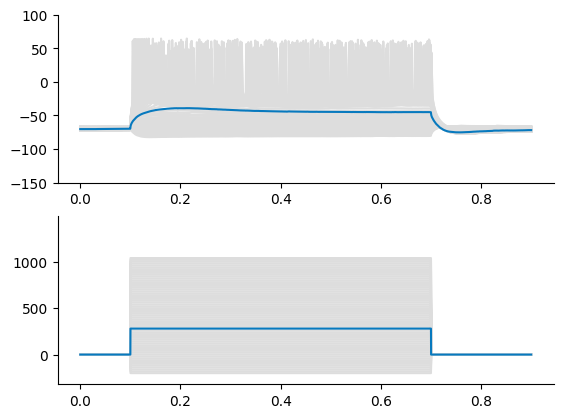

In [25]:
test_fig = plot_iclamp_sweep(test_data_set, test_sweep_table['sweep_number'].tolist(), 24, min_max_i=(-320, 1490), min_max_v=(-150, 100))
plt.show()

In [26]:
# reuse figure to plot another sweep
test_fig=plot_iclamp_sweep(test_data_set, test_sweep_table['sweep_number'].tolist(), 40, fig=test_fig, min_max_i=(-320, 1490), min_max_v=(-150, 100))
test_fig.show()

In [27]:
figs_me_path = Path('electro_L5_me_figs_0725')
figs_me_path.mkdir(exist_ok=True)

In [29]:
for _, row in tqdm(electro_df_me.iterrows(), total=electro_df_me.shape[0], desc='plot neuron'):
    plot_nwb_trace(row['path'], row['Cell'], figs_me_path, min_max_i=(-320, 1490), min_max_v=(-150, 100))

plot neuron:   0%|          | 0/154 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/69 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

In [30]:
failed_me=[row['Cell'] for _, row in electro_df_me.iterrows() if len([f for f in (figs_me_path/Path(row['Cell'])).iterdir()])<2]
len(failed_me)

0

In [ ]:
from shutil import rmtree
for d in failed_me:
    rmtree(figs_me_path/d)
removed_me = [row['Cell'] for _, row in electro_df_me.iterrows() if not (figs_me_path/row['Cell']).exists()]
len(removed_me)

In [14]:
figs_nm_path = Path('electro_L5_figs')
figs_nm_path.mkdir(exist_ok=True)

In [15]:
for _, row in tqdm(electro_df_nm.iterrows(), total=electro_df_nm.shape[0], desc='plot neuron'):
    plot_nwb_trace(row['path'], row['Cell'], figs_nm_path)

plot neuron:   0%|          | 0/205 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/68 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/60 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

plot sweep:   0%|          | 0/80 [00:00<?, ?it/s]

In [44]:
failed_nm=[row['Cell'] for _, row in electro_df_nm.iterrows() if len([f for f in (figs_nm_path/Path(row['Cell'])).iterdir()])<2]

165

In [47]:
for d in failed_nm:
    rmtree(figs_nm_path/d)
removed_nm = [row['Cell'] for _, row in electro_df_nm.iterrows() if not (figs_nm_path/row['Cell']).exists()]
len(removed_nm)

/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/envs/neuron/lib/python3.8/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/usr/local/envs/neuron/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: N/A
  warnings.warn("Could not find stimulus: %s" % tag)
